# Generative Adversarial Networks for Beginners
## Build a neural network that learns to generate handwritten digits.
### By [Jon Bruner](https://github.com/jonbruner) and [Adit Deshpande](https://github.com/adeshpande3)

This notebook accompanies [the O'Reilly interactive tutorial on generative adversarial networks](https://www.oreilly.com/learning/generative-adversarial-networks-for-beginners). See the original tutorial to run this code in a pre-built environment on O'Reilly's servers with cell-by-cell guidance, or run this notebook on your own machine.

Also, see [gan-script.py](gan-script.py) in this repository for a straight Python implementation of this code.

### Prerequisites

You'll need [TensorFlow](https://www.tensorflow.org/install/), [NumPy](https://docs.scipy.org/doc/numpy/user/install.html), [matplotlib](https://matplotlib.org/) and [Jupyter](https://jupyter.readthedocs.io/en/latest/install.html) in order to run this notebook on your machine. See [the readme](https://github.com/jonbruner/generative-adversarial-networks) for advice on installing these packages.

## Introduction

According to Yann LeCun, “adversarial training is the coolest thing since sliced bread.” Sliced bread certainly never created this much excitement within the deep learning community. Generative adversarial networks—or GANs, for short—have dramatically sharpened the possibility of AI-generated content, and have drawn active research efforts since they were [first described by Ian Goodfellow et al. in 2014](https://arxiv.org/abs/1406.2661).

GANs are neural networks that learn to create synthetic data similar to some known input data. For instance, researchers have generated convincing images from [photographs of everything from bedrooms to album covers](https://github.com/Newmu/dcgan_code), and they display a remarkable ability to reflect [higher-order semantic logic](https://github.com/Newmu/dcgan_code).

Those examples are fairly complex, but it's easy to build a GAN that generates very simple images. In this tutorial, we'll build a GAN that analyzes lots of images of handwritten digits and gradually learns to generate new images from scratch—*essentially, we'll be teaching a neural network how to write*.

<img src="notebook-images/gan-animation.gif" />
_Sample images from the generative adversarial network that we'll build in this tutorial. During training, it gradually refines its ability to generate digits._

## GAN architecture

Generative adversarial networks consist of two models: a generative model and a discriminative model.

![caption](notebook-images/GAN_Overall.png)

The discriminator model is a classifier that determines whether a given image looks like a real image from the dataset or like an artificially created image. This is basically a binary classifier that will take the form of a normal convolutional neural network (CNN).

The generator model takes random input values and transforms them into images through a deconvolutional neural network.

Over the course of many training iterations, the weights and biases in the discriminator and the generator are trained through backpropagation. The discriminator learns to tell "real" images of handwritten digits apart from "fake" images created by the generator. At the same time, the generator uses feedback from the discriminator to learn how to produce convincing images that the discriminator can't distinguish from real images.

## Getting started

We’re going to create a GAN that will generate handwritten digits that can fool even the best classifiers (and humans too, of course). We'll use [TensorFlow](https://www.tensorflow.org/), a deep learning library open-sourced by Google that makes it easy to train neural networks on GPUs.

This tutorial expects that you're already at least a little bit familiar with TensorFlow. If you're not, we recommend reading "[Hello, TensorFlow!](https://www.oreilly.com/learning/hello-tensorflow)" or watching the "[Hello, Tensorflow!](https://www.safaribooksonline.com/oriole/hello-tensorflow-oriole)" interactive tutorial on Safari before proceeding.

## Loading MNIST data

We need a set of real handwritten digits to give the discriminator a starting point in distinguishing between real and fake images. We'll use [MNIST](http://yann.lecun.com/exdb/mnist/), a benchmark dataset in deep learning. It consists of 70,000 images of handwritten digits compiled by the U.S. National Institute of Standards and Technology from Census Bureau employees and high school students.

Let's start by importing TensorFlow along with a couple of other helpful libraries. We'll also import our MNIST images using a TensorFlow convenience function called `read_data_sets`.

In [1]:
import tensorflow as tf
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


The MNIST variable we created above contains both the images and their labels, divided into a training set called `train` and a validation set called `validation`. (We won't need to worry about the labels in this tutorial.) We can retrieve batches of images by calling `next_batch` on `mnist`. Let's load one image and look at it.

The images are initially formatted as a single row of 784 pixels. We can reshape them into 28 x 28-pixel images and view them using pyplot.

(1, 784)


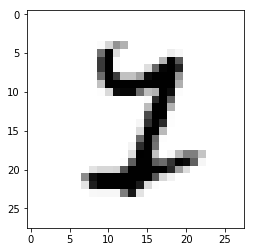

In [2]:
sample_image = mnist.train.next_batch(1)[0]
print(sample_image.shape)

sample_image = sample_image.reshape([28, 28])
plt.imshow(sample_image, cmap='Greys')

If you run the cell above again, you'll see a different image from the MNIST training set.

## Discriminator network

Our discriminator is a convolutional neural network that takes in an image of size 28 x 28 x 1 as input and returns a single scalar number that describes whether or not the input image is "real" or "fake"—that is, whether it's drawn from the set of MNIST images or generated by the generator.

![caption](notebook-images/GAN_Discriminator.png)

The structure of our discriminator network is based closely on [TensorFlow's sample CNN classifier model](https://www.tensorflow.org/get_started/mnist/pros). It features two convolutional layers that find 5x5-pixel features, and two "fully connected" layers that multiply weights by every pixel in the image.

To set up each layer, we start by creating weight and bias variables through [`tf.get_variable`](https://www.tensorflow.org/api_docs/python/tf/get_variable). Weights are initialized from a [truncated normal](https://www.tensorflow.org/api_docs/python/tf/truncated_normal) distribution, and biases are initialized at zero.

[`tf.nn.conv2d()`](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d) is TensorFlow's standard convolution function. It takes 4 arguments. The first is the input volume (our `28 x 28 x 1` images in this case). The next argument is the filter/weight matrix. Finally, you can also change the stride and padding of the convolution. Those two values affect the dimensions of the output volume.

If you're already comfortable with CNNs, you'll recognize this as a simple binary classifier—nothing fancy. 

In [3]:
def discriminator(images, reuse_variables=None):
    with tf.variable_scope(tf.get_variable_scope(), reuse=reuse_variables) as scope:
        # First convolutional and pool layers
        # This finds 32 different 5 x 5 pixel features
        d_w1 = tf.get_variable('d_w1', [5, 5, 1, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b1 = tf.get_variable('d_b1', [32], initializer=tf.constant_initializer(0))
        d1 = tf.nn.conv2d(input=images, filter=d_w1, strides=[1, 1, 1, 1], padding='SAME')
        # print(d1)
        d1 = d1 + d_b1
        d1 = tf.nn.relu(d1)
        d1 = tf.nn.avg_pool(d1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        # print(d1)
        # Second convolutional and pool layers
        # This finds 64 different 5 x 5 pixel features
        d_w2 = tf.get_variable('d_w2', [5, 5, 32, 64], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b2 = tf.get_variable('d_b2', [64], initializer=tf.constant_initializer(0))
        d2 = tf.nn.conv2d(input=d1, filter=d_w2, strides=[1, 1, 1, 1], padding='SAME')
        # print(d2)
        d2 = d2 + d_b2
        d2 = tf.nn.relu(d2)
        d2 = tf.nn.avg_pool(d2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        # print(d2)

        # First fully connected layer
        d_w3 = tf.get_variable('d_w3', [7 * 7 * 64, 1024], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b3 = tf.get_variable('d_b3', [1024], initializer=tf.constant_initializer(0))
        d3 = tf.reshape(d2, [-1, 7 * 7 * 64])
        d3 = tf.matmul(d3, d_w3)
        # print(d3)
        d3 = d3 + d_b3
        d3 = tf.nn.relu(d3)
        # print(d3)

        # Second fully connected layer
        d_w4 = tf.get_variable('d_w4', [1024, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b4 = tf.get_variable('d_b4', [1], initializer=tf.constant_initializer(0))
        d4 = tf.matmul(d3, d_w4) + d_b4
        # print(d4)
        # d4 contains unscaled values!!!!! they will probably apply relu later on.
        return d4
# tf.reset_default_graph() 
# discriminator(mnist.train.next_batch(1)[0].reshape([1,28,28,1]))

## Generator network

![caption](notebook-images/GAN_Generator.png)

Now that we have our discriminator defined, let’s take a look at the generator model. We'll base the overall structure of our model on a simple generator published by [Tim O'Shea](https://github.com/osh/KerasGAN).

You can think of the generator as a kind of reverse convolutional neural network. A typical CNN like our discriminator network transforms a 2- or 3-dimensional matrix of pixel values into a single probability. A generator, however, takes a `d`-dimensional vector of noise and upsamples it to become a 28 x 28 image. ReLU and batch normalization are used to stabilize the outputs of each layer.

In our generator network, we use three convolutional layers along with interpolation until a `28 x 28` pixel image is formed. (Actually, as you'll see below, we've taken care to form `28 x 28 x 1` images; many TensorFlow tools for dealing with images anticipate that the images will have some number of _channels_—usually 1 for greyscale images or 3 for RGB color images.)

At the output layer we add a [`tf.sigmoid()`](https://www.tensorflow.org/api_docs/python/tf/sigmoid) activation function; this squeezes pixels that would appear grey toward either black or white, resulting in a crisper image.

In [4]:
def generator(z, batch_size, z_dim):
    g_w1 = tf.get_variable('g_w1', [z_dim, 3136], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b1 = tf.get_variable('g_b1', [3136], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g1 = tf.matmul(z, g_w1) + g_b1
    g1 = tf.reshape(g1, [-1, 56, 56, 1])
    # print(g1)
    g1 = tf.contrib.layers.batch_norm(g1, epsilon=1e-5, scope='bn1')
    # print(g1)
    g1 = tf.nn.relu(g1)

    # Generate 50 features
    g_w2 = tf.get_variable('g_w2', [3, 3, 1, z_dim/2], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b2 = tf.get_variable('g_b2', [z_dim/2], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g2 = tf.nn.conv2d(g1, g_w2, strides=[1, 2, 2, 1], padding='SAME')
    # print(g2)
    g2 = g2 + g_b2
    g2 = tf.contrib.layers.batch_norm(g2, epsilon=1e-5, scope='bn2')
    g2 = tf.nn.relu(g2)
    g2 = tf.image.resize_images(g2, [56, 56])
    # print(g2)

    # Generate 25 features
    g_w3 = tf.get_variable('g_w3', [3, 3, z_dim/2, z_dim/4], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b3 = tf.get_variable('g_b3', [z_dim/4], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g3 = tf.nn.conv2d(g2, g_w3, strides=[1, 2, 2, 1], padding='SAME')
    # print(g3)
    g3 = g3 + g_b3
    g3 = tf.contrib.layers.batch_norm(g3, epsilon=1e-5, scope='bn3')
    g3 = tf.nn.relu(g3)
    g3 = tf.image.resize_images(g3, [56, 56])

    # Final convolution with one output channel
    g_w4 = tf.get_variable('g_w4', [1, 1, z_dim/4, 1], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b4 = tf.get_variable('g_b4', [1], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g4 = tf.nn.conv2d(g3, g_w4, strides=[1, 2, 2, 1], padding='SAME')
    g4 = g4 + g_b4
    g4 = tf.sigmoid(g4)
    
    # Dimensions of g4: batch_size x 28 x 28 x 1
    return g4

# tf.reset_default_graph() 
# z_dimensions = 100
# z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions])
# generated_image_output = generator(z_placeholder, 1, z_dimensions)


## Generating a sample image

Now we’ve defined both the generator and discriminator functions. Let’s see what a sample output from an untrained generator looks like.

We need to open a TensorFlow session and create a placeholder for the input to our generator. The shape of the placeholder will be `None, z_dimensions`. The `None` keyword means that the value can be determined at session runtime. We normally have `None` as our first dimension so that we can have variable batch sizes. (With a batch size of 50, the input to the generator would be 50 x 100). With the `None` keywoard, we don't have to specify `batch_size` until later. 

In [5]:
z_dimensions = 100
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions])

Now, we create a variable (`generated_image_output`) that holds the output of the generator, and we'll also initialize the random noise vector that we're going to use as input. The [`np.random.normal()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.normal.html) function has three arguments. The first and second define the mean and standard deviation for the normal distribution (0 and 1 in our case), and the third defines the the shape of the vector (`1 x 100`).

In [6]:
generated_image_output = generator(z_placeholder, 1, z_dimensions)
z_batch = np.random.normal(0, 1, [1, z_dimensions])

Next, we initialize all the variables, feed our `z_batch` into the placeholder, and run the session.

The [`sess.run()`](https://www.tensorflow.org/api_docs/python/tf/Session#run) function has two arguments. The first is called the "fetches" argument; it defines the value you're interested in computing. In our case, we want to see what the output of the generator is. If you look back at the last code snippet, you'll see that the output of the generator function is stored in `generated_image_output`, so we'll use `generated_image_output` for our first argument.

The second argument takes a dictionary of inputs that are substituted into the graph when it runs. This is where we feed in our placeholders. In our example, we need to feed our `z_batch` variable into the `z_placeholder` that we defined earlier. As before, we'll view the image by reshaping it to `28 x 28` pixels and show it with PyPlot.

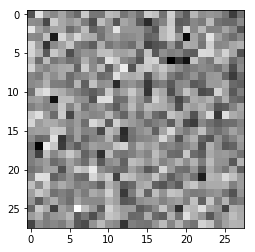

In [7]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    generated_image = sess.run(generated_image_output,
                                feed_dict={z_placeholder: z_batch})
    generated_image = generated_image.reshape([28, 28])
    plt.imshow(generated_image, cmap='Greys')

That looks like noise, right? Now we need to train the weights and biases in the generator network to convert random numbers into recognizable digits. Let's look at loss functions and optimization!

## Training a GAN

One of the trickiest parts about building and tuning GANs is that they have two loss functions: one that encourages the generator to create better images, and the other that encourages the discriminator to distinguish generated images from real images.

We train both the generator and the discriminator simultaneously. As the discriminator gets better at distinguishing real images from generated images, the generator is able to better tune its weights and biases to generate convincing images.

Here are the inputs and outputs for our networks.

In [8]:
tf.reset_default_graph()
batch_size = 50

z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions], name='z_placeholder') 
# z_placeholder is for feeding input noise to the generator

x_placeholder = tf.placeholder(tf.float32, shape = [None,28,28,1], name='x_placeholder') 
# x_placeholder is for feeding input images to the discriminator

Gz = generator(z_placeholder, batch_size, z_dimensions) 
# Gz holds the generated images

Dx = discriminator(x_placeholder) 
# Dx will hold discriminator prediction probabilities
# for the real MNIST images

Dg = discriminator(Gz, reuse_variables=True)
# Dg will hold discriminator prediction probabilities for generated images

So, let’s first think about what we want out of our networks. The discriminator's goal is to correctly label real MNIST images as real (return a higher output) and generated images as fake (return a lower output). We'll calculate two losses for the discriminator: one loss that compares `Dx` and 1 for real images from the MNIST set, as well as a loss that compares `Dg` and 0 for images from the generator. We'll do this with TensorFlow's [`tf.nn.sigmoid_cross_entropy_with_logits()`](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) function, which calculates the cross-entropy losses between `Dx` and 1 and between `Dg` and 0.

`sigmoid_cross_entropy_with_logits` operates on unscaled values rather than probability values from 0 to 1. Take a look at the last line of our discriminator: there's no softmax or sigmoid layer at the end. GANs can fail if their discriminators "saturate," or become confident enough to return exactly 0 when they're given a generated image; that leaves the discriminator without a useful gradient to descend.

The [`tf.reduce_mean()`](https://www.tensorflow.org/api_docs/python/tf/reduce_mean) function takes the mean value of all of the components in the matrix returned by the cross entropy function. This is a way of reducing the loss to a single scalar value, instead of a vector or matrix.

In [9]:
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dx, labels = tf.ones_like(Dx)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.zeros_like(Dg)))

Now let's set up the generator's loss function. We want the generator network to create images that will fool the discriminator: the generator wants the discriminator to output a value close to 1 when it's given an image from the generator. Therefore, we want to compute the loss between `Dg` and 1.

In [10]:
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.ones_like(Dg)))  

Now that we have our loss functions, we need to define our optimizers. The optimizer for the generator network needs to only update the generator’s weights, not those of the discriminator. Likewise, when we train the discriminator, we want to hold the generator's weights fixed.

In order to make this distinction, we need to create two lists of variables, one with the discriminator’s weights and biases and another with the generator’s weights and biases. This is where naming all of your TensorFlow variables with a thoughtful scheme can come in handy.

In [11]:
tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]

print([v.name for v in d_vars])
print([v.name for v in g_vars])

['d_w1:0', 'd_b1:0', 'd_w2:0', 'd_b2:0', 'd_w3:0', 'd_b3:0', 'd_w4:0', 'd_b4:0']
['g_w1:0', 'g_b1:0', 'g_w2:0', 'g_b2:0', 'g_w3:0', 'g_b3:0', 'g_w4:0', 'g_b4:0']


Next, we specify our two optimizers. [Adam](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer) is usually the optimization algorithm of choice for GANs; it utilizes adaptive learning rates and momentum. We call Adam's minimize function and also specify the variables that we want it to update—the generator's weights and biases when we train the generator, and the discriminator's weights and biases when we train the discriminator.

We're setting up two different training operations for the discriminator here: one that trains the discriminator on real images and one that trains the discrmnator on fake images. It's sometimes useful to use different learning rates for these two training operations, or to use them separately to [regulate learning in other ways](https://github.com/jonbruner/ezgan).

In [12]:
# Train the discriminator
d_trainer_fake = tf.train.AdamOptimizer(0.0003).minimize(d_loss_fake, var_list=d_vars)
d_trainer_real = tf.train.AdamOptimizer(0.0003).minimize(d_loss_real, var_list=d_vars)

# Train the generator
g_trainer = tf.train.AdamOptimizer(0.0001).minimize(g_loss, var_list=g_vars)

It can be tricky to get GANs to converge, and moreover they often need to train for a very long time. [TensorBoard](https://www.tensorflow.org/how_tos/summaries_and_tensorboard/) is useful for tracking the training process; it can graph scalar properties like losses, display sample images during training, and illustrate the topology of the neural networks.

If you run this script on your own machine, include the cell below. Then, in a terminal window from the directory that this notebook lives in, run

```
tensorboard --logdir=tensorboard/
```

and open TensorBoard by visiting [`http://localhost:6006`](http://localhost:6006) in your web browser.

In [13]:
# From this point forward, reuse variables
tf.get_variable_scope().reuse_variables()

tf.summary.scalar('Generator_loss', g_loss)
tf.summary.scalar('Discriminator_loss_real', d_loss_real)
tf.summary.scalar('Discriminator_loss_fake', d_loss_fake)

images_for_tensorboard = generator(z_placeholder, batch_size, z_dimensions)
tf.summary.image('Generated_images', images_for_tensorboard, 5)
merged = tf.summary.merge_all()
logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
writer = tf.summary.FileWriter(logdir, sess.graph)

And now we iterate. We begin by briefly giving the discriminator some initial training; this helps it develop a gradient that's useful to the generator.

Then we move on to the main training loop. When we train the generator, we’ll feed a random `z` vector into the generator and pass its output to the discriminator (this is the `Dg` variable we specified earlier). The generator’s weights and biases will be updated in order to produce images that the discriminator is more likely to classify as real.

To train the discriminator, we’ll feed it a batch of images from the MNIST set to serve as the positive examples, and then train the discriminator again on generated images, using them as negative examples. Remember that as the generator improves its output, the discriminator continues to learn to classify the improved generator images as fake.

Because it takes a long time to train a GAN, **we recommend not running this code block if you're going through this tutorial for the first time**. Instead, follow along but then run the following code block, which loads a pre-trained model for us to continue the tutorial.

**If you want to run this code yourself, prepare to wait: it takes about three hours on a fast GPU, but could take ten times that long on a desktop CPU.**

dLossReal: 0.69333 dLossFake: 0.692512
dLossReal: 0.0188671 dLossFake: 0.0243558
dLossReal: 0.00081438 dLossFake: 0.00140217
Iteration: 0 at 2017-06-30 17:36:57.742002


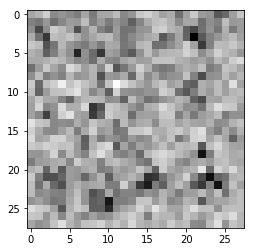

Estimate: [[-7.61783934]]
Iteration: 100 at 2017-06-30 17:37:03.537663


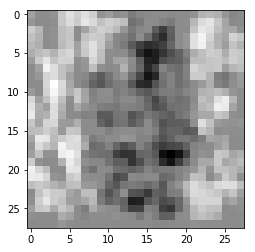

Estimate: [[-7.80826283]]
Iteration: 200 at 2017-06-30 17:37:09.294238


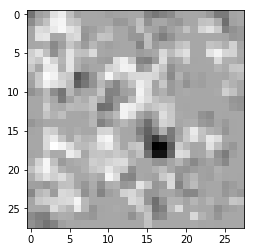

Estimate: [[-7.84076262]]
Iteration: 300 at 2017-06-30 17:37:15.025361


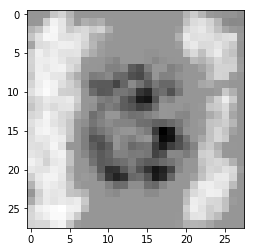

Estimate: [[-7.76436663]]
Iteration: 400 at 2017-06-30 17:37:20.944917


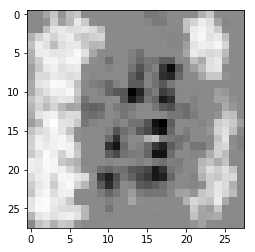

Estimate: [[-9.56063271]]
Iteration: 500 at 2017-06-30 17:37:26.749174


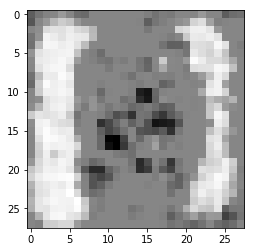

Estimate: [[-10.64663124]]
Iteration: 600 at 2017-06-30 17:37:32.496444


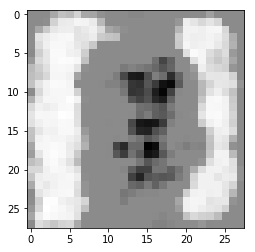

Estimate: [[-9.69513607]]
Iteration: 700 at 2017-06-30 17:37:38.293964


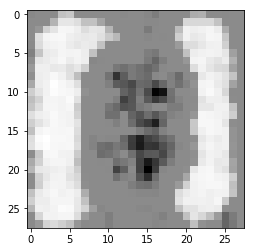

Estimate: [[-8.53460217]]
Iteration: 800 at 2017-06-30 17:37:44.271003


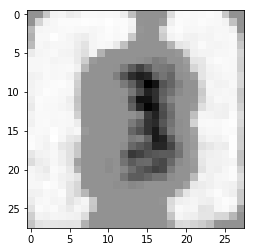

Estimate: [[-10.8307991]]
Iteration: 900 at 2017-06-30 17:37:50.059781


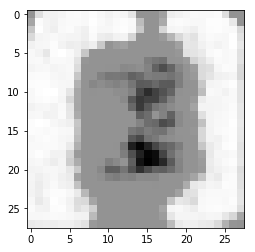

Estimate: [[-18.11703682]]
Iteration: 1000 at 2017-06-30 17:37:55.837695


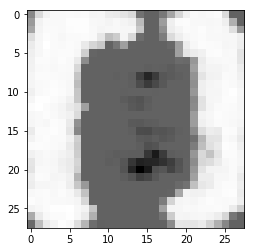

Estimate: [[-17.88021469]]
Iteration: 1100 at 2017-06-30 17:38:01.772472


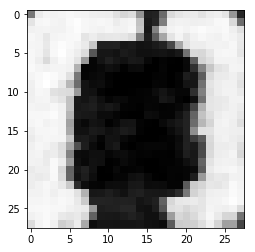

Estimate: [[-18.76331139]]
Iteration: 1200 at 2017-06-30 17:38:07.570892


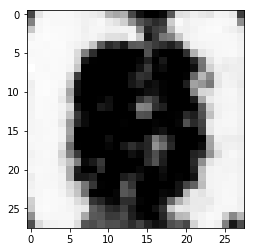

Estimate: [[-14.93852425]]
Iteration: 1300 at 2017-06-30 17:38:13.430492


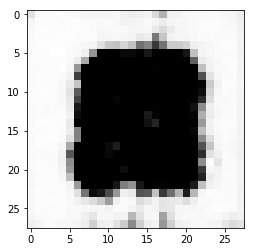

Estimate: [[-5.05058002]]
Iteration: 1400 at 2017-06-30 17:38:19.274794


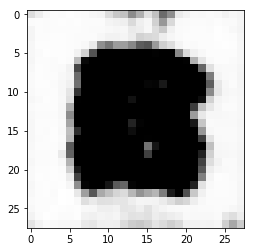

Estimate: [[-16.47499847]]
Iteration: 1500 at 2017-06-30 17:38:25.085401


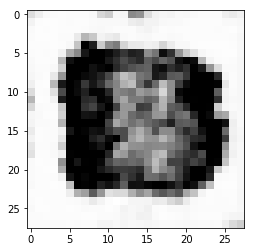

Estimate: [[-7.29280233]]
Iteration: 1600 at 2017-06-30 17:38:30.849971


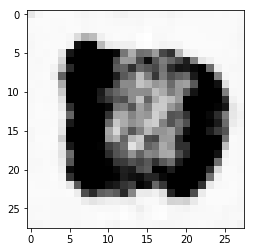

Estimate: [[-7.12863731]]
Iteration: 1700 at 2017-06-30 17:38:36.660803


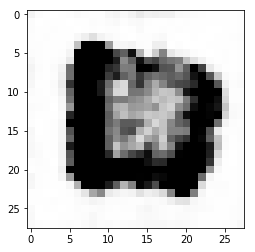

Estimate: [[-7.41462994]]
Iteration: 1800 at 2017-06-30 17:38:42.530886


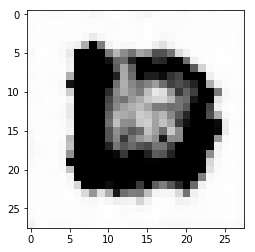

Estimate: [[-6.75854969]]
Iteration: 1900 at 2017-06-30 17:38:48.540060


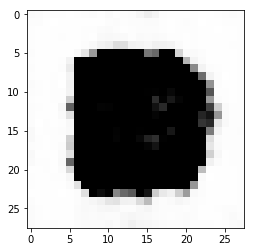

Estimate: [[-6.10081577]]
Iteration: 2000 at 2017-06-30 17:38:54.313194


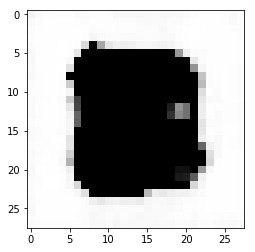

Estimate: [[-5.15003586]]
Iteration: 2100 at 2017-06-30 17:39:00.207785


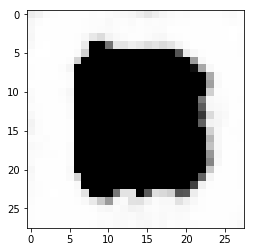

Estimate: [[-4.82407951]]
Iteration: 2200 at 2017-06-30 17:39:06.092323


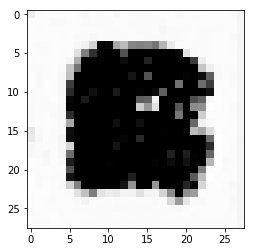

Estimate: [[ 6.99124622]]
Iteration: 2300 at 2017-06-30 17:39:11.905631


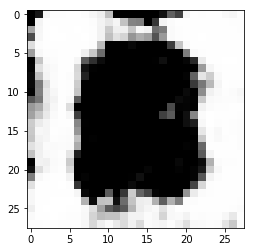

Estimate: [[-8.29561901]]
Iteration: 2400 at 2017-06-30 17:39:17.689322


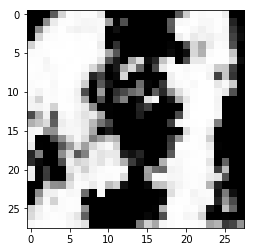

Estimate: [[-8.21443939]]
Iteration: 2500 at 2017-06-30 17:39:23.471345


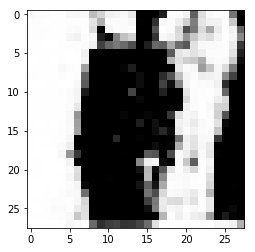

Estimate: [[-11.70656204]]
Iteration: 2600 at 2017-06-30 17:39:29.249358


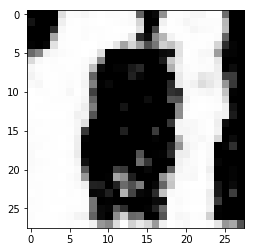

Estimate: [[-9.33394051]]
Iteration: 2700 at 2017-06-30 17:39:35.041412


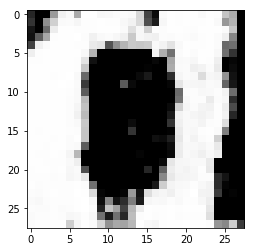

Estimate: [[-10.31713486]]
Iteration: 2800 at 2017-06-30 17:39:40.859082


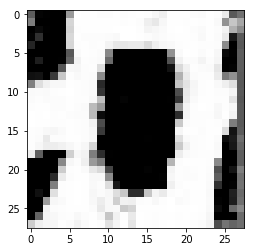

Estimate: [[-9.49984074]]
Iteration: 2900 at 2017-06-30 17:39:46.819410


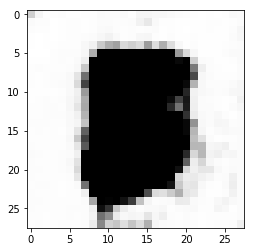

Estimate: [[-8.39405537]]
Iteration: 3000 at 2017-06-30 17:39:52.705079


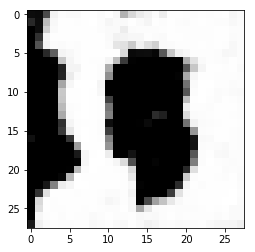

Estimate: [[-5.85414457]]
Iteration: 3100 at 2017-06-30 17:39:58.503214


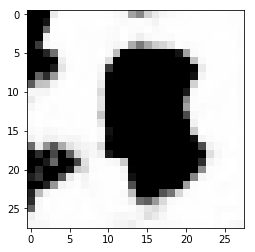

Estimate: [[-6.19063759]]
Iteration: 3200 at 2017-06-30 17:40:04.347022


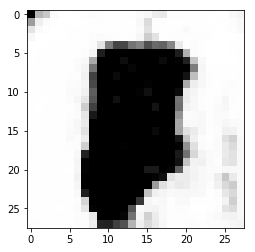

Estimate: [[-6.70528793]]
Iteration: 3300 at 2017-06-30 17:40:10.207051


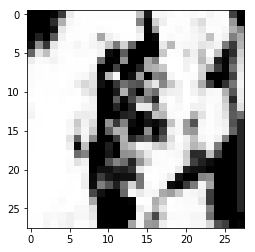

Estimate: [[-2.24051285]]
Iteration: 3400 at 2017-06-30 17:40:16.076380


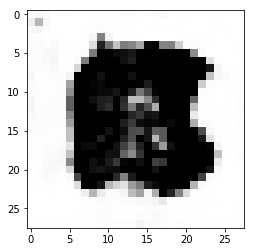

Estimate: [[-9.28959465]]
Iteration: 3500 at 2017-06-30 17:40:21.945583


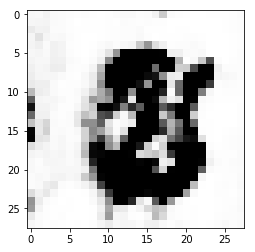

Estimate: [[-6.49167824]]
Iteration: 3600 at 2017-06-30 17:40:27.808779


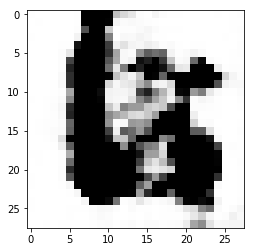

Estimate: [[-6.89997578]]
Iteration: 3700 at 2017-06-30 17:40:33.647572


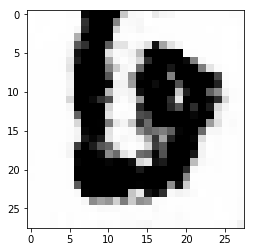

Estimate: [[-6.3658576]]
Iteration: 3800 at 2017-06-30 17:40:39.550897


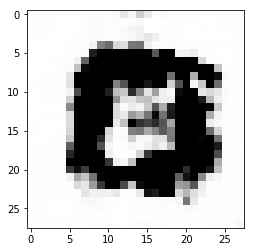

Estimate: [[-5.1221137]]
Iteration: 3900 at 2017-06-30 17:40:45.459404


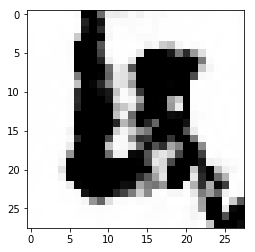

Estimate: [[-7.98445606]]
Iteration: 4000 at 2017-06-30 17:40:51.696840


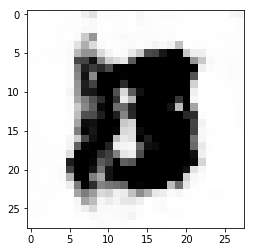

Estimate: [[ 5.73537397]]
Iteration: 4100 at 2017-06-30 17:40:57.706750


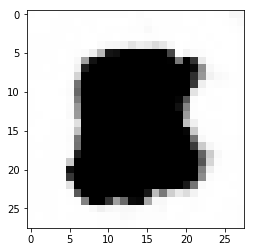

Estimate: [[-18.55888367]]
Iteration: 4200 at 2017-06-30 17:41:03.732877


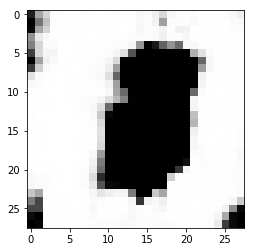

Estimate: [[-5.88918686]]
Iteration: 4300 at 2017-06-30 17:41:09.717092


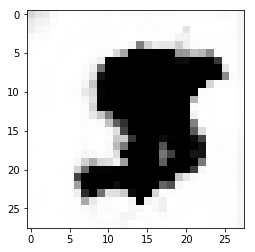

Estimate: [[-7.16058111]]
Iteration: 4400 at 2017-06-30 17:41:15.674781


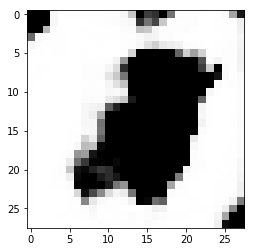

Estimate: [[-7.41050577]]
Iteration: 4500 at 2017-06-30 17:41:21.640978


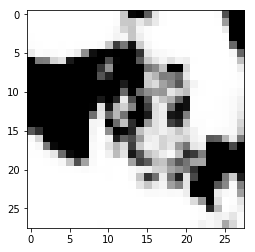

Estimate: [[ 1.38415325]]
Iteration: 4600 at 2017-06-30 17:41:27.623190


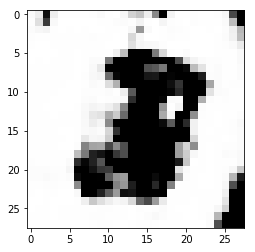

Estimate: [[-7.85461664]]
Iteration: 4700 at 2017-06-30 17:41:33.608906


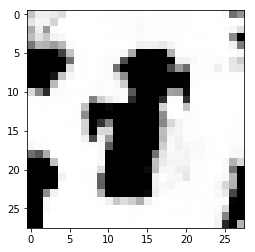

Estimate: [[-5.14624548]]
Iteration: 4800 at 2017-06-30 17:41:39.598125


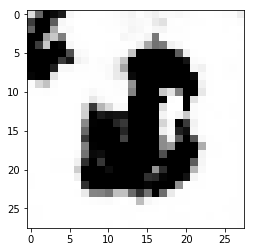

Estimate: [[-4.72433329]]
Iteration: 4900 at 2017-06-30 17:41:45.592850


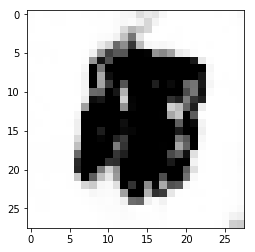

Estimate: [[-10.94812584]]
Iteration: 5000 at 2017-06-30 17:41:51.590077


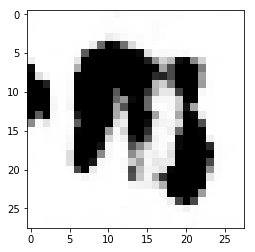

Estimate: [[-2.44884491]]
Iteration: 5100 at 2017-06-30 17:41:57.587807


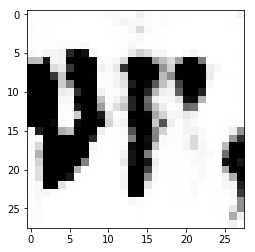

Estimate: [[-6.56739569]]
Iteration: 5200 at 2017-06-30 17:42:03.655602


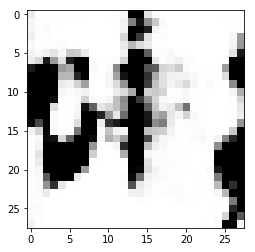

Estimate: [[-6.91893768]]
Iteration: 5300 at 2017-06-30 17:42:09.872539


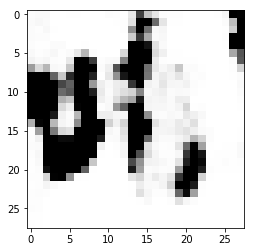

Estimate: [[-4.27097511]]
Iteration: 5400 at 2017-06-30 17:42:15.879274


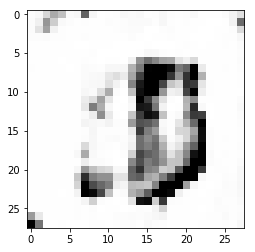

Estimate: [[-1.27202976]]
Iteration: 5500 at 2017-06-30 17:42:21.987607


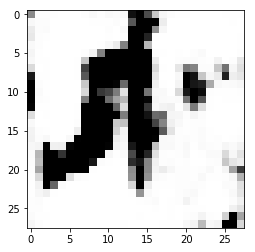

Estimate: [[-5.37451506]]
Iteration: 5600 at 2017-06-30 17:42:28.114458


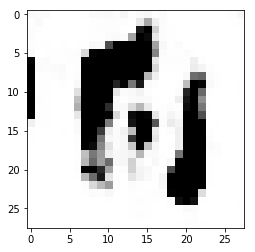

Estimate: [[-4.82367563]]
Iteration: 5700 at 2017-06-30 17:42:34.253323


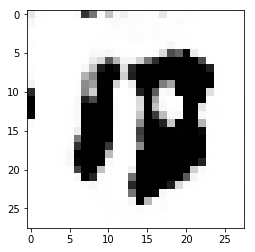

Estimate: [[-4.25429869]]
Iteration: 5800 at 2017-06-30 17:42:40.277576


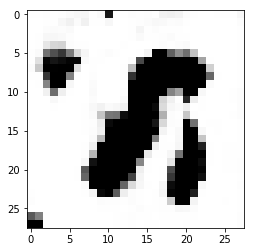

Estimate: [[-8.20617771]]
Iteration: 5900 at 2017-06-30 17:42:46.365389


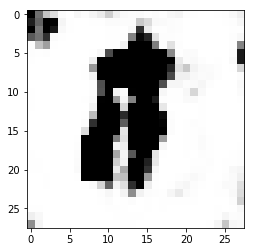

Estimate: [[-5.81533289]]
Iteration: 6000 at 2017-06-30 17:42:52.425676


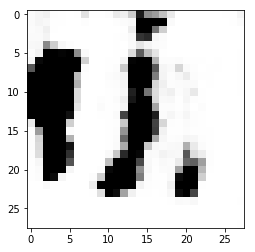

Estimate: [[-3.23304033]]
Iteration: 6100 at 2017-06-30 17:42:58.499977


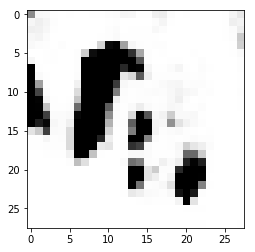

Estimate: [[-4.00571585]]
Iteration: 6200 at 2017-06-30 17:43:04.551756


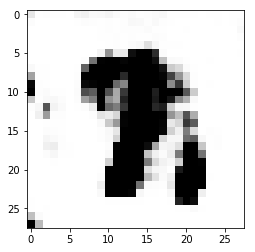

Estimate: [[-7.77706242]]
Iteration: 6300 at 2017-06-30 17:43:10.684112


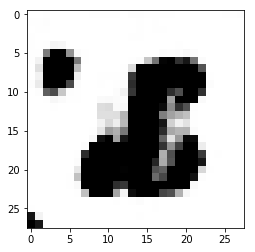

Estimate: [[-10.39933395]]
Iteration: 6400 at 2017-06-30 17:43:16.752907


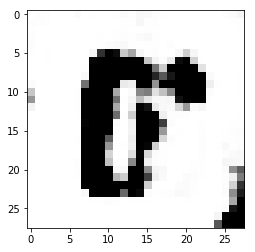

Estimate: [[-12.64067173]]
Iteration: 6500 at 2017-06-30 17:43:22.833714


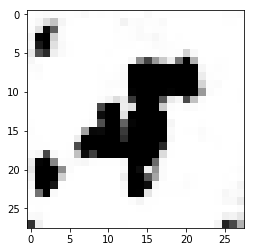

Estimate: [[-5.27867794]]
Iteration: 6600 at 2017-06-30 17:43:28.935040


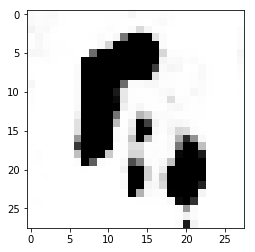

Estimate: [[-1.05400825]]
Iteration: 6700 at 2017-06-30 17:43:35.010841


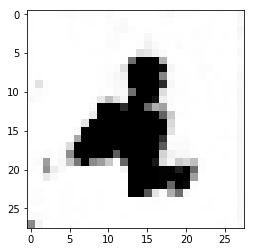

Estimate: [[-0.86231625]]
Iteration: 6800 at 2017-06-30 17:43:41.326873


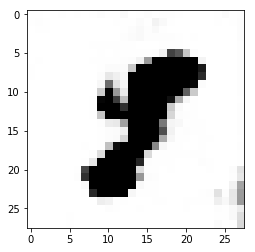

Estimate: [[ 0.63287008]]
Iteration: 6900 at 2017-06-30 17:43:47.405177


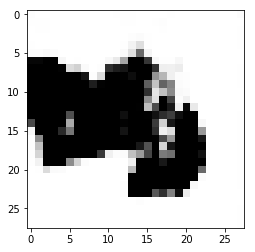

Estimate: [[ 1.30476201]]
Iteration: 7000 at 2017-06-30 17:43:53.488987


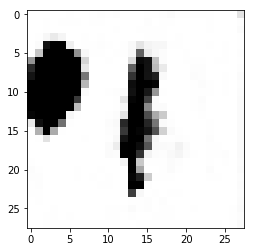

Estimate: [[-13.53471851]]
Iteration: 7100 at 2017-06-30 17:43:59.565289


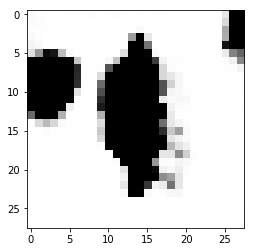

Estimate: [[-2.56349421]]
Iteration: 7200 at 2017-06-30 17:44:05.642592


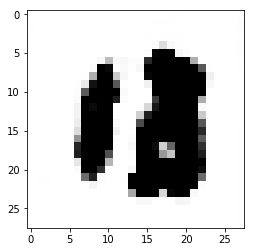

Estimate: [[-8.95077991]]
Iteration: 7300 at 2017-06-30 17:44:11.737913


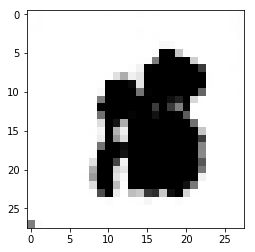

Estimate: [[ 1.21396053]]
Iteration: 7400 at 2017-06-30 17:44:17.912309


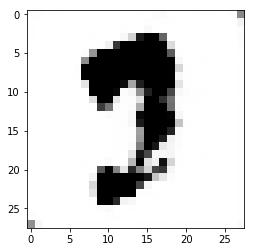

Estimate: [[ 0.66172248]]
Iteration: 7500 at 2017-06-30 17:44:24.009632


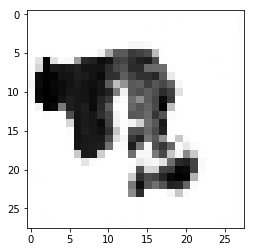

Estimate: [[ 6.04338312]]
Iteration: 7600 at 2017-06-30 17:44:30.112959


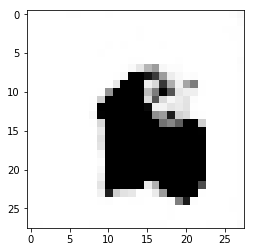

Estimate: [[ 2.76697326]]
Iteration: 7700 at 2017-06-30 17:44:36.289858


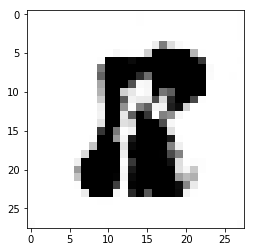

Estimate: [[-11.36671162]]
Iteration: 7800 at 2017-06-30 17:44:42.494783


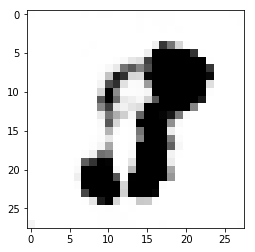

Estimate: [[-2.89615369]]
Iteration: 7900 at 2017-06-30 17:44:48.813317


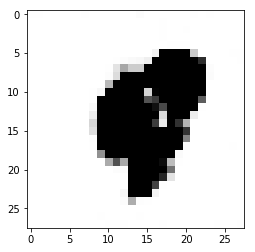

Estimate: [[ 3.96751595]]
Iteration: 8000 at 2017-06-30 17:44:55.225440


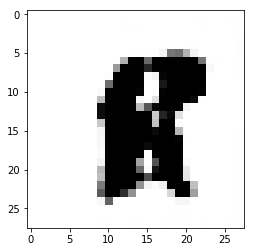

Estimate: [[-7.21550894]]
Iteration: 8100 at 2017-06-30 17:45:01.455889


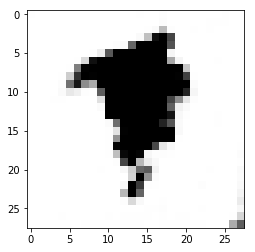

Estimate: [[-7.04852343]]
Iteration: 8200 at 2017-06-30 17:45:07.704359


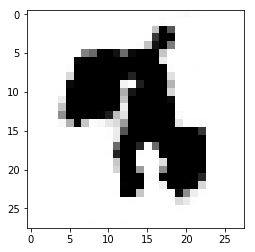

Estimate: [[-14.55434227]]
Iteration: 8300 at 2017-06-30 17:45:13.844222


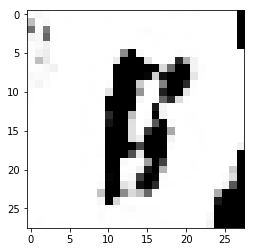

Estimate: [[-11.63428783]]
Iteration: 8400 at 2017-06-30 17:45:20.025625


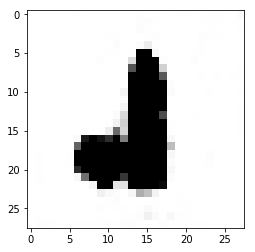

Estimate: [[ 1.11011744]]
Iteration: 8500 at 2017-06-30 17:45:26.561866


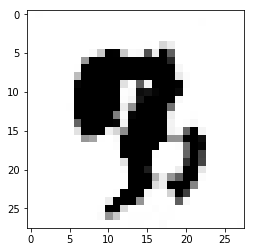

Estimate: [[ 0.23380934]]
Iteration: 8600 at 2017-06-30 17:45:32.716243


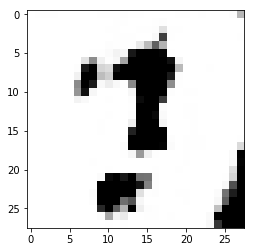

Estimate: [[-9.46319962]]
Iteration: 8700 at 2017-06-30 17:45:38.895143


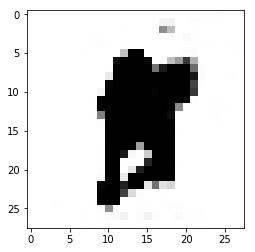

Estimate: [[-15.51722527]]
Iteration: 8800 at 2017-06-30 17:45:45.083052


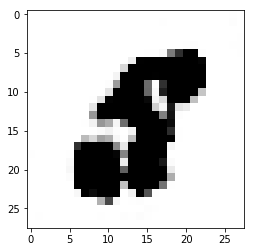

Estimate: [[-0.30363676]]
Iteration: 8900 at 2017-06-30 17:45:51.261956


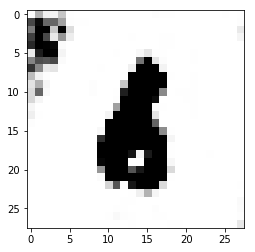

Estimate: [[-24.31012726]]
Iteration: 9000 at 2017-06-30 17:45:57.461876


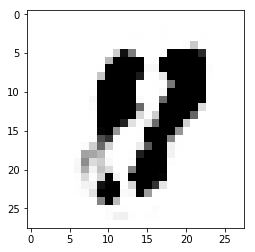

Estimate: [[-7.42290211]]
Iteration: 9100 at 2017-06-30 17:46:03.632269


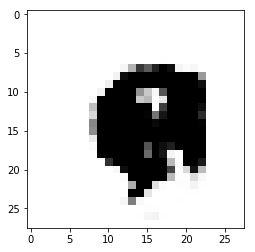

Estimate: [[-10.00967312]]
Iteration: 9200 at 2017-06-30 17:46:09.820678


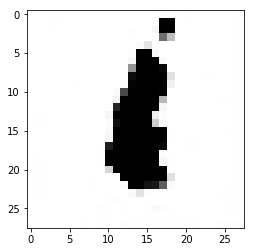

Estimate: [[-10.53694916]]
Iteration: 9300 at 2017-06-30 17:46:16.042119


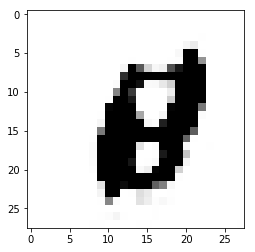

Estimate: [[-1.12732732]]
Iteration: 9400 at 2017-06-30 17:46:22.259556


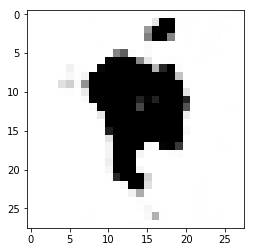

Estimate: [[-0.63018143]]
Iteration: 9500 at 2017-06-30 17:46:28.487504


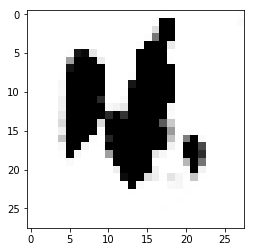

Estimate: [[ 7.62001371]]
Iteration: 9600 at 2017-06-30 17:46:34.842572


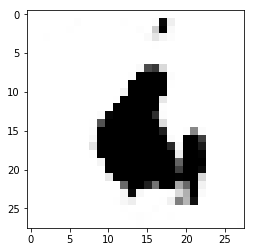

Estimate: [[-8.34787846]]
Iteration: 9700 at 2017-06-30 17:46:41.181125


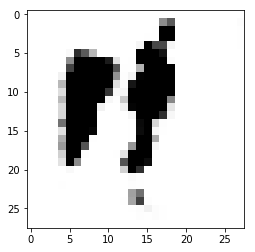

Estimate: [[-7.5367794]]
Iteration: 9800 at 2017-06-30 17:46:47.477641


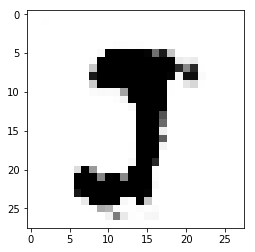

Estimate: [[-14.46455956]]
Iteration: 9900 at 2017-06-30 17:46:53.714097


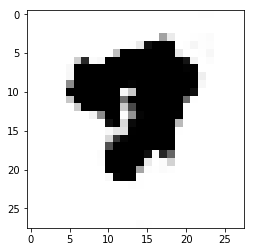

Estimate: [[-8.7230854]]
Iteration: 10000 at 2017-06-30 17:46:59.928984


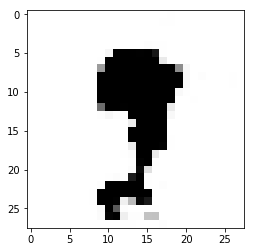

Estimate: [[-2.45411134]]
Iteration: 10100 at 2017-06-30 17:47:06.098856


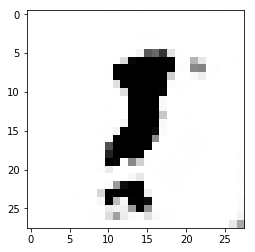

Estimate: [[-9.06017685]]
Iteration: 10200 at 2017-06-30 17:47:12.323975


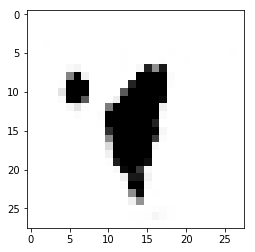

Estimate: [[-1.98911703]]
Iteration: 10300 at 2017-06-30 17:47:20.000770


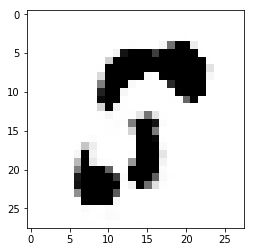

Estimate: [[-12.81499386]]
Iteration: 10400 at 2017-06-30 17:47:26.255743


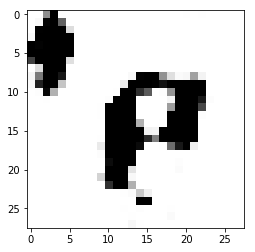

Estimate: [[-12.95451641]]
Iteration: 10500 at 2017-06-30 17:47:32.629329


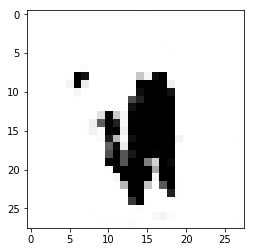

Estimate: [[-28.4247818]]
Iteration: 10600 at 2017-06-30 17:47:39.327726


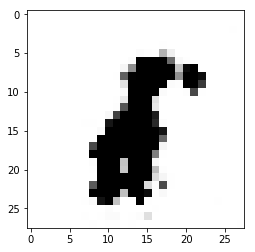

Estimate: [[-1.25220942]]
Iteration: 10700 at 2017-06-30 17:47:45.742852


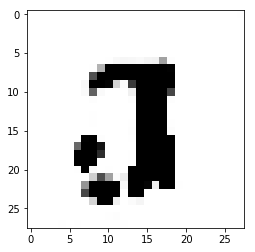

Estimate: [[-0.63382143]]
Iteration: 10800 at 2017-06-30 17:47:51.986313


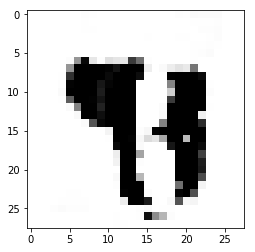

Estimate: [[-0.03255257]]
Iteration: 10900 at 2017-06-30 17:47:58.221268


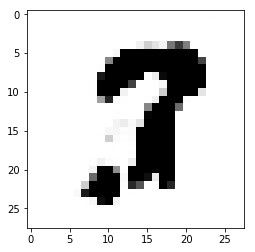

Estimate: [[-0.07154594]]
Iteration: 11000 at 2017-06-30 17:48:04.442708


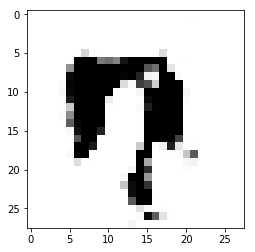

Estimate: [[-1.83374465]]
Iteration: 11100 at 2017-06-30 17:48:10.660648


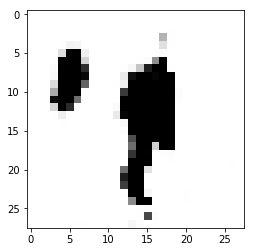

Estimate: [[-10.18485832]]
Iteration: 11200 at 2017-06-30 17:48:16.902108


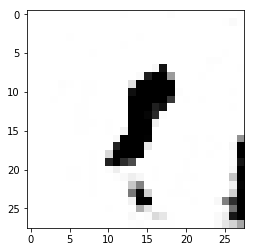

Estimate: [[-13.99734497]]
Iteration: 11300 at 2017-06-30 17:48:23.152577


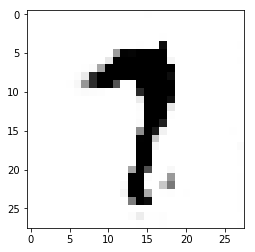

Estimate: [[-13.9068737]]
Iteration: 11400 at 2017-06-30 17:48:29.433575


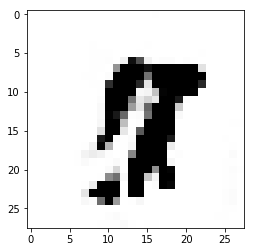

Estimate: [[ 1.54940486]]
Iteration: 11500 at 2017-06-30 17:48:35.780635


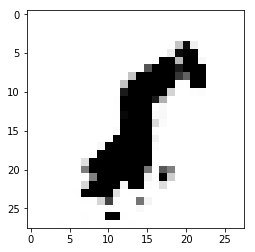

Estimate: [[-6.81337309]]
Iteration: 11600 at 2017-06-30 17:48:42.062134


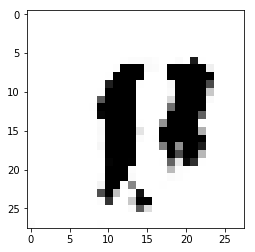

Estimate: [[ 1.15568912]]
Iteration: 11700 at 2017-06-30 17:48:48.367154


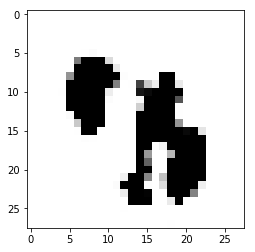

Estimate: [[-14.33293152]]
Iteration: 11800 at 2017-06-30 17:48:54.776779


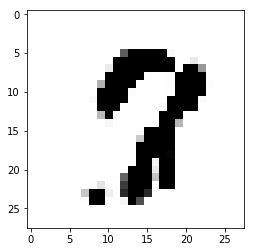

Estimate: [[-7.28042793]]
Iteration: 11900 at 2017-06-30 17:49:01.155875


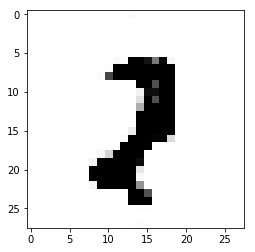

Estimate: [[-16.76721191]]
Iteration: 12000 at 2017-06-30 17:49:07.390828


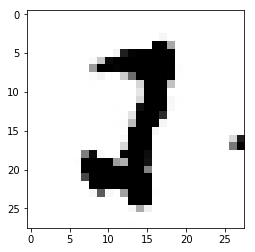

Estimate: [[-7.82055473]]
Iteration: 12100 at 2017-06-30 17:49:13.775425


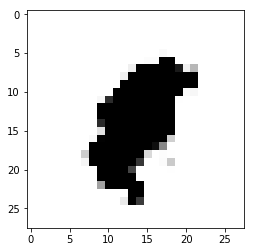

Estimate: [[-20.87266922]]
Iteration: 12200 at 2017-06-30 17:49:20.050417


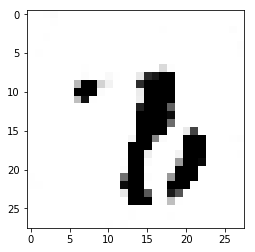

Estimate: [[-17.96007347]]
Iteration: 12300 at 2017-06-30 17:49:26.334925


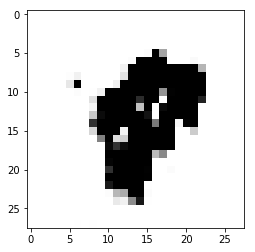

Estimate: [[-8.49857616]]
Iteration: 12400 at 2017-06-30 17:49:32.699503


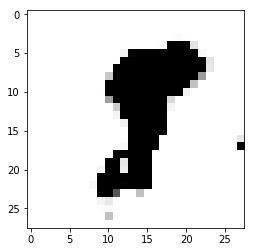

Estimate: [[-2.12817144]]
Iteration: 12500 at 2017-06-30 17:49:39.001520


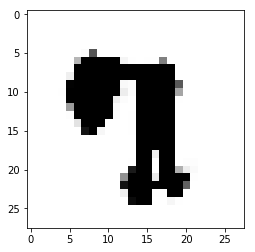

Estimate: [[ 4.94370317]]
Iteration: 12600 at 2017-06-30 17:49:45.359592


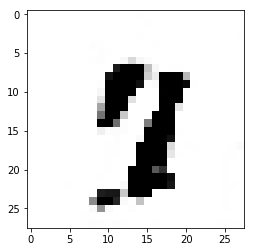

Estimate: [[-11.18874073]]
Iteration: 12700 at 2017-06-30 17:49:51.867807


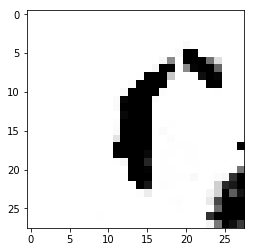

Estimate: [[-19.48180008]]
Iteration: 12800 at 2017-06-30 17:49:58.337485


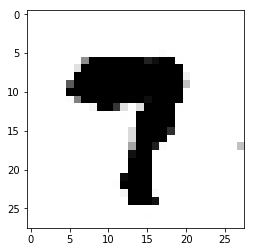

Estimate: [[-11.7630291]]
Iteration: 12900 at 2017-06-30 17:50:04.724583


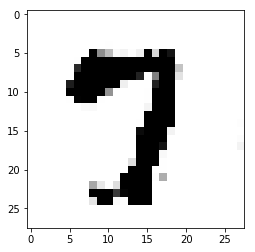

Estimate: [[-13.39406395]]
Iteration: 13000 at 2017-06-30 17:50:11.530583


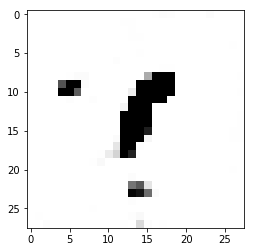

Estimate: [[-9.42797279]]
Iteration: 13100 at 2017-06-30 17:50:18.008273


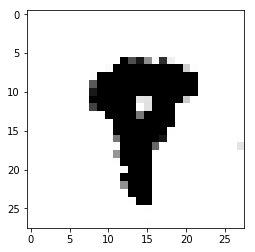

Estimate: [[-13.73773766]]
Iteration: 13200 at 2017-06-30 17:50:24.460934


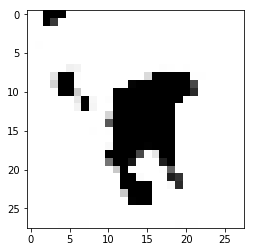

Estimate: [[-3.35452771]]
Iteration: 13300 at 2017-06-30 17:50:30.976156


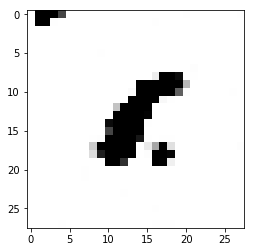

Estimate: [[ 5.27381849]]
Iteration: 13400 at 2017-06-30 17:50:37.410804


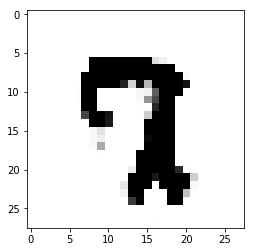

Estimate: [[-21.92085838]]
Iteration: 13500 at 2017-06-30 17:50:43.902503


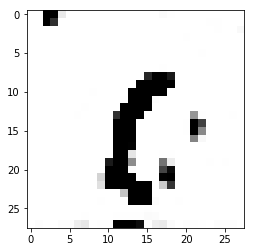

Estimate: [[-2.2305119]]
Iteration: 13600 at 2017-06-30 17:50:50.326637


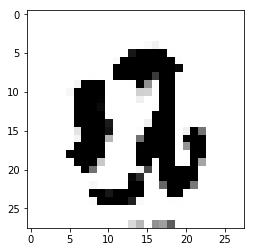

Estimate: [[-5.042243]]
Iteration: 13700 at 2017-06-30 17:50:56.768789


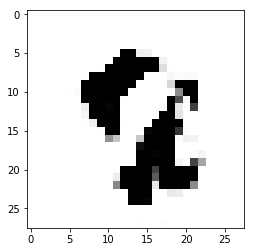

Estimate: [[-2.05995059]]
Iteration: 13800 at 2017-06-30 17:51:03.259492


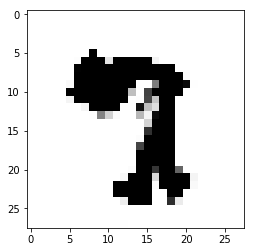

Estimate: [[-5.03354931]]
Iteration: 13900 at 2017-06-30 17:51:09.757197


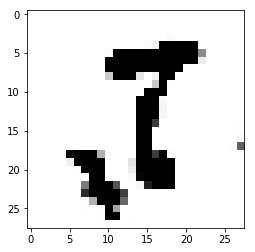

Estimate: [[-8.55043507]]
Iteration: 14000 at 2017-06-30 17:51:16.355001


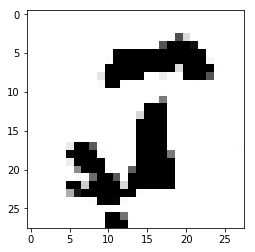

Estimate: [[ 2.20250297]]
Iteration: 14100 at 2017-06-30 17:51:22.849703


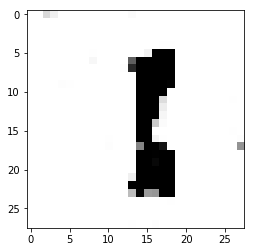

Estimate: [[ 17.01372147]]
Iteration: 14200 at 2017-06-30 17:51:29.266330


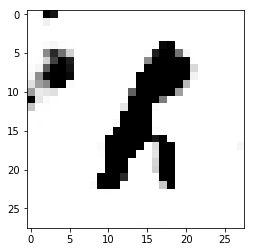

Estimate: [[-18.28229904]]
Iteration: 14300 at 2017-06-30 17:51:35.655431


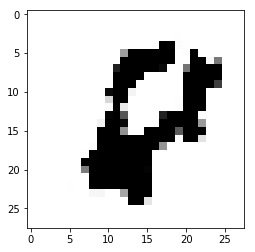

Estimate: [[ 32.22543716]]
Iteration: 14400 at 2017-06-30 17:51:42.043531


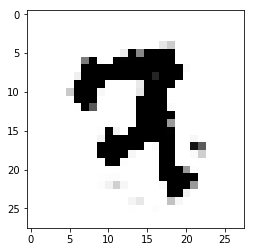

Estimate: [[-7.86821365]]
Iteration: 14500 at 2017-06-30 17:51:48.439138


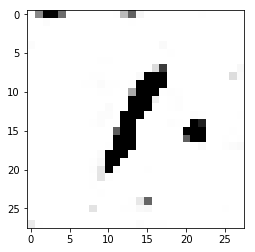

Estimate: [[-11.27338219]]
Iteration: 14600 at 2017-06-30 17:51:54.840250


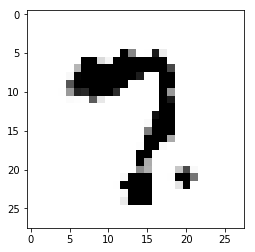

Estimate: [[-0.93452686]]
Iteration: 14700 at 2017-06-30 17:52:01.232354


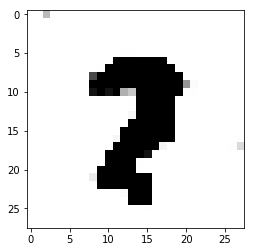

Estimate: [[-2.27516627]]
Iteration: 14800 at 2017-06-30 17:52:07.642976


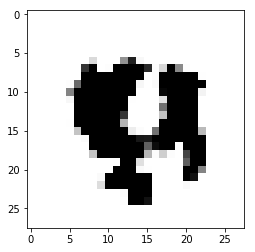

Estimate: [[-21.76402855]]
Iteration: 14900 at 2017-06-30 17:52:14.056601


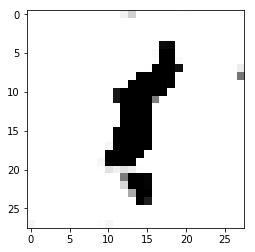

Estimate: [[ 0.89819854]]
Iteration: 15000 at 2017-06-30 17:52:20.482739


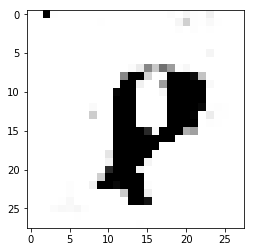

Estimate: [[-8.48126125]]
Iteration: 15100 at 2017-06-30 17:52:27.017480


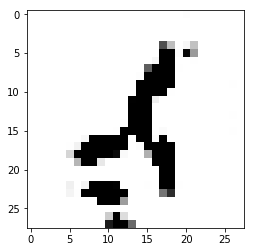

Estimate: [[-2.61150026]]
Iteration: 15200 at 2017-06-30 17:52:33.428101


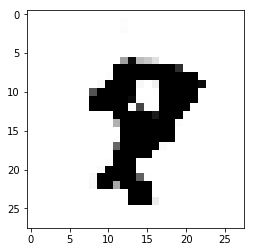

Estimate: [[ 16.56337738]]
Iteration: 15300 at 2017-06-30 17:52:39.858241


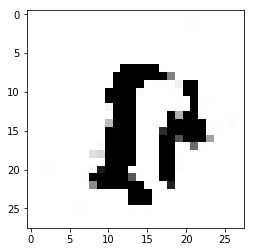

Estimate: [[-7.71580553]]
Iteration: 15400 at 2017-06-30 17:52:46.278872


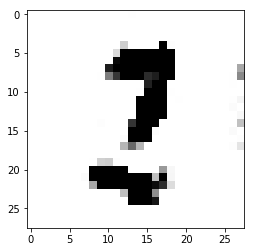

Estimate: [[ 9.91105461]]
Iteration: 15500 at 2017-06-30 17:52:52.728531


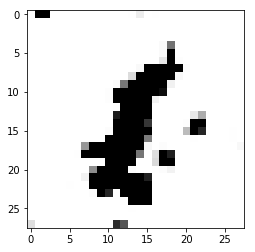

Estimate: [[-7.13698435]]
Iteration: 15600 at 2017-06-30 17:52:59.175687


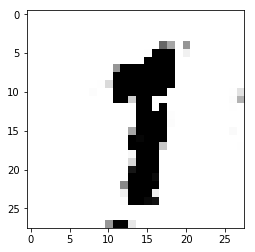

Estimate: [[-0.45074755]]
Iteration: 15700 at 2017-06-30 17:53:05.662883


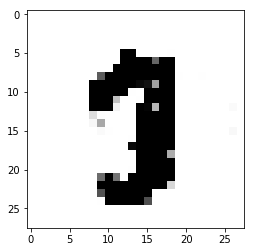

Estimate: [[ 8.21091366]]
Iteration: 15800 at 2017-06-30 17:53:12.721623


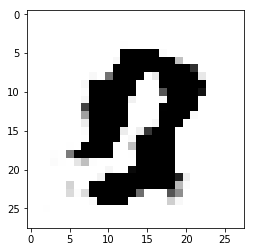

Estimate: [[-12.62737656]]
Iteration: 15900 at 2017-06-30 17:53:19.309914


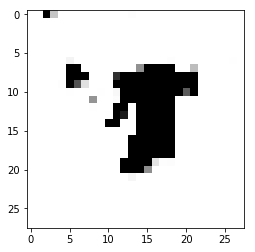

Estimate: [[-14.99350643]]
Iteration: 16000 at 2017-06-30 17:53:25.889697


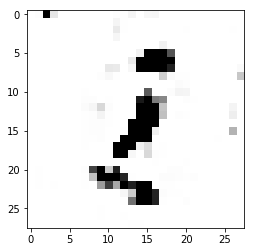

Estimate: [[-8.95070648]]
Iteration: 16100 at 2017-06-30 17:53:32.370390


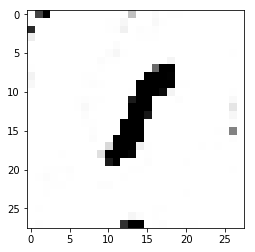

Estimate: [[-0.66900533]]
Iteration: 16200 at 2017-06-30 17:53:39.061279


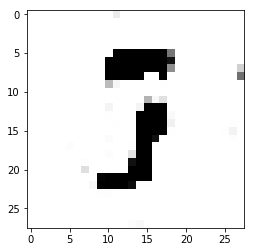

Estimate: [[-13.01712799]]
Iteration: 16300 at 2017-06-30 17:53:45.624046


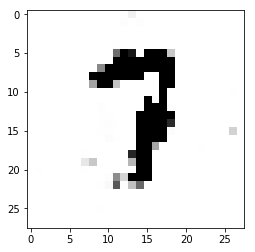

Estimate: [[-4.32268715]]
Iteration: 16400 at 2017-06-30 17:53:52.226851


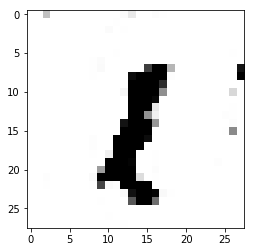

Estimate: [[-7.57333136]]
Iteration: 16500 at 2017-06-30 17:53:58.725056


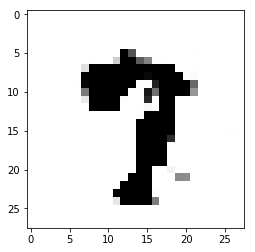

Estimate: [[-4.07908106]]
Iteration: 16600 at 2017-06-30 17:54:05.260297


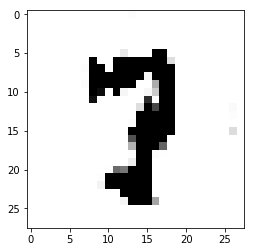

Estimate: [[-0.28058347]]
Iteration: 16700 at 2017-06-30 17:54:11.821562


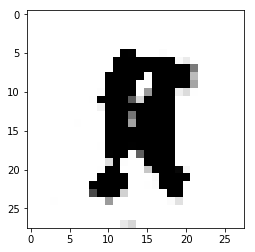

Estimate: [[-10.1351099]]
Iteration: 16800 at 2017-06-30 17:54:18.317765


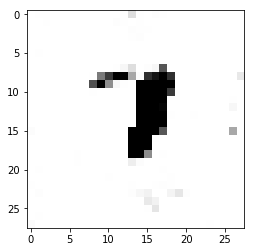

Estimate: [[ 21.60932732]]
Iteration: 16900 at 2017-06-30 17:54:24.808464


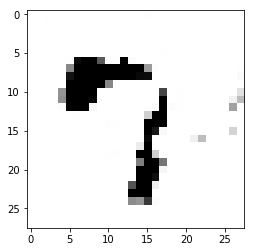

Estimate: [[-4.62592649]]
Iteration: 17000 at 2017-06-30 17:54:31.307670


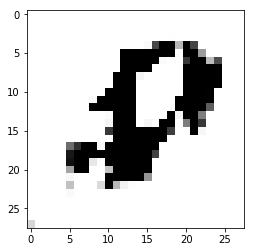

Estimate: [[ 5.45163822]]
Iteration: 17100 at 2017-06-30 17:54:37.866433


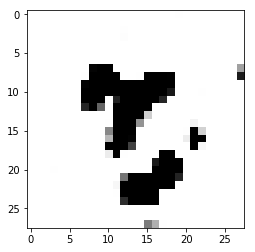

Estimate: [[-14.61076641]]
Iteration: 17200 at 2017-06-30 17:54:44.383656


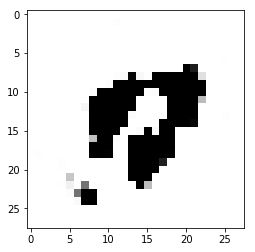

Estimate: [[-1.80753338]]
Iteration: 17300 at 2017-06-30 17:54:50.989968


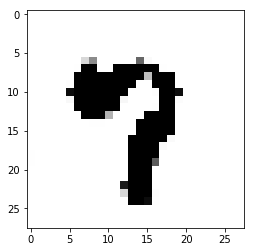

Estimate: [[ 22.318573]]
Iteration: 17400 at 2017-06-30 17:54:57.548231


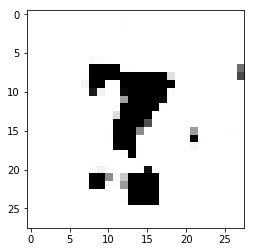

Estimate: [[ 9.2400322]]
Iteration: 17500 at 2017-06-30 17:55:04.163048


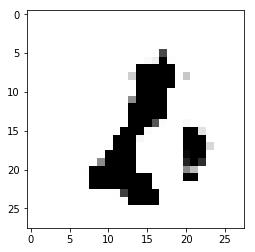

Estimate: [[-6.05477047]]
Iteration: 17600 at 2017-06-30 17:55:10.776863


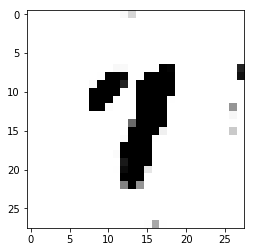

Estimate: [[ 5.95242977]]
Iteration: 17700 at 2017-06-30 17:55:17.378667


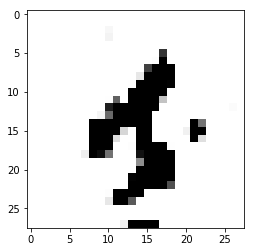

Estimate: [[-15.73220444]]
Iteration: 17800 at 2017-06-30 17:55:23.991982


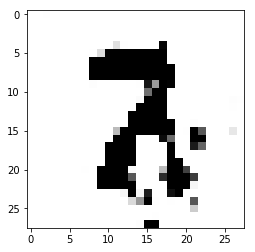

Estimate: [[-8.42855263]]
Iteration: 17900 at 2017-06-30 17:55:30.760449


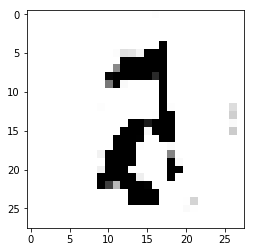

Estimate: [[-10.78385925]]
Iteration: 18000 at 2017-06-30 17:55:37.375270


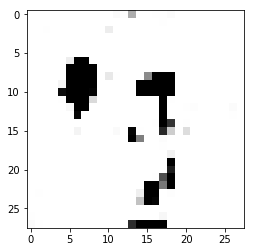

Estimate: [[-14.55888939]]
Iteration: 18100 at 2017-06-30 17:55:44.047141


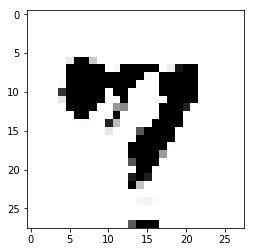

Estimate: [[ 1.22543669]]
Iteration: 18200 at 2017-06-30 17:55:50.762557


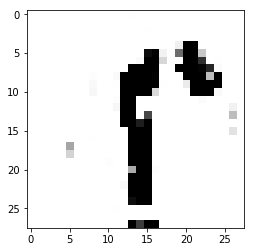

Estimate: [[-4.89908648]]
Iteration: 18300 at 2017-06-30 17:55:57.531520


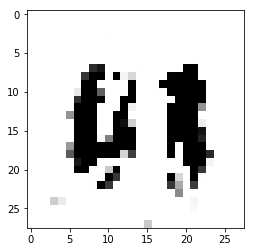

Estimate: [[-17.69731903]]
Iteration: 18400 at 2017-06-30 17:56:04.290975


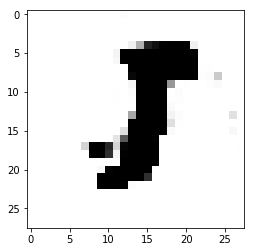

Estimate: [[ 2.24509406]]
Iteration: 18500 at 2017-06-30 17:56:10.999886


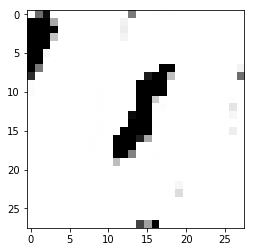

Estimate: [[ 36.98210144]]
Iteration: 18600 at 2017-06-30 17:56:17.626713


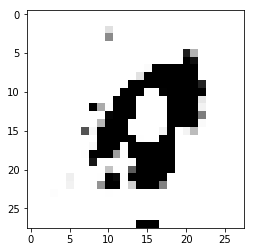

Estimate: [[ 46.42215347]]
Iteration: 18700 at 2017-06-30 17:56:24.361144


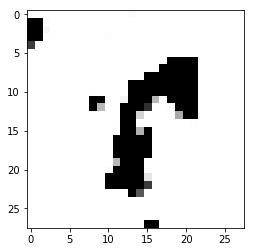

Estimate: [[-10.99245358]]
Iteration: 18800 at 2017-06-30 17:56:30.986471


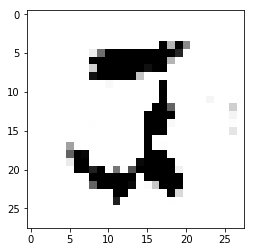

Estimate: [[ 6.39724159]]
Iteration: 18900 at 2017-06-30 17:56:37.615301


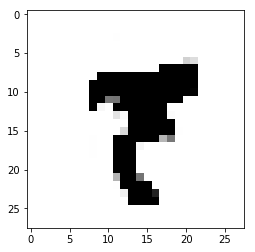

Estimate: [[ 2.01140976]]
Iteration: 19000 at 2017-06-30 17:56:44.770633


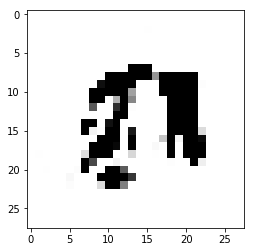

Estimate: [[-3.79554033]]
Iteration: 19100 at 2017-06-30 17:56:51.382948


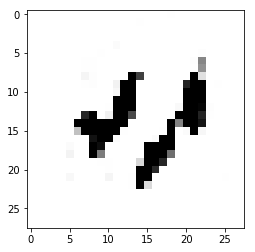

Estimate: [[-32.93190384]]
Iteration: 19200 at 2017-06-30 17:56:58.018784


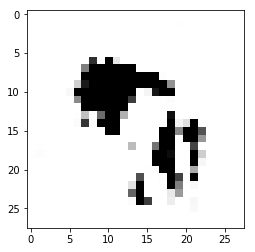

Estimate: [[-21.28637505]]
Iteration: 19300 at 2017-06-30 17:57:04.666632


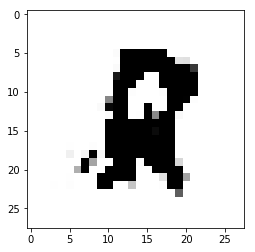

Estimate: [[ 6.69404697]]
Iteration: 19400 at 2017-06-30 17:57:11.303470


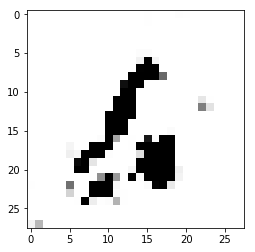

Estimate: [[-19.15846825]]
Iteration: 19500 at 2017-06-30 17:57:18.000870


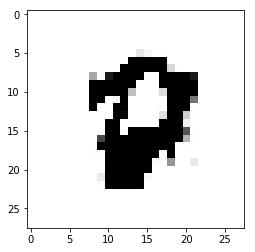

Estimate: [[ 11.14666462]]
Iteration: 19600 at 2017-06-30 17:57:24.657226


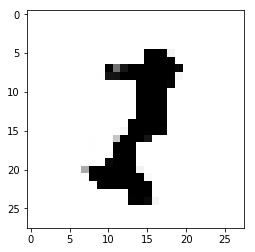

Estimate: [[-3.36326575]]
Iteration: 19700 at 2017-06-30 17:57:31.312581


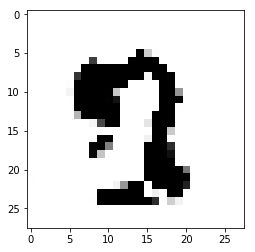

Estimate: [[-4.18151808]]
Iteration: 19800 at 2017-06-30 17:57:37.960433


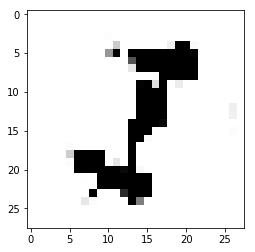

Estimate: [[-2.96265697]]
Iteration: 19900 at 2017-06-30 17:57:44.617794


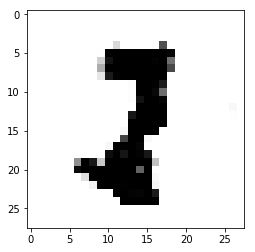

Estimate: [[-28.19151878]]
Iteration: 20000 at 2017-06-30 17:57:51.262139


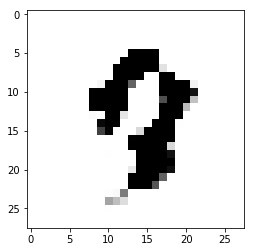

Estimate: [[ 27.46247673]]
Iteration: 20100 at 2017-06-30 17:57:57.928005


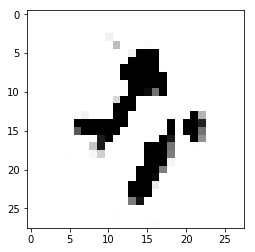

Estimate: [[-5.39558983]]
Iteration: 20200 at 2017-06-30 17:58:04.708979


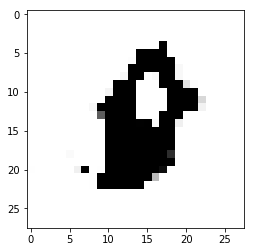

Estimate: [[-14.11826134]]
Iteration: 20300 at 2017-06-30 17:58:11.433901


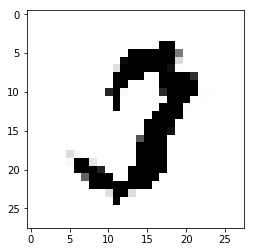

Estimate: [[-0.70152128]]
Iteration: 20400 at 2017-06-30 17:58:18.259919


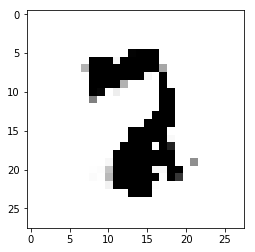

Estimate: [[ 23.83802414]]
Iteration: 20500 at 2017-06-30 17:58:25.026882


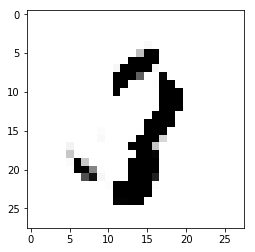

Estimate: [[ 8.05838776]]
Iteration: 20600 at 2017-06-30 17:58:31.847895


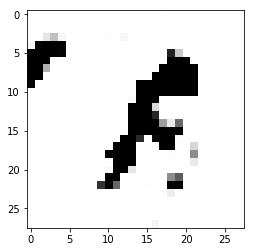

Estimate: [[ 3.12706327]]
Iteration: 20700 at 2017-06-30 17:58:38.729970


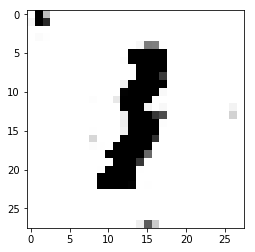

Estimate: [[-7.58419085]]
Iteration: 20800 at 2017-06-30 17:58:45.475412


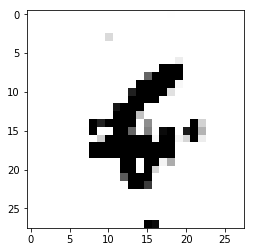

Estimate: [[ 2.27062511]]
Iteration: 20900 at 2017-06-30 17:58:52.224857


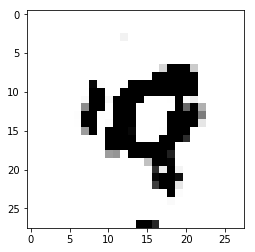

Estimate: [[-15.76403332]]
Iteration: 21000 at 2017-06-30 17:58:58.991318


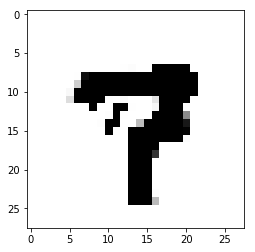

Estimate: [[-3.12252116]]
Iteration: 21100 at 2017-06-30 17:59:05.738761


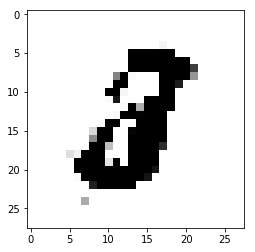

Estimate: [[-14.46871281]]
Iteration: 21200 at 2017-06-30 17:59:12.690400


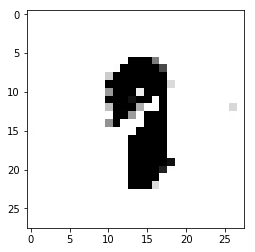

Estimate: [[ 2.8628757]]
Iteration: 21300 at 2017-06-30 17:59:19.504406


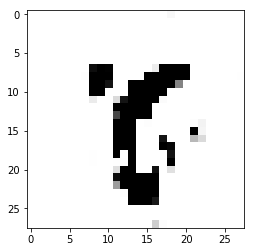

Estimate: [[ 9.6525631]]
Iteration: 21400 at 2017-06-30 17:59:26.278375


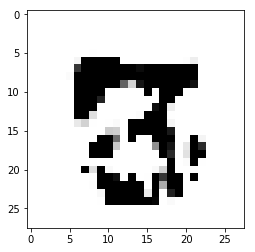

Estimate: [[-5.85197926]]
Iteration: 21500 at 2017-06-30 17:59:33.162949


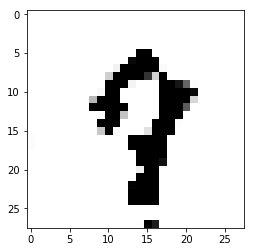

Estimate: [[ 0.59598434]]
Iteration: 21600 at 2017-06-30 17:59:40.085059


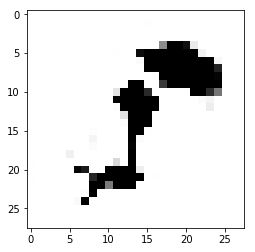

Estimate: [[-2.01404262]]
Iteration: 21700 at 2017-06-30 17:59:46.954619


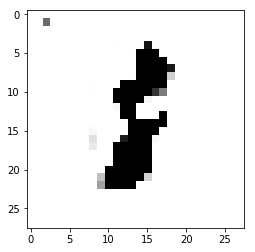

Estimate: [[ 1.79244876]]
Iteration: 21800 at 2017-06-30 17:59:53.772633


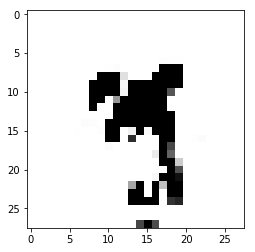

Estimate: [[ 3.12876487]]
Iteration: 21900 at 2017-06-30 18:00:00.537592


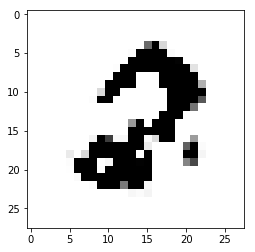

Estimate: [[-2.99309373]]
Iteration: 22000 at 2017-06-30 18:00:07.367114


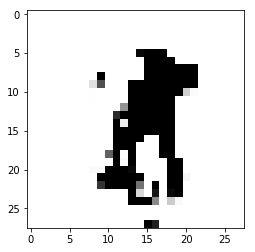

Estimate: [[-11.06297588]]
Iteration: 22100 at 2017-06-30 18:00:14.266202


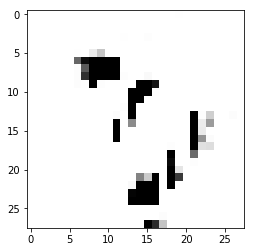

Estimate: [[-7.31926918]]
Iteration: 22200 at 2017-06-30 18:00:21.493103


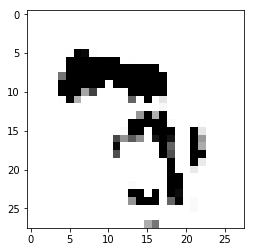

Estimate: [[ 32.76260757]]
Iteration: 22300 at 2017-06-30 18:00:28.517811


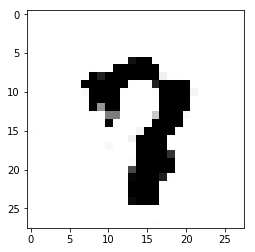

Estimate: [[-6.53291035]]
Iteration: 22400 at 2017-06-30 18:00:35.397381


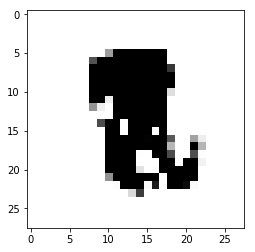

Estimate: [[-22.48236465]]
Iteration: 22500 at 2017-06-30 18:00:42.293971


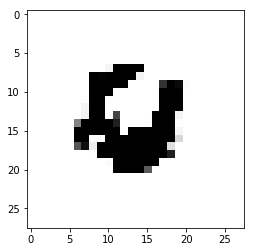

Estimate: [[ 5.99723101]]
Iteration: 22600 at 2017-06-30 18:00:49.098977


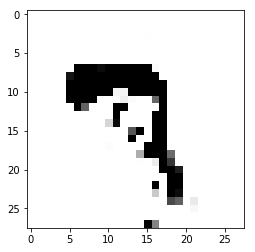

Estimate: [[-31.33872795]]
Iteration: 22700 at 2017-06-30 18:00:55.902974


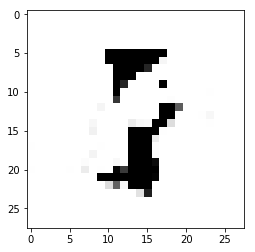

Estimate: [[-22.10482597]]
Iteration: 22800 at 2017-06-30 18:01:03.396129


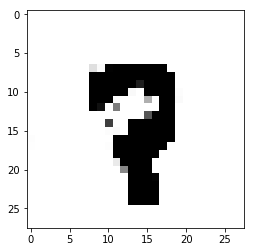

Estimate: [[-1.99479973]]
Iteration: 22900 at 2017-06-30 18:01:10.176604


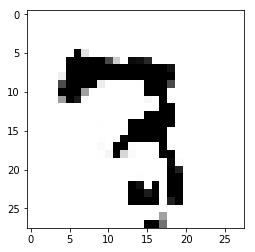

Estimate: [[-0.17020519]]
Iteration: 23000 at 2017-06-30 18:01:16.984605


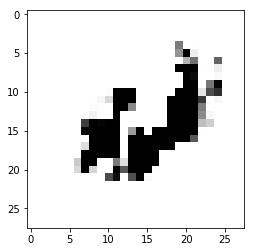

Estimate: [[ 16.33525085]]
Iteration: 23100 at 2017-06-30 18:01:23.795109


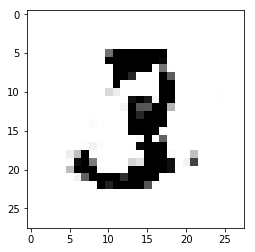

Estimate: [[-23.21489525]]
Iteration: 23200 at 2017-06-30 18:01:30.601108


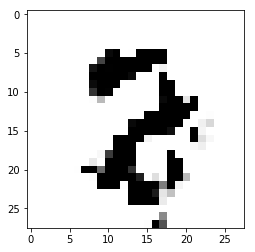

Estimate: [[ 16.66337967]]
Iteration: 23300 at 2017-06-30 18:01:37.408108


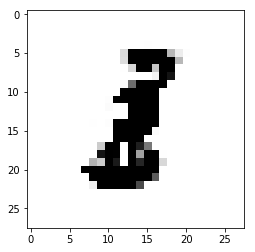

Estimate: [[ 31.97271538]]
Iteration: 23400 at 2017-06-30 18:01:44.323211


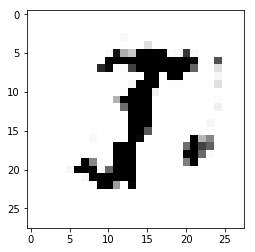

Estimate: [[-16.5118103]]
Iteration: 23500 at 2017-06-30 18:01:51.230307


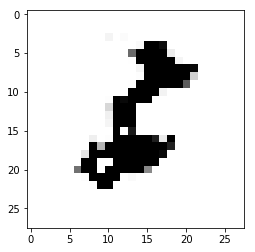

Estimate: [[ 41.25759888]]
Iteration: 23600 at 2017-06-30 18:01:58.230992


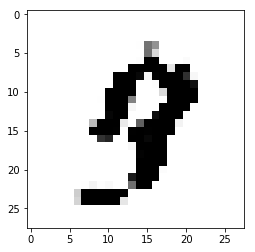

Estimate: [[-8.30071926]]
Iteration: 23700 at 2017-06-30 18:02:05.221167


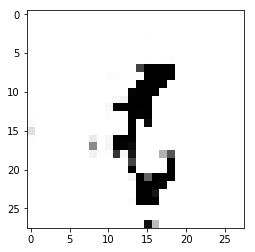

Estimate: [[-7.19113255]]
Iteration: 23800 at 2017-06-30 18:02:12.138272


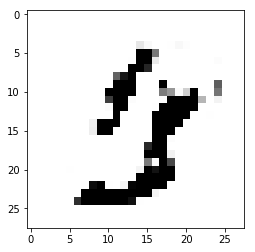

Estimate: [[-3.12370706]]
Iteration: 23900 at 2017-06-30 18:02:19.131450


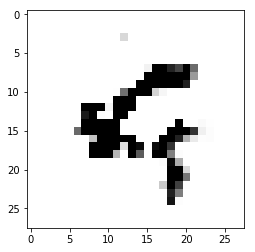

Estimate: [[ 31.79831123]]
Iteration: 24000 at 2017-06-30 18:02:26.012021


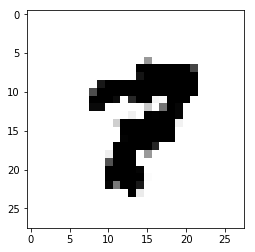

Estimate: [[ 4.63639069]]
Iteration: 24100 at 2017-06-30 18:02:32.869569


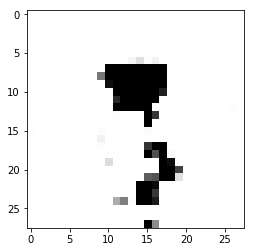

Estimate: [[ 18.71273422]]
Iteration: 24200 at 2017-06-30 18:02:39.715606


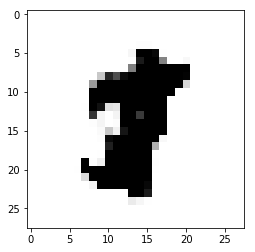

Estimate: [[-20.43780518]]
Iteration: 24300 at 2017-06-30 18:02:46.563646


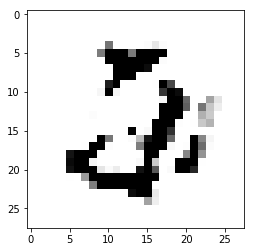

Estimate: [[ 55.64476395]]
Iteration: 24400 at 2017-06-30 18:02:53.383158


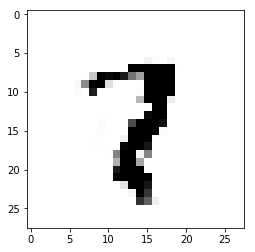

Estimate: [[-4.68416166]]
Iteration: 24500 at 2017-06-30 18:03:00.249214


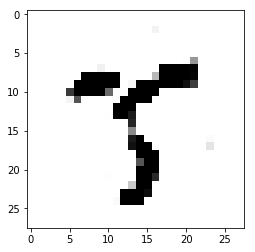

Estimate: [[-19.8749485]]
Iteration: 24600 at 2017-06-30 18:03:07.124279


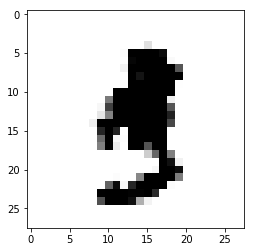

Estimate: [[-2.46071672]]
Iteration: 24700 at 2017-06-30 18:03:13.990336


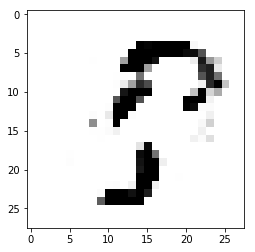

Estimate: [[ 29.93987846]]
Iteration: 24800 at 2017-06-30 18:03:20.878914


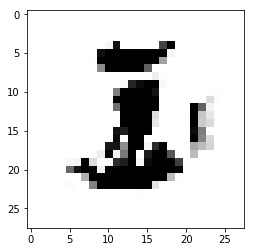

Estimate: [[ 0.11533964]]
Iteration: 24900 at 2017-06-30 18:03:27.758987


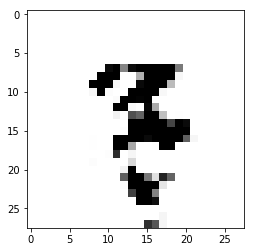

Estimate: [[-31.98983383]]
Iteration: 25000 at 2017-06-30 18:03:34.698613


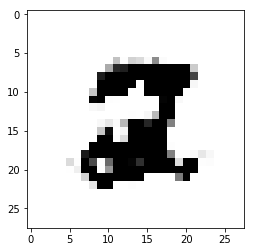

Estimate: [[ 5.44917345]]
Iteration: 25100 at 2017-06-30 18:03:41.585690


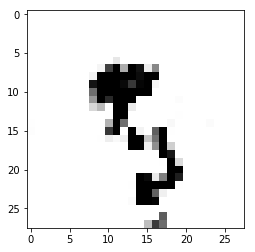

Estimate: [[ 16.87792397]]
Iteration: 25200 at 2017-06-30 18:03:48.465262


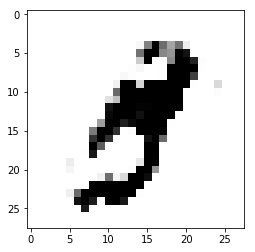

Estimate: [[-30.48752403]]
Iteration: 25300 at 2017-06-30 18:03:55.350337


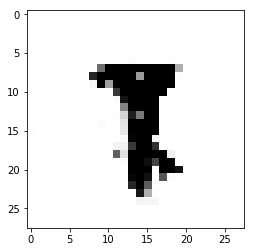

Estimate: [[-3.29309821]]
Iteration: 25400 at 2017-06-30 18:04:02.217895


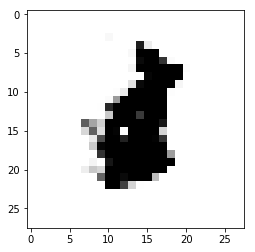

Estimate: [[-3.5]]
Iteration: 25500 at 2017-06-30 18:04:09.131997


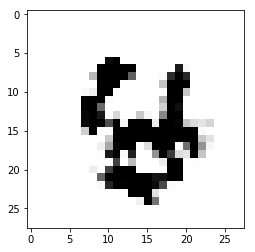

Estimate: [[ 4.82241058]]
Iteration: 25600 at 2017-06-30 18:04:16.053607


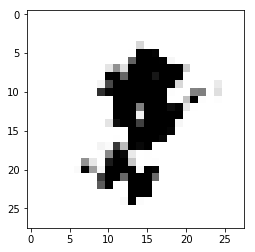

Estimate: [[-43.53497314]]
Iteration: 25700 at 2017-06-30 18:04:22.969711


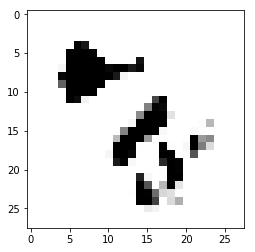

Estimate: [[ 8.97680569]]
Iteration: 25800 at 2017-06-30 18:04:29.901833


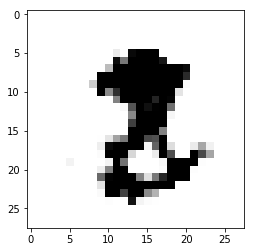

Estimate: [[ 42.62400436]]
Iteration: 25900 at 2017-06-30 18:04:36.851970


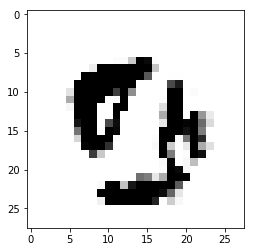

Estimate: [[-22.64627075]]
Iteration: 26000 at 2017-06-30 18:04:43.797102


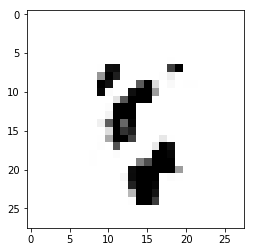

Estimate: [[-23.24066544]]
Iteration: 26100 at 2017-06-30 18:04:50.837826


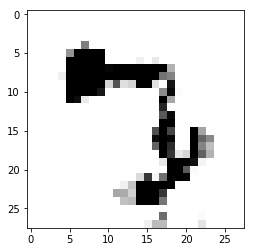

Estimate: [[-8.96658993]]
Iteration: 26200 at 2017-06-30 18:04:57.774449


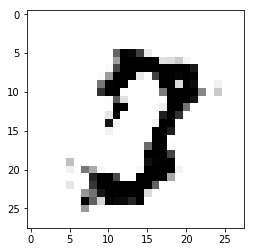

Estimate: [[-0.81590825]]
Iteration: 26300 at 2017-06-30 18:05:04.699062


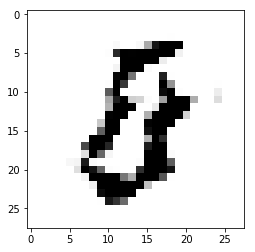

Estimate: [[-7.33946085]]
Iteration: 26400 at 2017-06-30 18:05:11.644694


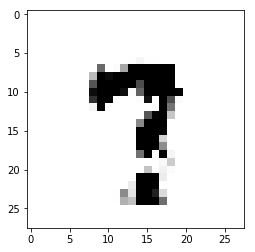

Estimate: [[-38.38825607]]
Iteration: 26500 at 2017-06-30 18:05:18.612348


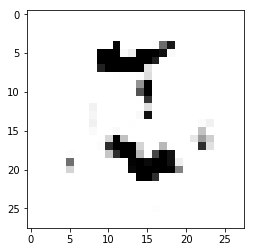

Estimate: [[-37.51486588]]
Iteration: 26600 at 2017-06-30 18:05:25.563986


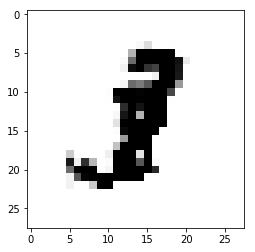

Estimate: [[-18.54063606]]
Iteration: 26700 at 2017-06-30 18:05:32.522131


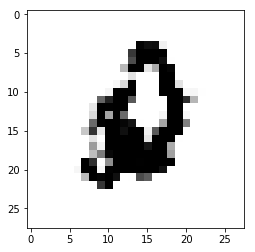

Estimate: [[ 38.81445312]]
Iteration: 26800 at 2017-06-30 18:05:39.475270


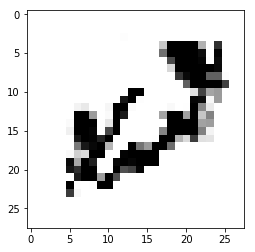

Estimate: [[ 27.66684341]]
Iteration: 26900 at 2017-06-30 18:05:46.320784


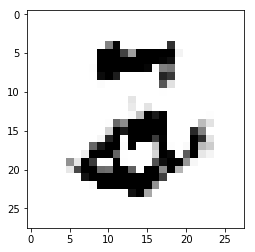

Estimate: [[-0.73856008]]
Iteration: 27000 at 2017-06-30 18:05:53.131540


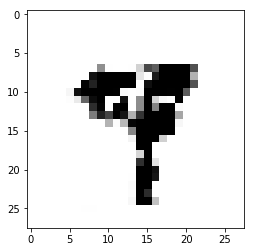

Estimate: [[-5.61884785]]
Iteration: 27100 at 2017-06-30 18:06:00.026708


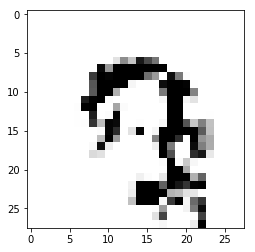

Estimate: [[-22.39215279]]
Iteration: 27200 at 2017-06-30 18:06:07.860707


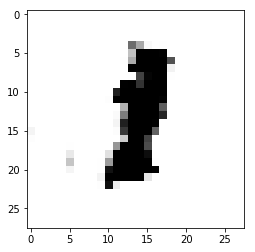

Estimate: [[ 7.17267942]]
Iteration: 27300 at 2017-06-30 18:06:14.819187


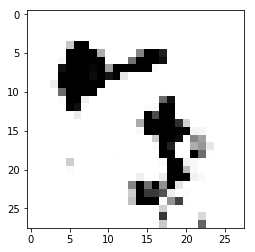

Estimate: [[ 16.24909019]]
Iteration: 27400 at 2017-06-30 18:06:21.850860


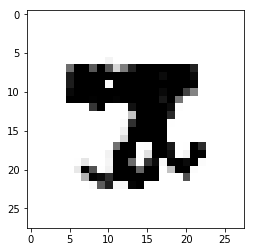

Estimate: [[ 2.13405871]]
Iteration: 27500 at 2017-06-30 18:06:29.015671


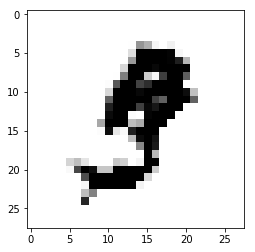

Estimate: [[-16.39188004]]
Iteration: 27600 at 2017-06-30 18:06:36.053391


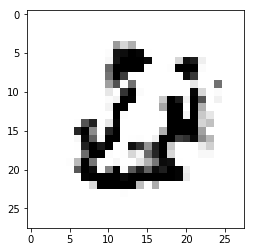

Estimate: [[ 9.5931921]]
Iteration: 27700 at 2017-06-30 18:06:43.093615


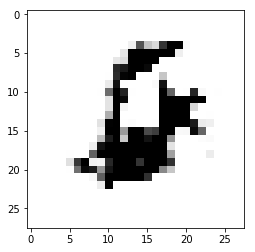

Estimate: [[ 31.35614586]]
Iteration: 27800 at 2017-06-30 18:06:50.108814


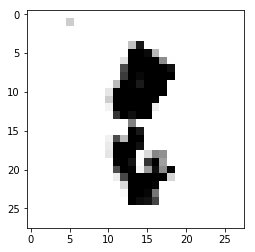

Estimate: [[-0.78898609]]
Iteration: 27900 at 2017-06-30 18:06:57.137525


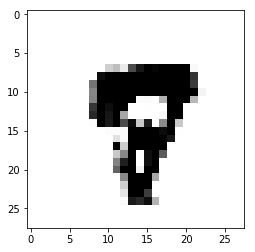

Estimate: [[ 37.76528549]]
Iteration: 28000 at 2017-06-30 18:07:04.147719


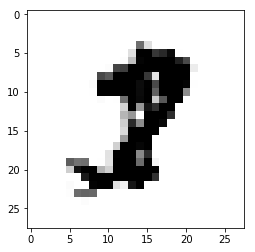

Estimate: [[-9.9600172]]
Iteration: 28100 at 2017-06-30 18:07:11.185440


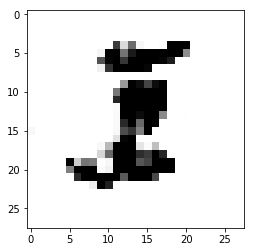

Estimate: [[ 12.88768196]]
Iteration: 28200 at 2017-06-30 18:07:18.219657


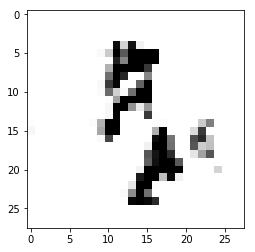

Estimate: [[-16.27991104]]
Iteration: 28300 at 2017-06-30 18:07:25.338455


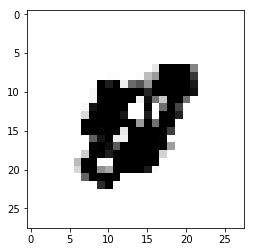

Estimate: [[ 3.02727032]]
Iteration: 28400 at 2017-06-30 18:07:32.374173


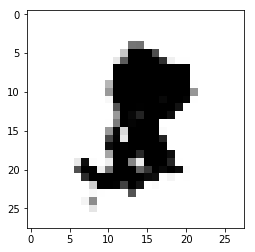

Estimate: [[-12.54755211]]
Iteration: 28500 at 2017-06-30 18:07:39.423905


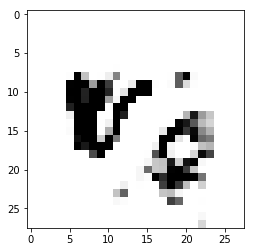

Estimate: [[-27.10615158]]
Iteration: 28600 at 2017-06-30 18:07:46.457121


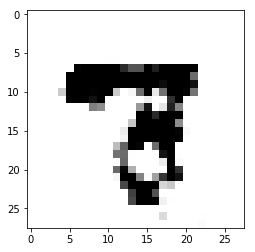

Estimate: [[ 6.61242771]]
Iteration: 28700 at 2017-06-30 18:07:53.479326


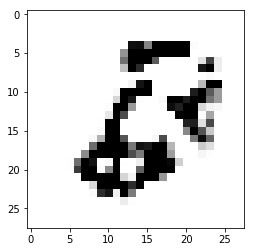

Estimate: [[-2.70493269]]
Iteration: 28800 at 2017-06-30 18:08:00.519549


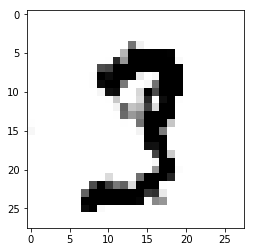

Estimate: [[-10.34649658]]
Iteration: 28900 at 2017-06-30 18:08:07.569782


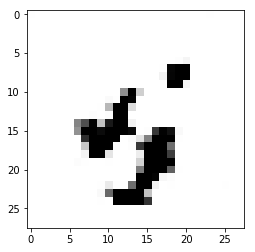

Estimate: [[-3.06730509]]
Iteration: 29000 at 2017-06-30 18:08:14.633026


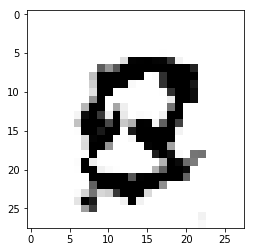

Estimate: [[ 22.31482315]]
Iteration: 29100 at 2017-06-30 18:08:21.703278


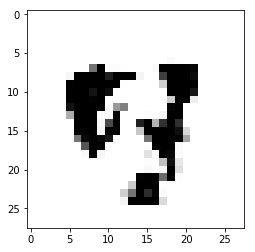

Estimate: [[ 14.32191753]]
Iteration: 29200 at 2017-06-30 18:08:28.771527


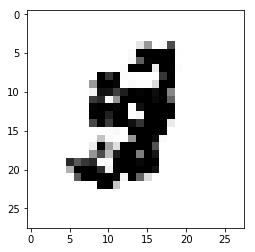

Estimate: [[-6.07110167]]
Iteration: 29300 at 2017-06-30 18:08:35.852789


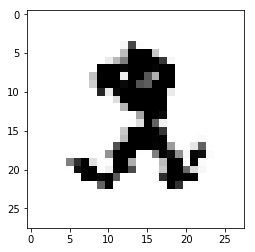

Estimate: [[-4.44757223]]
Iteration: 29400 at 2017-06-30 18:08:43.021636


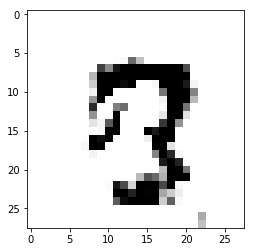

Estimate: [[ 5.96713018]]
Iteration: 29500 at 2017-06-30 18:08:50.107405


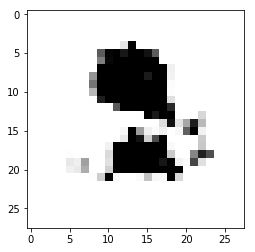

Estimate: [[-11.12629986]]
Iteration: 29600 at 2017-06-30 18:08:57.220697


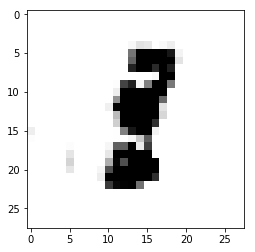

Estimate: [[ 11.70751858]]
Iteration: 29700 at 2017-06-30 18:09:04.328985


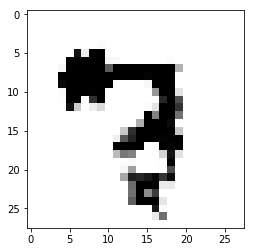

Estimate: [[-3.19657922]]
Iteration: 29800 at 2017-06-30 18:09:11.420757


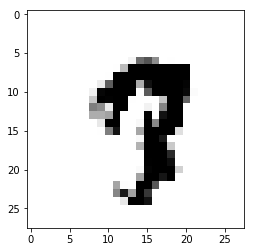

Estimate: [[ 4.72223091]]
Iteration: 29900 at 2017-06-30 18:09:18.551566


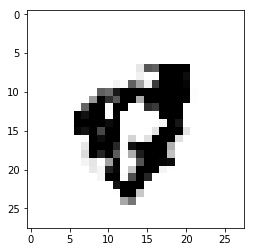

Estimate: [[-0.87148112]]
Iteration: 30000 at 2017-06-30 18:09:25.658853


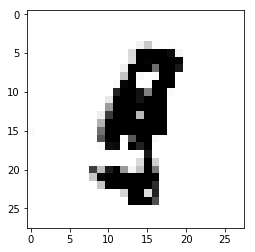

Estimate: [[ 5.15128469]]
Iteration: 30100 at 2017-06-30 18:09:32.752126


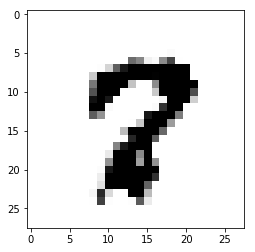

Estimate: [[-12.77209949]]
Iteration: 30200 at 2017-06-30 18:09:39.885441


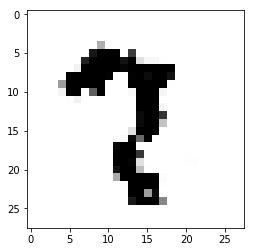

Estimate: [[ 3.12123036]]
Iteration: 30300 at 2017-06-30 18:09:47.064295


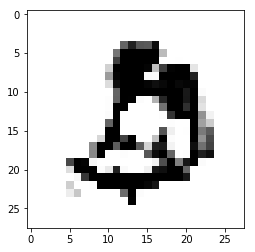

Estimate: [[ 19.94916344]]
Iteration: 30400 at 2017-06-30 18:09:54.188098


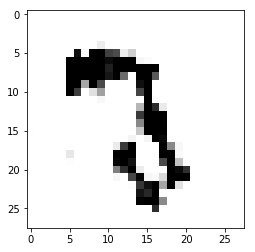

Estimate: [[-26.49154663]]
Iteration: 30500 at 2017-06-30 18:10:01.383971


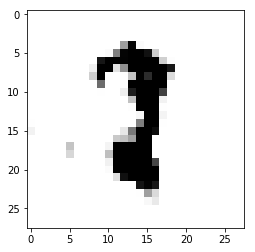

Estimate: [[ 16.07559776]]
Iteration: 30600 at 2017-06-30 18:10:08.496264


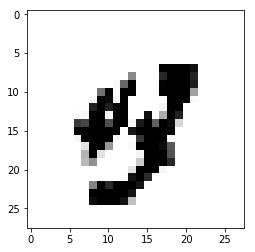

Estimate: [[ 8.96095085]]
Iteration: 30700 at 2017-06-30 18:10:15.611058


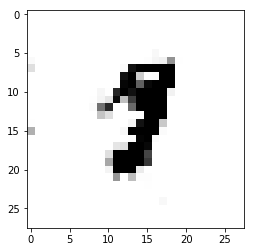

Estimate: [[ 14.91318417]]
Iteration: 30800 at 2017-06-30 18:10:22.744370


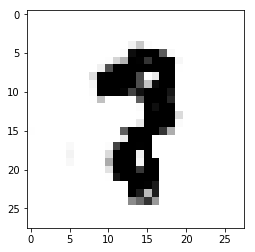

Estimate: [[ 7.58604908]]
Iteration: 30900 at 2017-06-30 18:10:30.178969


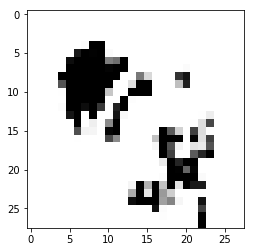

Estimate: [[-2.64797831]]
Iteration: 31000 at 2017-06-30 18:10:37.320289


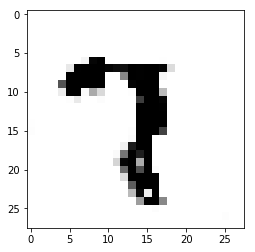

Estimate: [[-8.92662525]]
Iteration: 31100 at 2017-06-30 18:10:44.476622


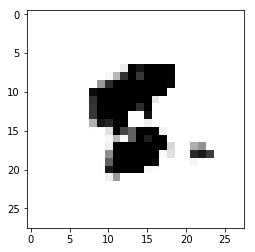

Estimate: [[ 7.79297733]]
Iteration: 31200 at 2017-06-30 18:10:51.633957


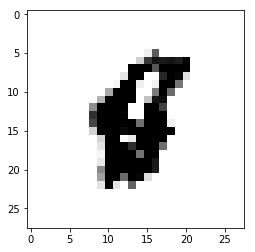

Estimate: [[ 24.73169327]]
Iteration: 31300 at 2017-06-30 18:10:58.837836


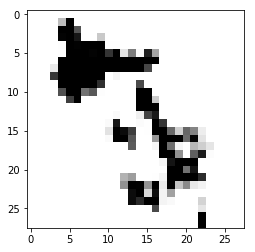

Estimate: [[-3.47953916]]
Iteration: 31400 at 2017-06-30 18:11:06.029203


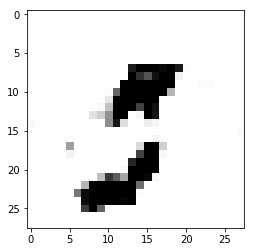

Estimate: [[ 15.68146229]]
Iteration: 31500 at 2017-06-30 18:11:13.186538


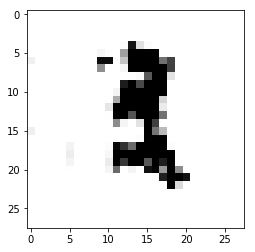

Estimate: [[-18.03674507]]
Iteration: 31600 at 2017-06-30 18:11:20.414440


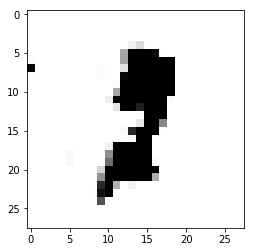

Estimate: [[ 6.75252485]]
Iteration: 31700 at 2017-06-30 18:11:27.581784


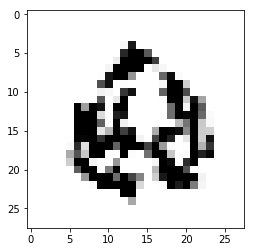

Estimate: [[-30.5460701]]
Iteration: 31800 at 2017-06-30 18:11:34.761144


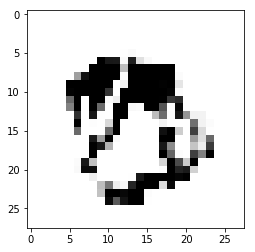

Estimate: [[-1.76239455]]
Iteration: 31900 at 2017-06-30 18:11:42.004563


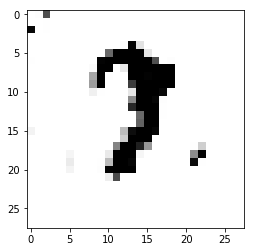

Estimate: [[ 17.22704506]]
Iteration: 32000 at 2017-06-30 18:11:49.222454


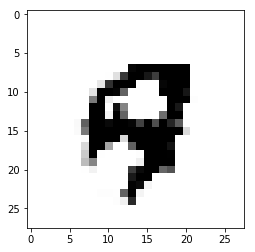

Estimate: [[ 4.7100544]]
Iteration: 32100 at 2017-06-30 18:11:56.385794


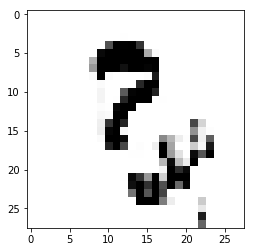

Estimate: [[ 16.86076736]]
Iteration: 32200 at 2017-06-30 18:12:03.583167


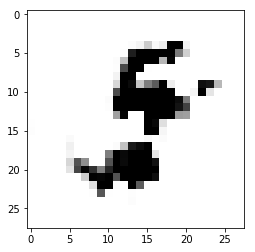

Estimate: [[-10.4832449]]
Iteration: 32300 at 2017-06-30 18:12:10.791550


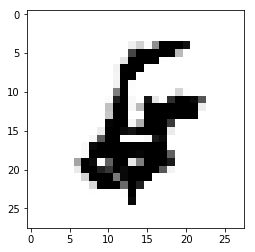

Estimate: [[ 7.53355932]]
Iteration: 32400 at 2017-06-30 18:12:18.957348


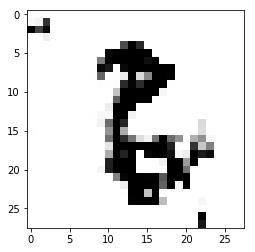

Estimate: [[-9.07101822]]
Iteration: 32500 at 2017-06-30 18:12:26.189254


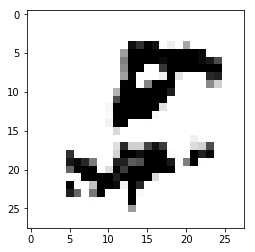

Estimate: [[ 60.50764084]]
Iteration: 32600 at 2017-06-30 18:12:33.412151


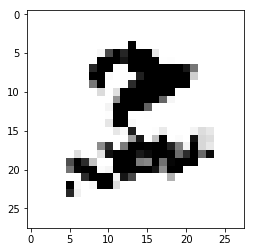

Estimate: [[ 21.83426094]]
Iteration: 32700 at 2017-06-30 18:12:40.723633


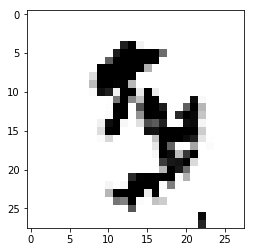

Estimate: [[ 6.56906462]]
Iteration: 32800 at 2017-06-30 18:12:48.007088


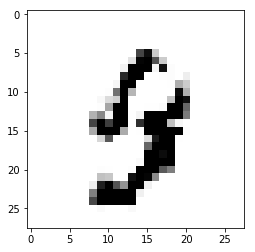

Estimate: [[-0.86234671]]
Iteration: 32900 at 2017-06-30 18:12:55.245000


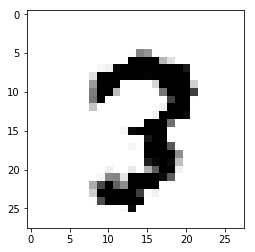

Estimate: [[-18.70022011]]
Iteration: 33000 at 2017-06-30 18:13:02.502430


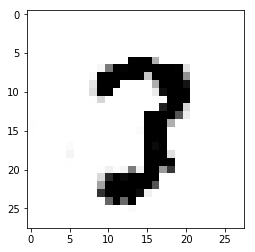

Estimate: [[-1.28473222]]
Iteration: 33100 at 2017-06-30 18:13:09.776876


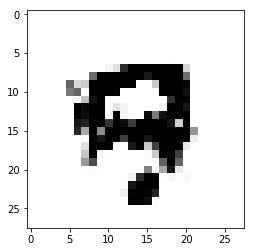

Estimate: [[ 19.09230423]]
Iteration: 33200 at 2017-06-30 18:13:17.079850


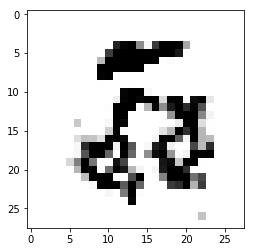

Estimate: [[ 1.22598314]]
Iteration: 33300 at 2017-06-30 18:13:24.349292


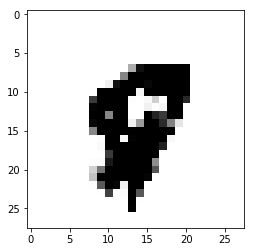

Estimate: [[ 18.35531998]]
Iteration: 33400 at 2017-06-30 18:13:31.623738


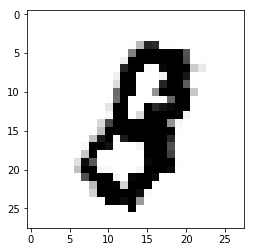

Estimate: [[ 1.38742697]]
Iteration: 33500 at 2017-06-30 18:13:38.908194


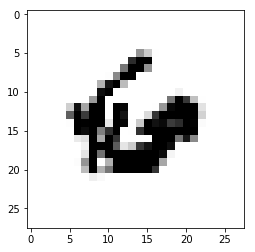

Estimate: [[ 19.68098068]]
Iteration: 33600 at 2017-06-30 18:13:46.203160


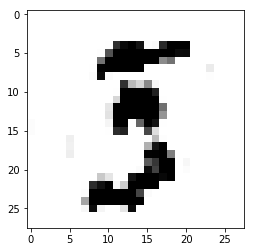

Estimate: [[ 9.78790379]]
Iteration: 33700 at 2017-06-30 18:13:53.485174


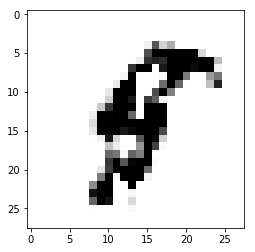

Estimate: [[ 13.89864922]]
Iteration: 33800 at 2017-06-30 18:14:00.825126


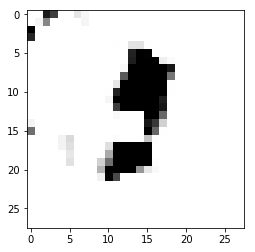

Estimate: [[-6.71593046]]
Iteration: 33900 at 2017-06-30 18:14:08.123596


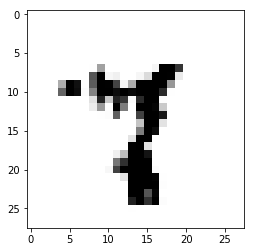

Estimate: [[-24.12824059]]
Iteration: 34000 at 2017-06-30 18:14:15.430073


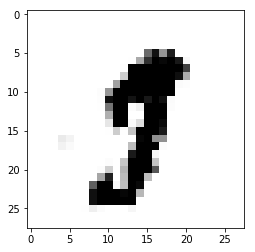

Estimate: [[ 13.12817192]]
Iteration: 34100 at 2017-06-30 18:14:22.731547


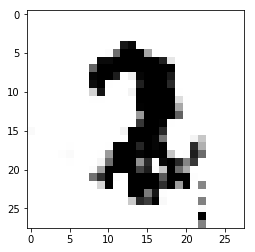

Estimate: [[ 16.12980652]]
Iteration: 34200 at 2017-06-30 18:14:30.067052


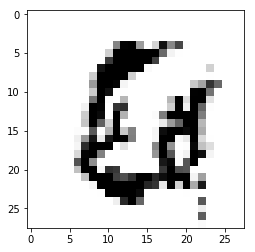

Estimate: [[ 18.80517197]]
Iteration: 34300 at 2017-06-30 18:14:37.421573


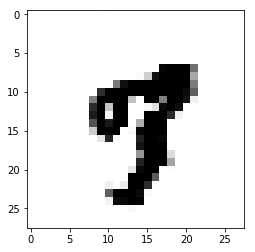

Estimate: [[ 24.52389717]]
Iteration: 34400 at 2017-06-30 18:14:44.744066


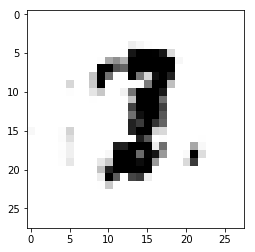

Estimate: [[-30.67046928]]
Iteration: 34500 at 2017-06-30 18:14:52.080574


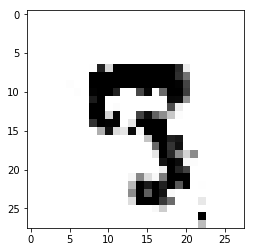

Estimate: [[-4.83551979]]
Iteration: 34600 at 2017-06-30 18:14:59.411074


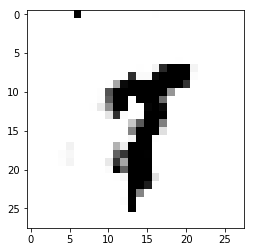

Estimate: [[ 0.90428936]]
Iteration: 34700 at 2017-06-30 18:15:06.747580


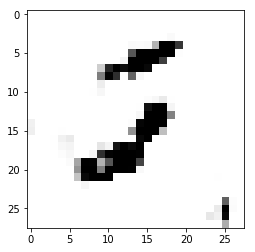

Estimate: [[ 22.48090935]]
Iteration: 34800 at 2017-06-30 18:15:14.136636


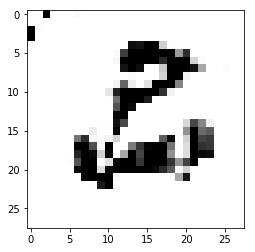

Estimate: [[ 2.06748676]]
Iteration: 34900 at 2017-06-30 18:15:21.573738


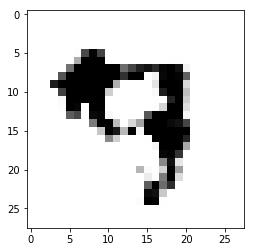

Estimate: [[ 41.41447449]]
Iteration: 35000 at 2017-06-30 18:15:28.960792


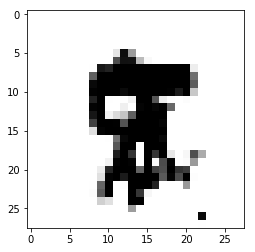

Estimate: [[-39.31794357]]
Iteration: 35100 at 2017-06-30 18:15:36.324824


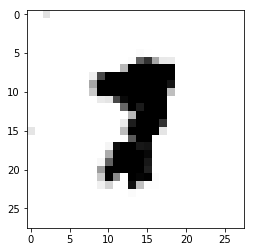

Estimate: [[ 10.21903515]]
Iteration: 35200 at 2017-06-30 18:15:43.696864


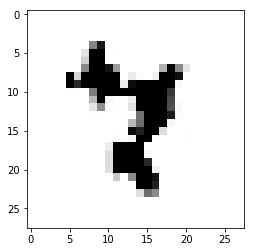

Estimate: [[ 2.69058776]]
Iteration: 35300 at 2017-06-30 18:15:51.058393


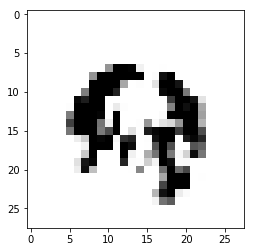

Estimate: [[-16.12665176]]
Iteration: 35400 at 2017-06-30 18:15:58.425427


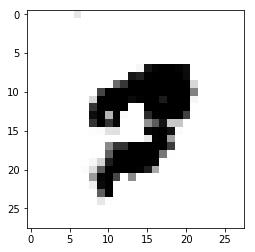

Estimate: [[ 21.02018356]]
Iteration: 35500 at 2017-06-30 18:16:05.806476


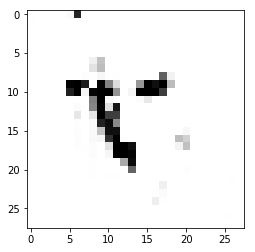

Estimate: [[-27.43478966]]
Iteration: 35600 at 2017-06-30 18:16:13.188027


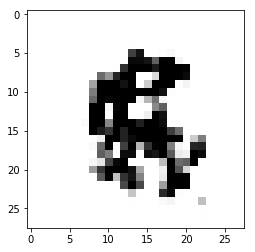

Estimate: [[-9.99435425]]
Iteration: 35700 at 2017-06-30 18:16:20.565572


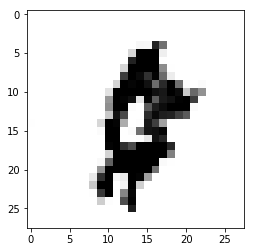

Estimate: [[-38.24544525]]
Iteration: 35800 at 2017-06-30 18:16:27.927601


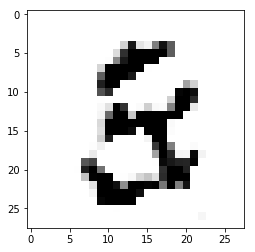

Estimate: [[ 11.79770184]]
Iteration: 35900 at 2017-06-30 18:16:35.313655


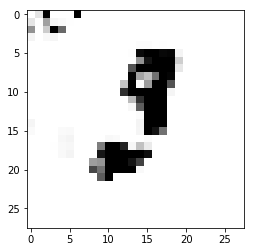

Estimate: [[-22.81467247]]
Iteration: 36000 at 2017-06-30 18:16:42.757763


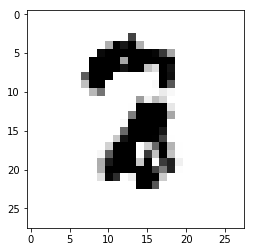

Estimate: [[ 13.96250629]]
Iteration: 36100 at 2017-06-30 18:16:50.133306


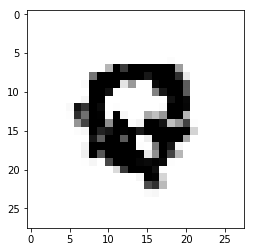

Estimate: [[-2.98709464]]
Iteration: 36200 at 2017-06-30 18:16:57.499840


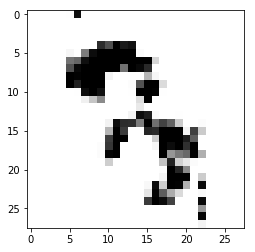

Estimate: [[-26.69955444]]
Iteration: 36300 at 2017-06-30 18:17:04.893901


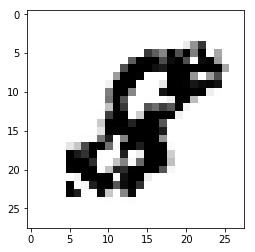

Estimate: [[-10.06966877]]
Iteration: 36400 at 2017-06-30 18:17:12.288462


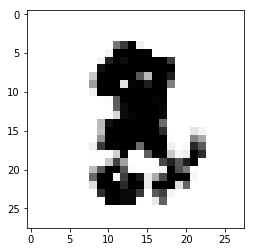

Estimate: [[ 16.8055172]]
Iteration: 36500 at 2017-06-30 18:17:19.676517


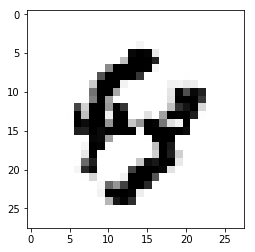

Estimate: [[-4.39792109]]
Iteration: 36600 at 2017-06-30 18:17:27.111117


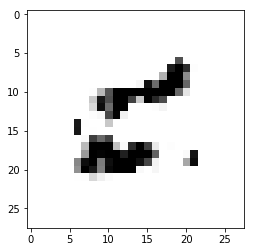

Estimate: [[ 8.30898094]]
Iteration: 36700 at 2017-06-30 18:17:34.504680


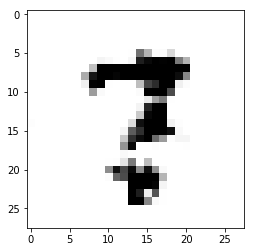

Estimate: [[-25.63374138]]
Iteration: 36800 at 2017-06-30 18:17:41.958298


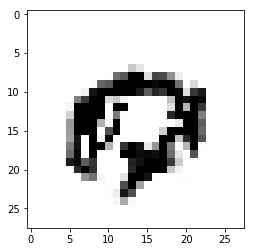

Estimate: [[-9.49319077]]
Iteration: 36900 at 2017-06-30 18:17:49.372378


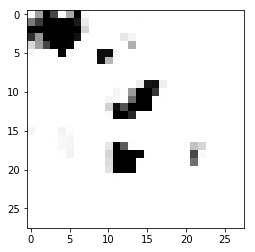

Estimate: [[ 120.57975006]]
Iteration: 37000 at 2017-06-30 18:17:56.811982


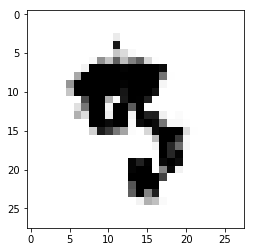

Estimate: [[-27.43605423]]
Iteration: 37100 at 2017-06-30 18:18:04.314646


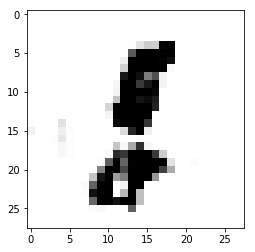

Estimate: [[ 2.82542038]]
Iteration: 37200 at 2017-06-30 18:18:11.730728


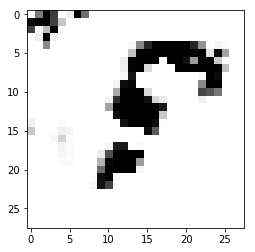

Estimate: [[ 16.13777161]]
Iteration: 37300 at 2017-06-30 18:18:19.172334


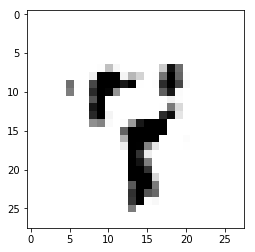

Estimate: [[ 25.31422234]]
Iteration: 37400 at 2017-06-30 18:18:26.611438


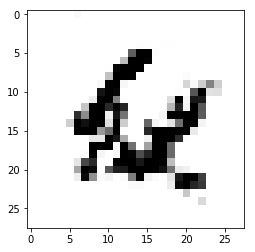

Estimate: [[-1.54010952]]
Iteration: 37500 at 2017-06-30 18:18:34.077568


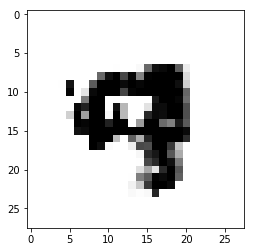

Estimate: [[-10.12214565]]
Iteration: 37600 at 2017-06-30 18:18:41.530685


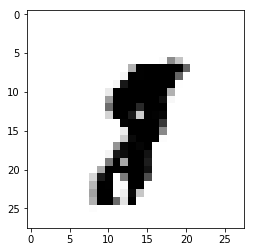

Estimate: [[ 36.49526978]]
Iteration: 37700 at 2017-06-30 18:18:49.015335


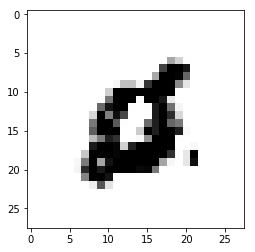

Estimate: [[ 22.72009468]]
Iteration: 37800 at 2017-06-30 18:18:56.466450


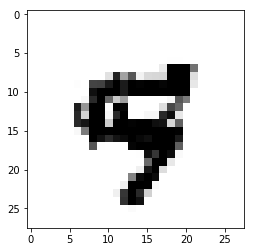

Estimate: [[ 3.77300596]]
Iteration: 37900 at 2017-06-30 18:19:03.940587


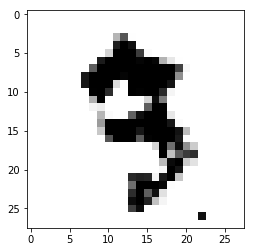

Estimate: [[ 5.2161684]]
Iteration: 38000 at 2017-06-30 18:19:11.393704


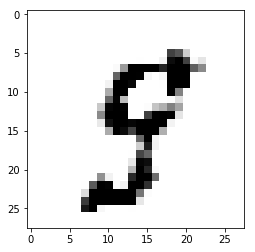

Estimate: [[ 30.6757946]]
Iteration: 38100 at 2017-06-30 18:19:18.897370


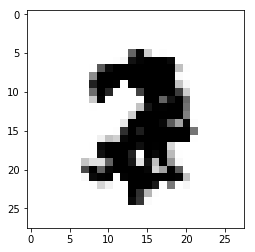

Estimate: [[ 9.910882]]
Iteration: 38200 at 2017-06-30 18:19:26.442074


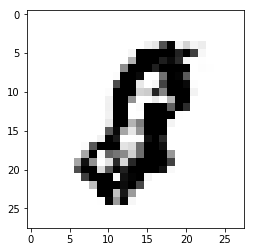

Estimate: [[ 19.97073174]]
Iteration: 38300 at 2017-06-30 18:19:33.918213


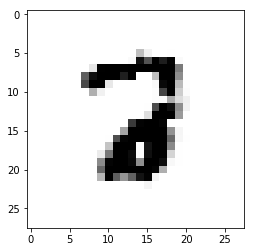

Estimate: [[-5.46419954]]
Iteration: 38400 at 2017-06-30 18:19:42.440351


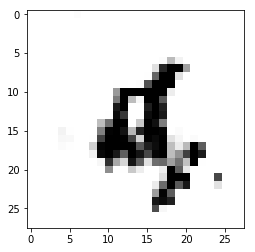

Estimate: [[ 20.60693932]]
Iteration: 38500 at 2017-06-30 18:19:49.969541


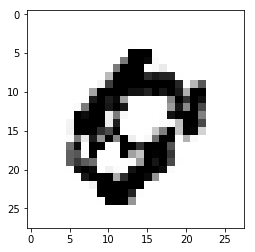

Estimate: [[ 8.47107124]]
Iteration: 38600 at 2017-06-30 18:19:57.477210


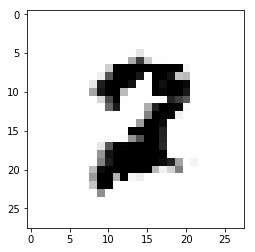

Estimate: [[-21.51719475]]
Iteration: 38700 at 2017-06-30 18:20:05.009901


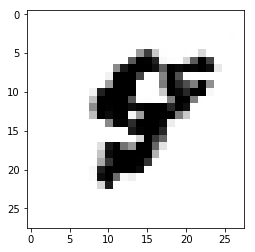

Estimate: [[ 30.47120094]]
Iteration: 38800 at 2017-06-30 18:20:12.515068


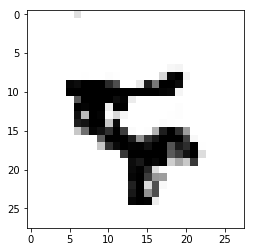

Estimate: [[-2.9911747]]
Iteration: 38900 at 2017-06-30 18:20:20.046263


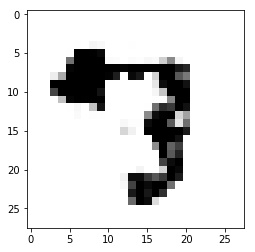

Estimate: [[ 47.18002319]]
Iteration: 39000 at 2017-06-30 18:20:27.587464


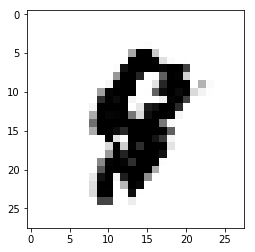

Estimate: [[-28.80552101]]
Iteration: 39100 at 2017-06-30 18:20:35.124161


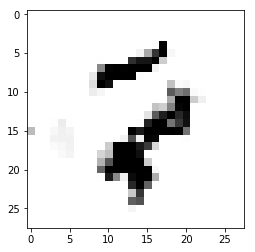

Estimate: [[-2.77164602]]
Iteration: 39200 at 2017-06-30 18:20:42.674871


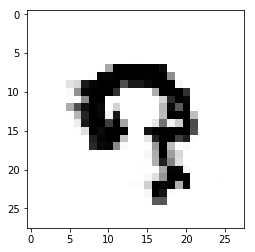

Estimate: [[ 10.70050049]]
Iteration: 39300 at 2017-06-30 18:20:50.285639


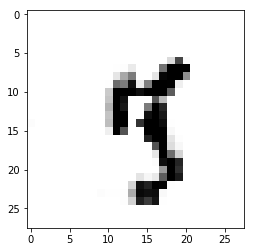

Estimate: [[-5.39539909]]
Iteration: 39400 at 2017-06-30 18:20:57.821835


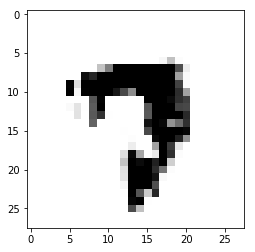

Estimate: [[ 19.53639603]]
Iteration: 39500 at 2017-06-30 18:21:05.363537


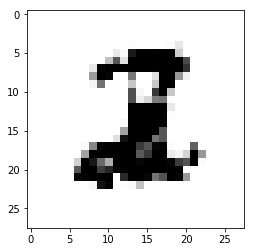

Estimate: [[ 25.24338531]]
Iteration: 39600 at 2017-06-30 18:21:12.933266


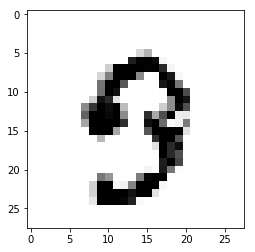

Estimate: [[ 50.66221237]]
Iteration: 39700 at 2017-06-30 18:21:20.507498


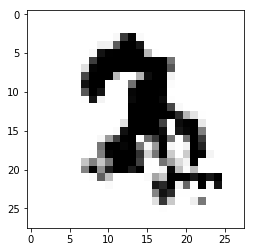

Estimate: [[ 52.69986725]]
Iteration: 39800 at 2017-06-30 18:21:28.085234


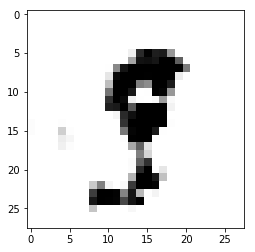

Estimate: [[-6.9173193]]
Iteration: 39900 at 2017-06-30 18:21:35.653962


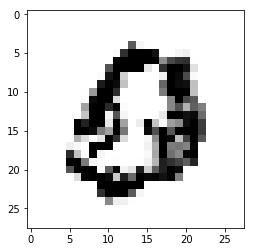

Estimate: [[-7.46532583]]
Iteration: 40000 at 2017-06-30 18:21:43.242708


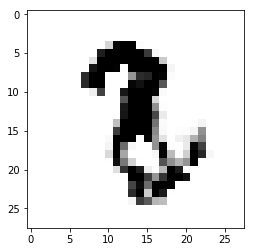

Estimate: [[ 24.13965797]]
Iteration: 40100 at 2017-06-30 18:21:50.813438


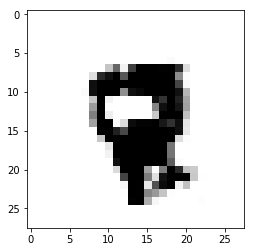

Estimate: [[ 23.73635674]]
Iteration: 40200 at 2017-06-30 18:21:58.399181


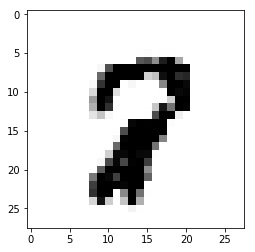

Estimate: [[-7.95931387]]
Iteration: 40300 at 2017-06-30 18:22:05.998939


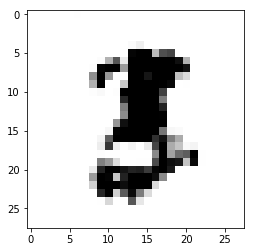

Estimate: [[-28.22338104]]
Iteration: 40400 at 2017-06-30 18:22:13.673767


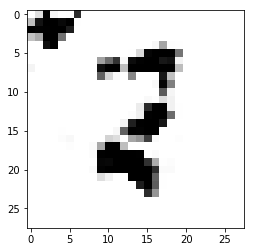

Estimate: [[ 14.73801613]]
Iteration: 40500 at 2017-06-30 18:22:21.251003


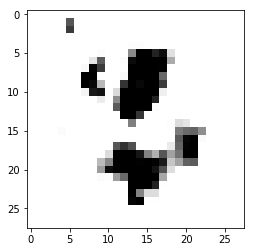

Estimate: [[ 9.53278446]]
Iteration: 40600 at 2017-06-30 18:22:28.875784


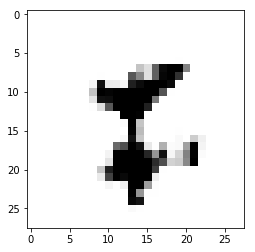

Estimate: [[-11.83015156]]
Iteration: 40700 at 2017-06-30 18:22:36.463530


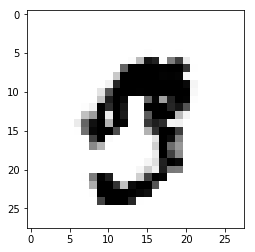

Estimate: [[ 24.17041206]]
Iteration: 40800 at 2017-06-30 18:22:44.076800


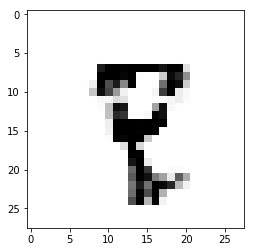

Estimate: [[ 7.87436485]]
Iteration: 40900 at 2017-06-30 18:22:51.676557


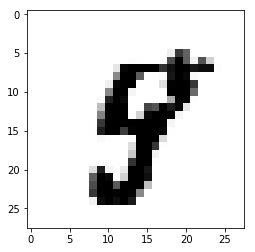

Estimate: [[ 30.77923775]]
Iteration: 41000 at 2017-06-30 18:22:59.275315


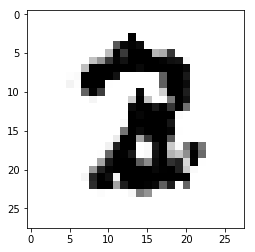

Estimate: [[ 12.11785126]]
Iteration: 41100 at 2017-06-30 18:23:06.900096


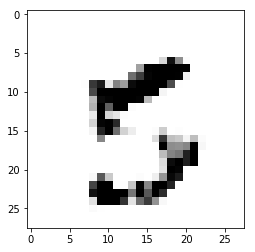

Estimate: [[-9.3361063]]
Iteration: 41200 at 2017-06-30 18:23:14.521374


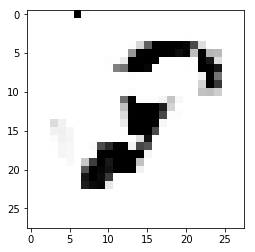

Estimate: [[-2.47979927]]
Iteration: 41300 at 2017-06-30 18:23:22.134644


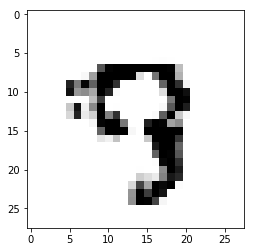

Estimate: [[ 0.11708512]]
Iteration: 41400 at 2017-06-30 18:23:29.764429


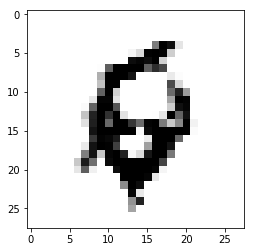

Estimate: [[-6.89525795]]
Iteration: 41500 at 2017-06-30 18:23:37.448767


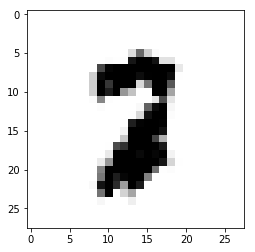

Estimate: [[-1.20353878]]
Iteration: 41600 at 2017-06-30 18:23:45.099576


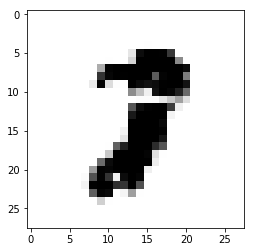

Estimate: [[ 81.24362183]]
Iteration: 41700 at 2017-06-30 18:23:52.721354


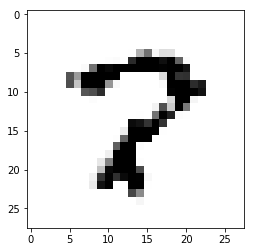

Estimate: [[ 28.71677971]]
Iteration: 41800 at 2017-06-30 18:24:00.367656


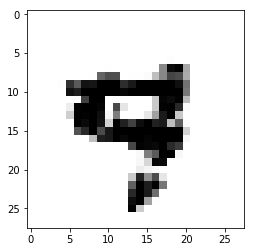

Estimate: [[ 8.99170399]]
Iteration: 41900 at 2017-06-30 18:24:08.000447


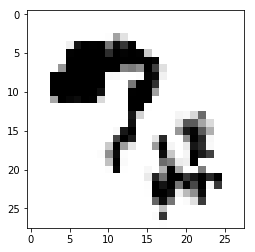

Estimate: [[ 19.54356194]]
Iteration: 42000 at 2017-06-30 18:24:15.652755


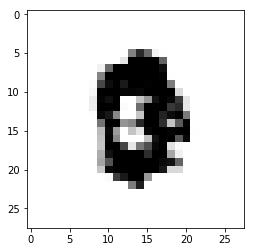

Estimate: [[-19.33292198]]
Iteration: 42100 at 2017-06-30 18:24:23.308065


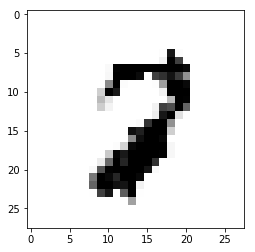

Estimate: [[ 45.61433792]]
Iteration: 42200 at 2017-06-30 18:24:30.964876


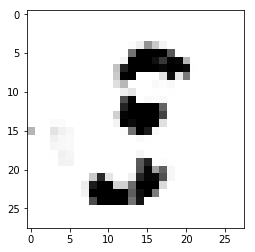

Estimate: [[-11.31111336]]
Iteration: 42300 at 2017-06-30 18:24:38.674238


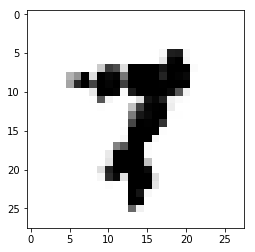

Estimate: [[ 5.07123756]]
Iteration: 42400 at 2017-06-30 18:24:46.357075


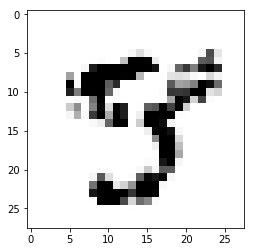

Estimate: [[ 0.24288134]]
Iteration: 42500 at 2017-06-30 18:24:54.064434


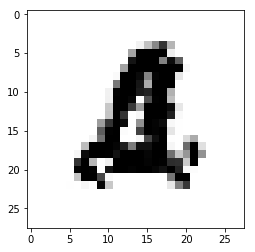

Estimate: [[ 20.85085678]]
Iteration: 42600 at 2017-06-30 18:25:01.836856


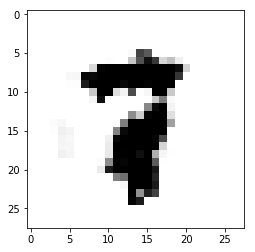

Estimate: [[-25.66917992]]
Iteration: 42700 at 2017-06-30 18:25:09.529702


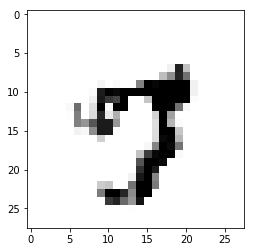

Estimate: [[ 6.87335634]]
Iteration: 42800 at 2017-06-30 18:25:17.240566


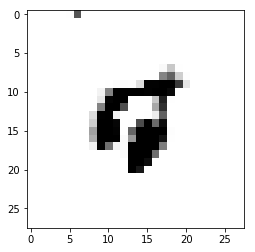

Estimate: [[ 8.04726601]]
Iteration: 42900 at 2017-06-30 18:25:24.941419


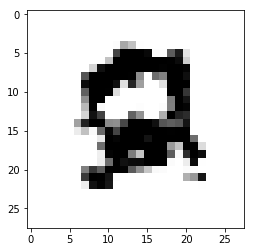

Estimate: [[-17.89718056]]
Iteration: 43000 at 2017-06-30 18:25:32.626258


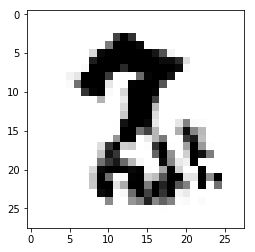

Estimate: [[-6.73783493]]
Iteration: 43100 at 2017-06-30 18:25:40.328612


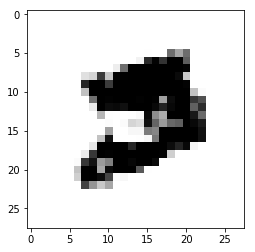

Estimate: [[ 4.27021837]]
Iteration: 43200 at 2017-06-30 18:25:48.070005


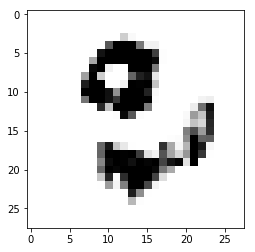

Estimate: [[ 4.61860514]]
Iteration: 43300 at 2017-06-30 18:25:55.827412


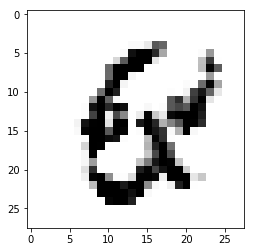

Estimate: [[ 14.26816368]]
Iteration: 43400 at 2017-06-30 18:26:03.524262


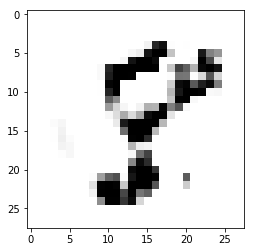

Estimate: [[ 4.96330643]]
Iteration: 43500 at 2017-06-30 18:26:11.250640


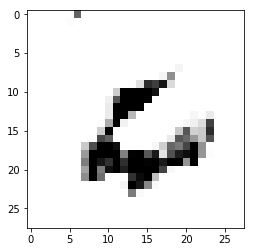

Estimate: [[ 40.93886948]]
Iteration: 43600 at 2017-06-30 18:26:18.981523


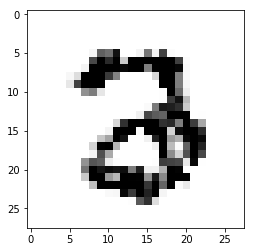

Estimate: [[ 9.40612221]]
Iteration: 43700 at 2017-06-30 18:26:26.783475


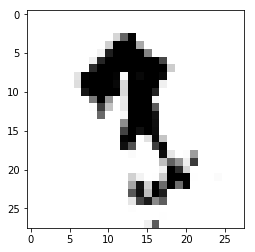

Estimate: [[-16.67131042]]
Iteration: 43800 at 2017-06-30 18:26:34.513857


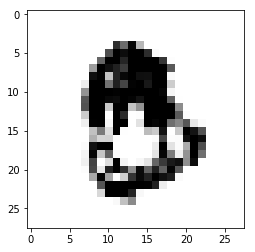

Estimate: [[ 3.91029]]
Iteration: 43900 at 2017-06-30 18:26:42.391880


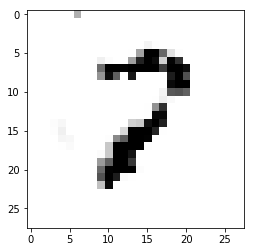

Estimate: [[ 83.08996582]]
Iteration: 44000 at 2017-06-30 18:26:50.209345


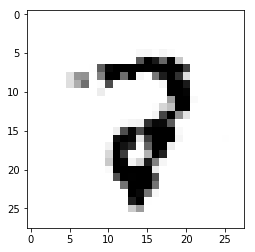

Estimate: [[ 5.6908288]]
Iteration: 44100 at 2017-06-30 18:26:57.966252


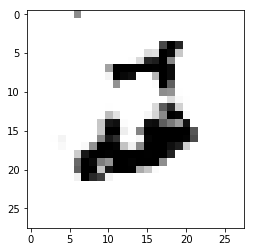

Estimate: [[ 12.15135288]]
Iteration: 44200 at 2017-06-30 18:27:05.726162


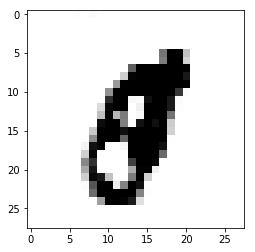

Estimate: [[-5.5427928]]
Iteration: 44300 at 2017-06-30 18:27:13.484070


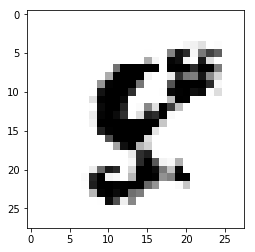

Estimate: [[ 2.66052485]]
Iteration: 44400 at 2017-06-30 18:27:21.245482


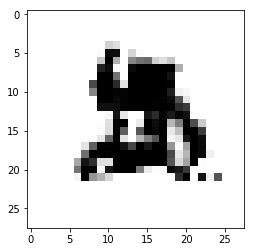

Estimate: [[-36.69734573]]
Iteration: 44500 at 2017-06-30 18:27:29.018904


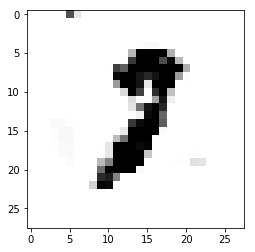

Estimate: [[ 1.32469523]]
Iteration: 44600 at 2017-06-30 18:27:36.769305


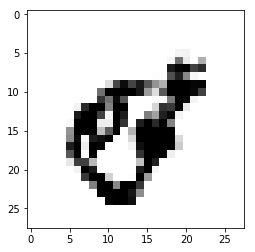

Estimate: [[-12.34651089]]
Iteration: 44700 at 2017-06-30 18:27:44.540226


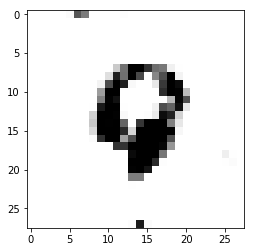

Estimate: [[ 0.79779541]]
Iteration: 44800 at 2017-06-30 18:27:52.391724


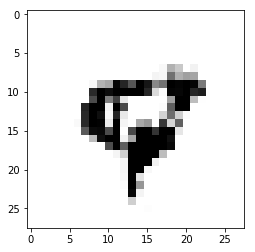

Estimate: [[ 12.56878853]]
Iteration: 44900 at 2017-06-30 18:28:00.186167


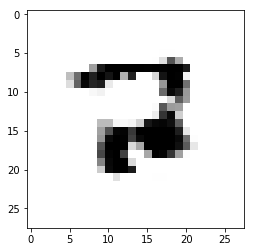

Estimate: [[ 22.87540627]]
Iteration: 45000 at 2017-06-30 18:28:07.976105


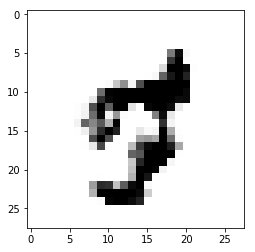

Estimate: [[ 7.74208736]]
Iteration: 45100 at 2017-06-30 18:28:15.763041


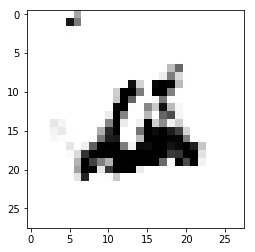

Estimate: [[ 8.56299496]]
Iteration: 45200 at 2017-06-30 18:28:23.546974


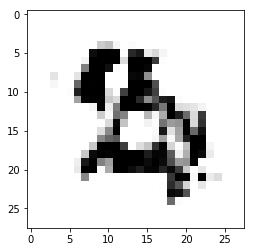

Estimate: [[ 9.58283424]]
Iteration: 45300 at 2017-06-30 18:28:31.322399


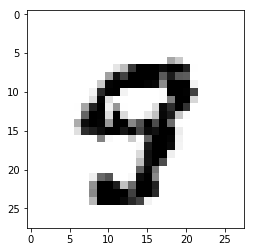

Estimate: [[ 3.48356986]]
Iteration: 45400 at 2017-06-30 18:28:40.337508


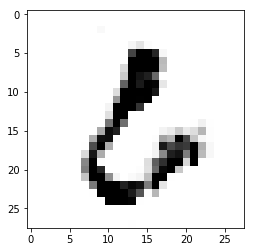

Estimate: [[ 26.14742279]]
Iteration: 45500 at 2017-06-30 18:28:48.220534


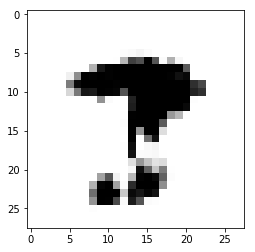

Estimate: [[ 33.70174026]]
Iteration: 45600 at 2017-06-30 18:28:56.060521


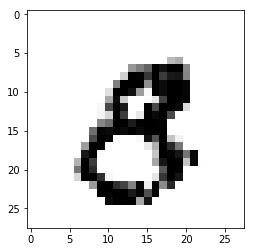

Estimate: [[-1.71772408]]
Iteration: 45700 at 2017-06-30 18:29:03.929035


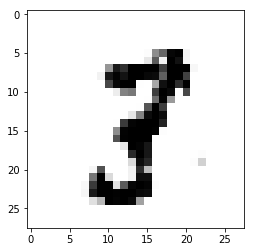

Estimate: [[-5.59445667]]
Iteration: 45800 at 2017-06-30 18:29:11.817567


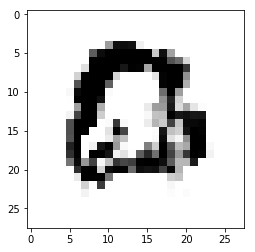

Estimate: [[-9.71474361]]
Iteration: 45900 at 2017-06-30 18:29:19.765657


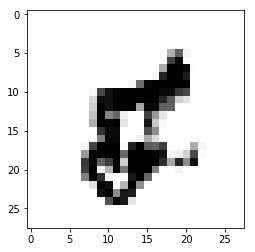

Estimate: [[ 41.2684288]]
Iteration: 46000 at 2017-06-30 18:29:27.627665


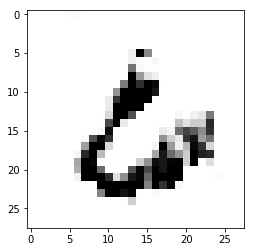

Estimate: [[ 42.74837875]]
Iteration: 46100 at 2017-06-30 18:29:35.503185


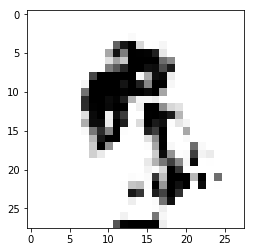

Estimate: [[-40.81997299]]
Iteration: 46200 at 2017-06-30 18:29:43.371199


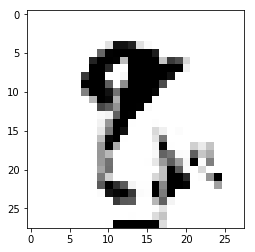

Estimate: [[-21.6909008]]
Iteration: 46300 at 2017-06-30 18:29:51.251724


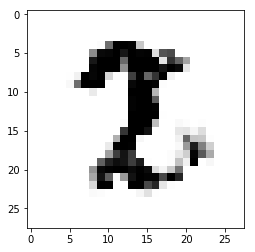

Estimate: [[ 2.17354512]]
Iteration: 46400 at 2017-06-30 18:29:59.140757


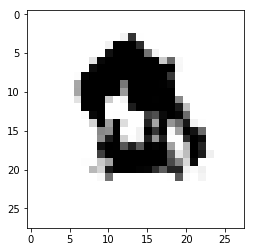

Estimate: [[-19.69439888]]
Iteration: 46500 at 2017-06-30 18:30:07.027287


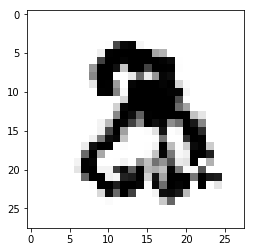

Estimate: [[ 7.58464336]]
Iteration: 46600 at 2017-06-30 18:30:14.909313


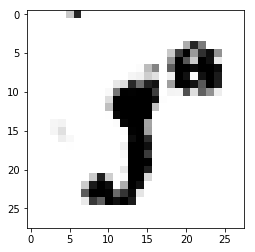

Estimate: [[ 22.26354599]]
Iteration: 46700 at 2017-06-30 18:30:22.802350


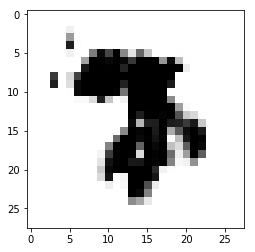

Estimate: [[ 40.89014816]]
Iteration: 46800 at 2017-06-30 18:30:30.684377


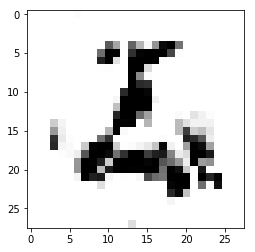

Estimate: [[-8.22041988]]
Iteration: 46900 at 2017-06-30 18:30:38.617452


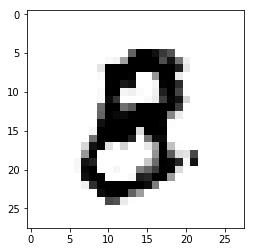

Estimate: [[ 13.3402071]]
Iteration: 47000 at 2017-06-30 18:30:46.598073


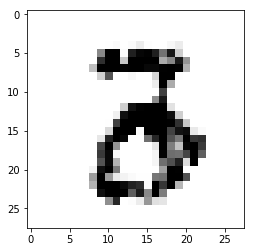

Estimate: [[-11.64098549]]
Iteration: 47100 at 2017-06-30 18:30:54.515634


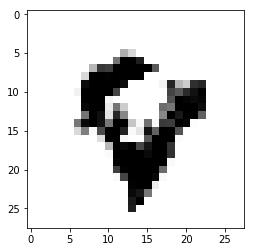

Estimate: [[ 10.8336544]]
Iteration: 47200 at 2017-06-30 18:31:02.423187


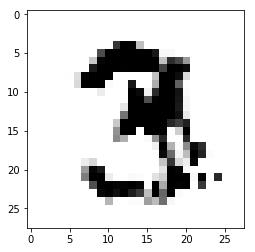

Estimate: [[ 0.78534192]]
Iteration: 47300 at 2017-06-30 18:31:10.324232


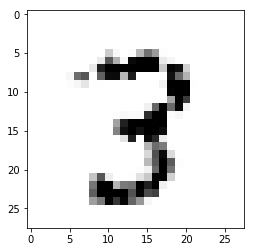

Estimate: [[ 4.56663322]]
Iteration: 47400 at 2017-06-30 18:31:18.275325


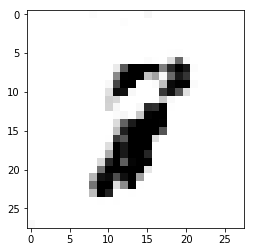

Estimate: [[ 28.0706768]]
Iteration: 47500 at 2017-06-30 18:31:26.186379


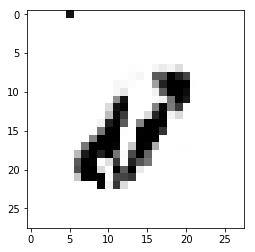

Estimate: [[ 4.3704071]]
Iteration: 47600 at 2017-06-30 18:31:34.097934


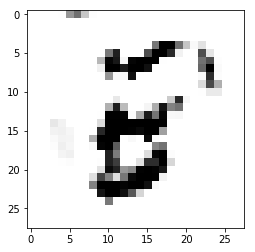

Estimate: [[-21.58217049]]
Iteration: 47700 at 2017-06-30 18:31:42.015999


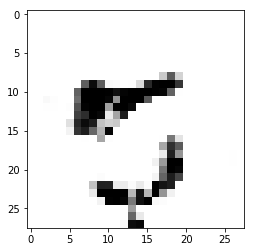

Estimate: [[-6.46981001]]
Iteration: 47800 at 2017-06-30 18:31:49.953079


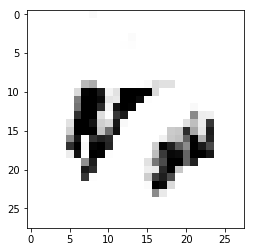

Estimate: [[ 9.17047977]]
Iteration: 47900 at 2017-06-30 18:31:57.846617


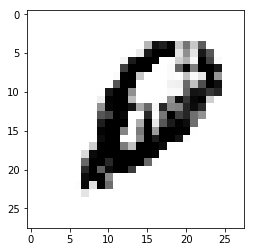

Estimate: [[ 23.69712067]]
Iteration: 48000 at 2017-06-30 18:32:05.769182


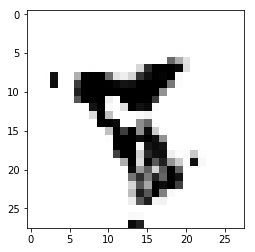

Estimate: [[ 16.79459953]]
Iteration: 48100 at 2017-06-30 18:32:13.766319


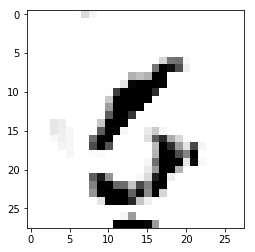

Estimate: [[-24.109478]]
Iteration: 48200 at 2017-06-30 18:32:21.721915


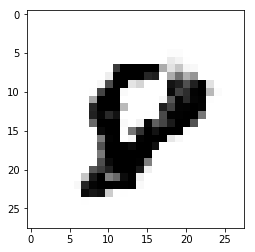

Estimate: [[ 3.86295366]]
Iteration: 48300 at 2017-06-30 18:32:29.654490


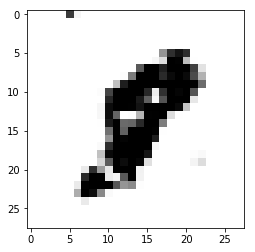

Estimate: [[-6.35508966]]
Iteration: 48400 at 2017-06-30 18:32:37.613090


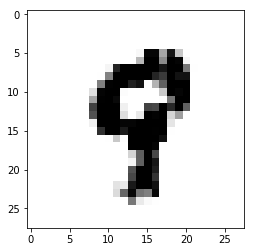

Estimate: [[ 0.91462433]]
Iteration: 48500 at 2017-06-30 18:32:45.544164


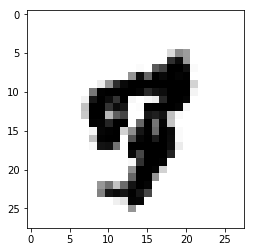

Estimate: [[-4.78136206]]
Iteration: 48600 at 2017-06-30 18:32:53.513774


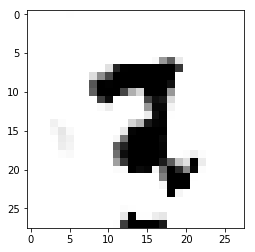

Estimate: [[ 14.28165054]]
Iteration: 48700 at 2017-06-30 18:33:01.459862


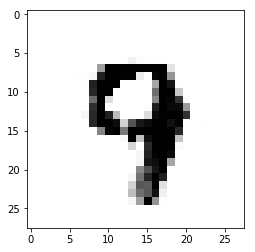

Estimate: [[ 15.45769787]]
Iteration: 48800 at 2017-06-30 18:33:09.423466


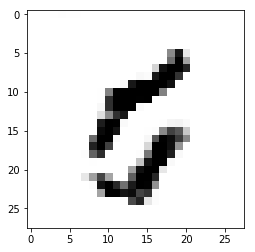

Estimate: [[ 11.84180355]]
Iteration: 48900 at 2017-06-30 18:33:17.402085


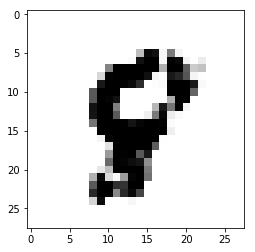

Estimate: [[ 20.42794228]]
Iteration: 49000 at 2017-06-30 18:33:25.358683


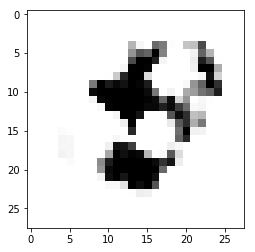

Estimate: [[-13.88628864]]
Iteration: 49100 at 2017-06-30 18:33:33.337302


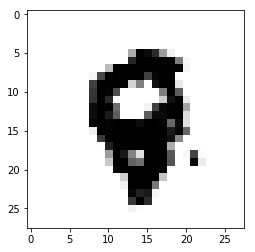

Estimate: [[-6.42549181]]
Iteration: 49200 at 2017-06-30 18:33:41.420020


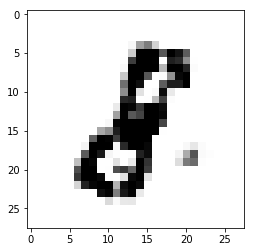

Estimate: [[-8.81350899]]
Iteration: 49300 at 2017-06-30 18:33:49.443181


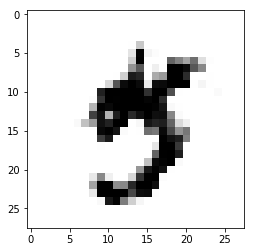

Estimate: [[ 4.88738155]]
Iteration: 49400 at 2017-06-30 18:33:57.409289


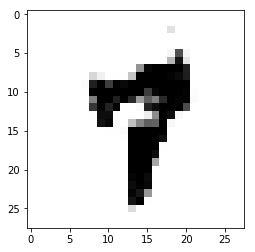

Estimate: [[ 6.57093239]]
Iteration: 49500 at 2017-06-30 18:34:05.407926


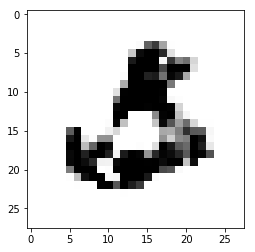

Estimate: [[ 18.47252846]]
Iteration: 49600 at 2017-06-30 18:34:13.417075


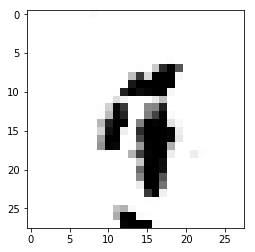

Estimate: [[ 4.09238625]]
Iteration: 49700 at 2017-06-30 18:34:21.421718


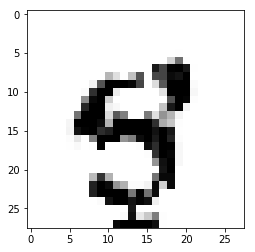

Estimate: [[ 19.02747154]]
Iteration: 49800 at 2017-06-30 18:34:29.435371


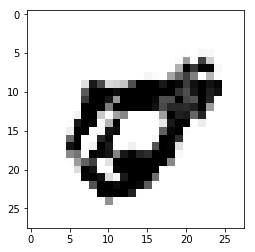

Estimate: [[ 2.92519712]]
Iteration: 49900 at 2017-06-30 18:34:37.467040


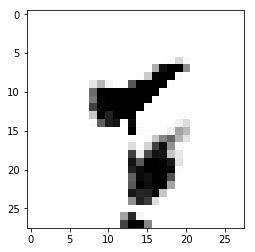

Estimate: [[ 4.28199196]]
Iteration: 50000 at 2017-06-30 18:34:45.499711


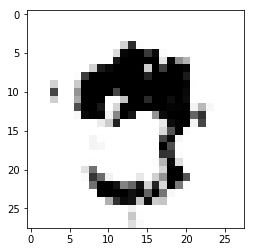

Estimate: [[-25.13490677]]
Iteration: 50100 at 2017-06-30 18:34:53.527877


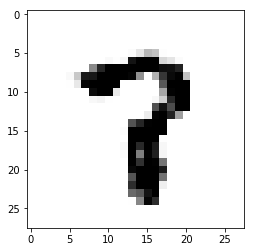

Estimate: [[ 3.60421324]]
Iteration: 50200 at 2017-06-30 18:35:01.552540


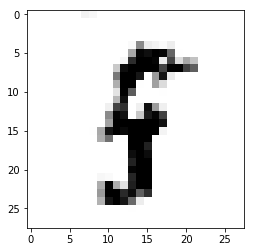

Estimate: [[-6.92682886]]
Iteration: 50300 at 2017-06-30 18:35:09.674796


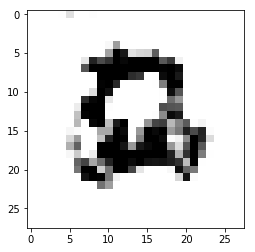

Estimate: [[-40.86851883]]
Iteration: 50400 at 2017-06-30 18:35:17.761518


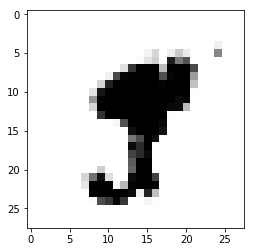

Estimate: [[ 17.97442436]]
Iteration: 50500 at 2017-06-30 18:35:25.799694


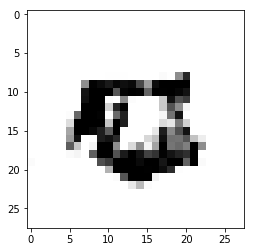

Estimate: [[ 1.21224177]]
Iteration: 50600 at 2017-06-30 18:35:33.846378


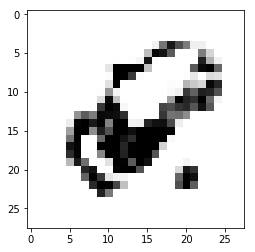

Estimate: [[ 17.63310242]]
Iteration: 50700 at 2017-06-30 18:35:41.908076


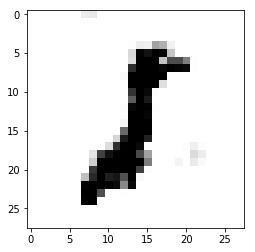

Estimate: [[ 34.54465485]]
Iteration: 50800 at 2017-06-30 18:35:49.989293


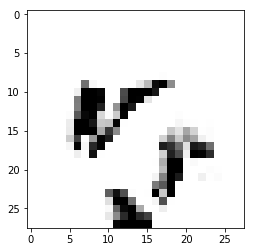

Estimate: [[-44.10135269]]
Iteration: 50900 at 2017-06-30 18:35:58.083526


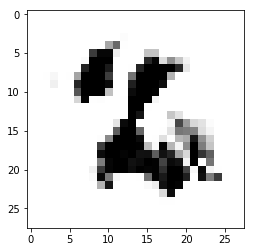

Estimate: [[ 1.92203462]]
Iteration: 51000 at 2017-06-30 18:36:06.148728


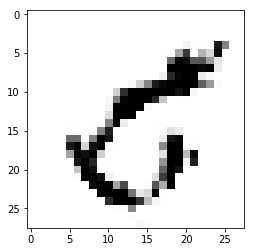

Estimate: [[ 7.97062445]]
Iteration: 51100 at 2017-06-30 18:36:14.224438


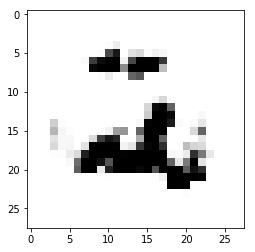

Estimate: [[ 39.72806549]]
Iteration: 51200 at 2017-06-30 18:36:22.282132


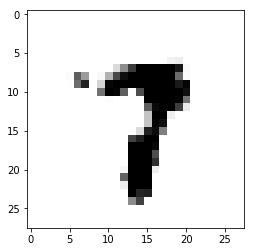

Estimate: [[ 14.58287334]]
Iteration: 51300 at 2017-06-30 18:36:30.360347


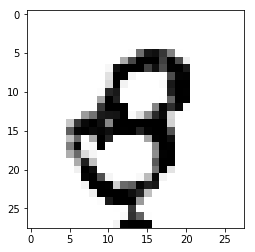

Estimate: [[ 9.766119]]
Iteration: 51400 at 2017-06-30 18:36:38.732341


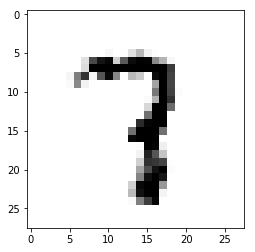

Estimate: [[-0.11350016]]
Iteration: 51500 at 2017-06-30 18:36:46.935675


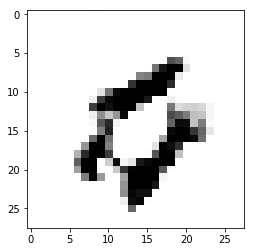

Estimate: [[-7.73541498]]
Iteration: 51600 at 2017-06-30 18:36:55.137006


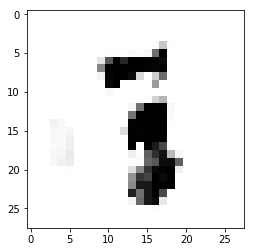

Estimate: [[-15.90098381]]
Iteration: 51700 at 2017-06-30 18:37:03.295297


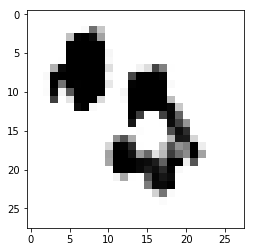

Estimate: [[ 13.86693764]]
Iteration: 51800 at 2017-06-30 18:37:11.402038


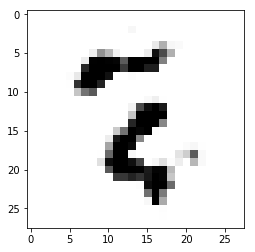

Estimate: [[-10.30370331]]
Iteration: 51900 at 2017-06-30 18:37:19.545314


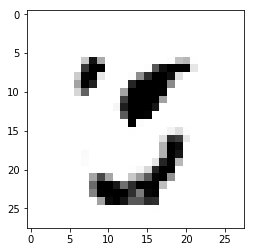

Estimate: [[-5.97154093]]
Iteration: 52000 at 2017-06-30 18:37:27.790687


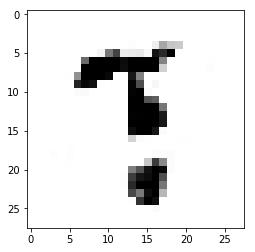

Estimate: [[ 7.33457279]]
Iteration: 52100 at 2017-06-30 18:37:35.953983


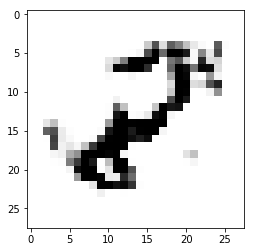

Estimate: [[-6.23676872]]
Iteration: 52200 at 2017-06-30 18:37:44.103765


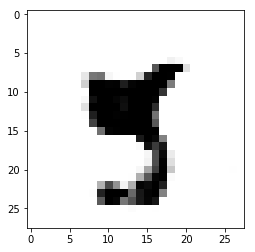

Estimate: [[-21.89851761]]
Iteration: 52300 at 2017-06-30 18:37:52.259052


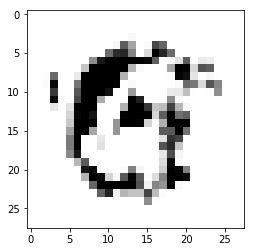

Estimate: [[-1.41873074]]
Iteration: 52400 at 2017-06-30 18:38:00.399326


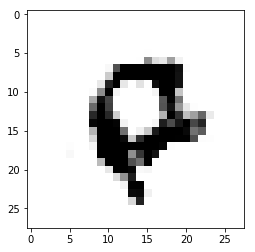

Estimate: [[ 4.25419044]]
Iteration: 52500 at 2017-06-30 18:38:08.614170


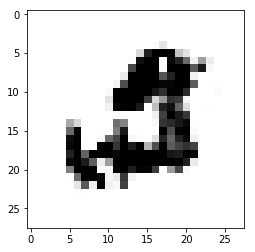

Estimate: [[ 49.24580383]]
Iteration: 52600 at 2017-06-30 18:38:16.793981


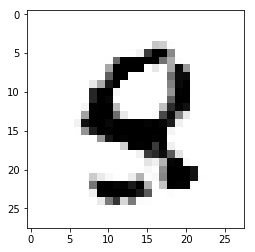

Estimate: [[ 20.70135307]]
Iteration: 52700 at 2017-06-30 18:38:24.967286


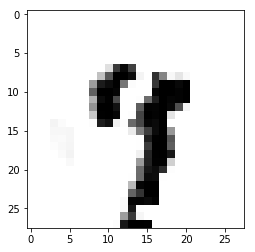

Estimate: [[ 1.98011887]]
Iteration: 52800 at 2017-06-30 18:38:33.145595


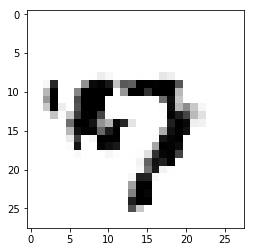

Estimate: [[ 16.71915817]]
Iteration: 52900 at 2017-06-30 18:38:41.294377


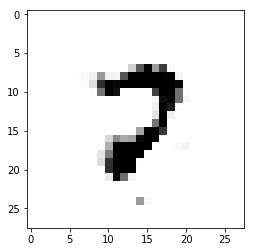

Estimate: [[-13.86378956]]
Iteration: 53000 at 2017-06-30 18:38:49.461676


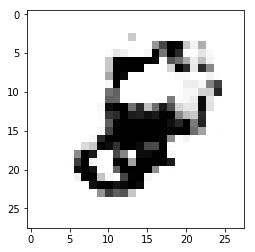

Estimate: [[-28.5624752]]
Iteration: 53100 at 2017-06-30 18:38:57.629476


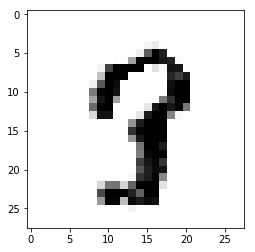

Estimate: [[-0.01000545]]
Iteration: 53200 at 2017-06-30 18:39:05.864840


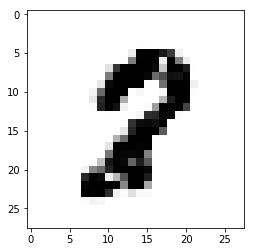

Estimate: [[-8.6832428]]
Iteration: 53300 at 2017-06-30 18:39:14.075180


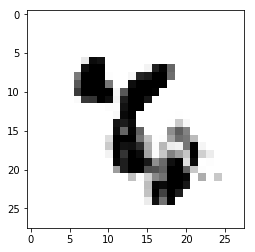

Estimate: [[ 21.90671158]]
Iteration: 53400 at 2017-06-30 18:39:22.296030


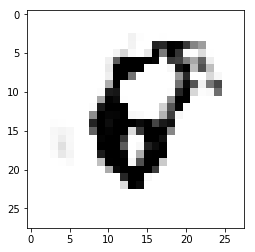

Estimate: [[ 12.1659584]]
Iteration: 53500 at 2017-06-30 18:39:31.895197


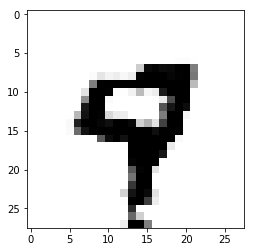

Estimate: [[ 55.52075958]]
Iteration: 53600 at 2017-06-30 18:39:40.259183


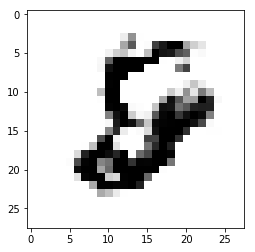

Estimate: [[ 12.92189312]]
Iteration: 53700 at 2017-06-30 18:39:48.557107


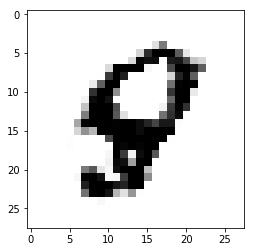

Estimate: [[-2.75586963]]
Iteration: 53800 at 2017-06-30 18:39:56.862040


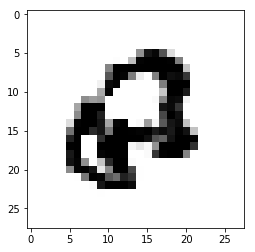

Estimate: [[ 34.76858521]]
Iteration: 53900 at 2017-06-30 18:40:05.144949


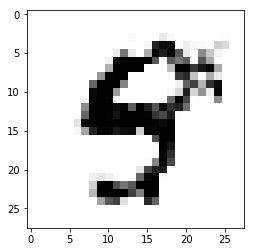

Estimate: [[ 17.06685829]]
Iteration: 54000 at 2017-06-30 18:40:13.414346


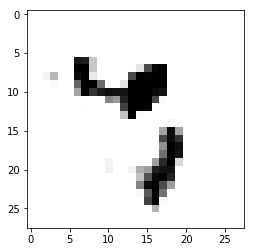

Estimate: [[ 0.2136714]]
Iteration: 54100 at 2017-06-30 18:40:21.685744


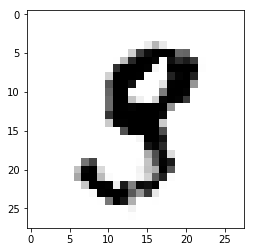

Estimate: [[-1.87146282]]
Iteration: 54200 at 2017-06-30 18:40:29.992677


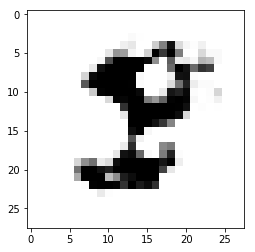

Estimate: [[-28.2986393]]
Iteration: 54300 at 2017-06-30 18:40:38.381687


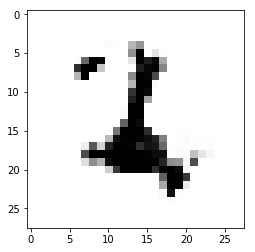

Estimate: [[ 34.59101105]]
Iteration: 54400 at 2017-06-30 18:40:46.697128


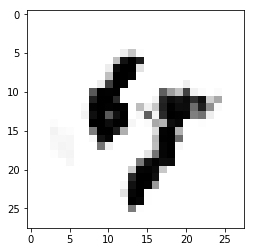

Estimate: [[-4.43628645]]
Iteration: 54500 at 2017-06-30 18:40:55.032087


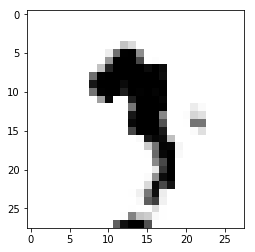

Estimate: [[ 19.36112595]]
Iteration: 54600 at 2017-06-30 18:41:03.353033


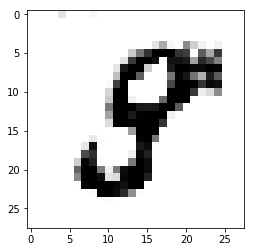

Estimate: [[ 27.23807335]]
Iteration: 54700 at 2017-06-30 18:41:11.737039


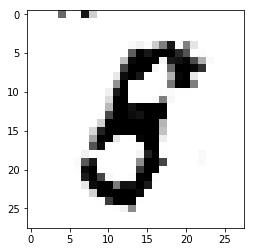

Estimate: [[-2.08116841]]
Iteration: 54800 at 2017-06-30 18:41:20.074501


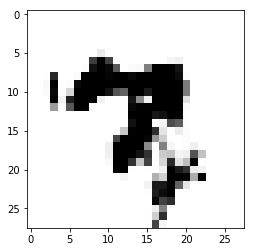

Estimate: [[-30.19916725]]
Iteration: 54900 at 2017-06-30 18:41:28.392444


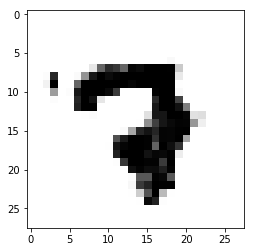

Estimate: [[ 21.00577354]]
Iteration: 55000 at 2017-06-30 18:41:36.732405


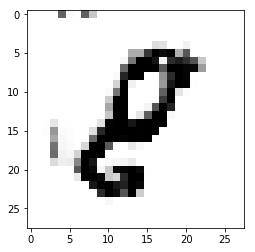

Estimate: [[ 12.67978001]]
Iteration: 55100 at 2017-06-30 18:41:45.536324


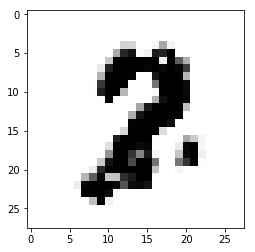

Estimate: [[ 1.84549868]]
Iteration: 55200 at 2017-06-30 18:41:53.888800


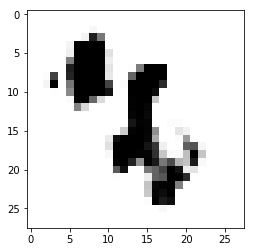

Estimate: [[-3.46835661]]
Iteration: 55300 at 2017-06-30 18:42:02.215751


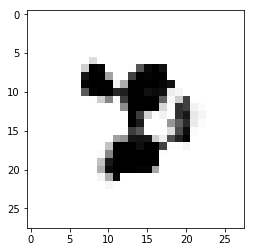

Estimate: [[-10.32686901]]
Iteration: 55400 at 2017-06-30 18:42:10.575234


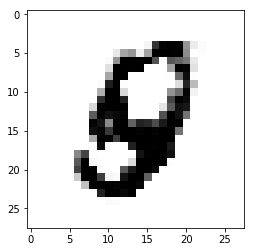

Estimate: [[ 12.82661819]]
Iteration: 55500 at 2017-06-30 18:42:18.941223


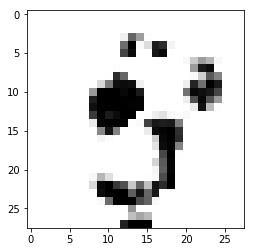

Estimate: [[-1.3541801]]
Iteration: 55600 at 2017-06-30 18:42:27.343246


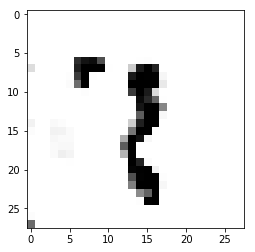

Estimate: [[-1.26482248]]
Iteration: 55700 at 2017-06-30 18:42:35.727252


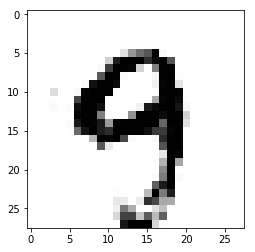

Estimate: [[ 28.86424828]]
Iteration: 55800 at 2017-06-30 18:42:44.158803


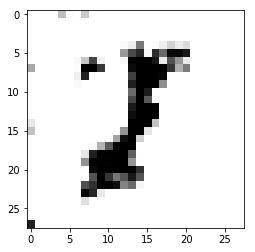

Estimate: [[-11.79530811]]
Iteration: 55900 at 2017-06-30 18:42:52.507275


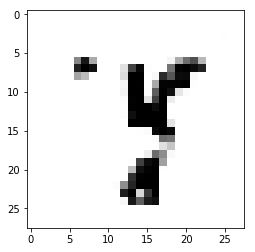

Estimate: [[-0.81715107]]
Iteration: 56000 at 2017-06-30 18:43:00.886777


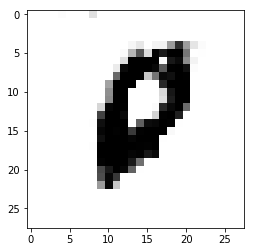

Estimate: [[ 17.22783089]]
Iteration: 56100 at 2017-06-30 18:43:09.249763


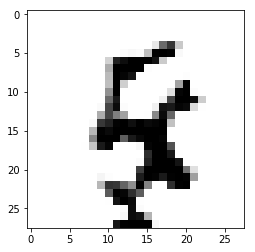

Estimate: [[-8.59746838]]
Iteration: 56200 at 2017-06-30 18:43:17.659293


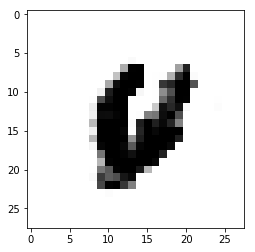

Estimate: [[ 19.55927277]]
Iteration: 56300 at 2017-06-30 18:43:26.060816


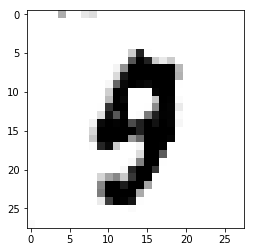

Estimate: [[ 40.2762413]]
Iteration: 56400 at 2017-06-30 18:43:34.459336


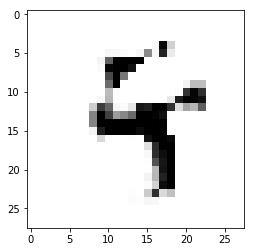

Estimate: [[ 63.27806473]]
Iteration: 56500 at 2017-06-30 18:43:42.849348


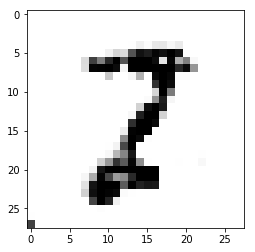

Estimate: [[ 17.59464836]]
Iteration: 56600 at 2017-06-30 18:43:51.250870


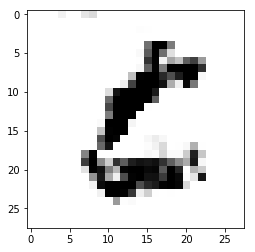

Estimate: [[ 80.22498322]]
Iteration: 56700 at 2017-06-30 18:43:59.661902


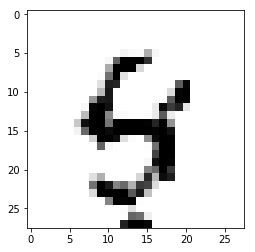

Estimate: [[ 5.41629601]]
Iteration: 56800 at 2017-06-30 18:44:08.077942


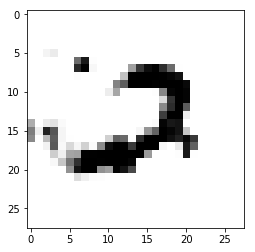

Estimate: [[ 48.89929199]]
Iteration: 56900 at 2017-06-30 18:44:16.571052


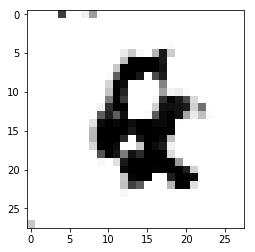

Estimate: [[-0.53850311]]
Iteration: 57000 at 2017-06-30 18:44:24.979081


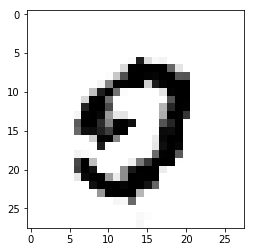

Estimate: [[-11.91129589]]
Iteration: 57100 at 2017-06-30 18:44:33.430654


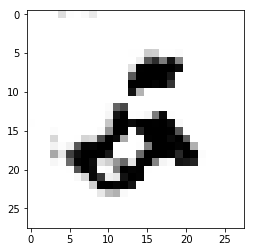

Estimate: [[-7.03856134]]
Iteration: 57200 at 2017-06-30 18:44:41.863707


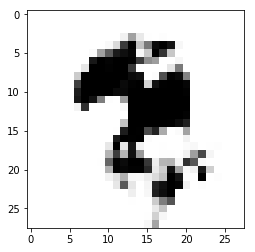

Estimate: [[-4.78942919]]
Iteration: 57300 at 2017-06-30 18:44:50.291258


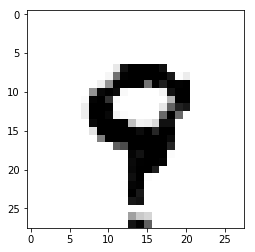

Estimate: [[ 27.32196808]]
Iteration: 57400 at 2017-06-30 18:44:58.738324


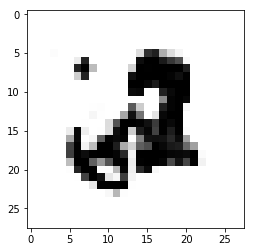

Estimate: [[-5.49447918]]
Iteration: 57500 at 2017-06-30 18:45:07.179884


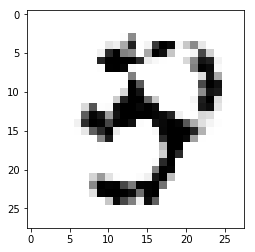

Estimate: [[ 21.67263222]]
Iteration: 57600 at 2017-06-30 18:45:15.627451


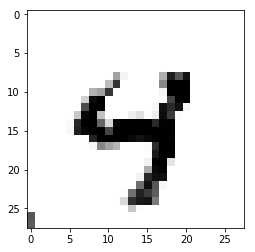

Estimate: [[ 38.45096207]]
Iteration: 57700 at 2017-06-30 18:45:24.095037


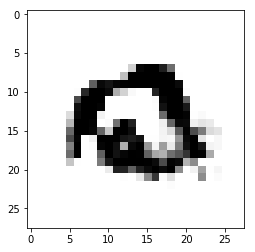

Estimate: [[-2.61022997]]
Iteration: 57800 at 2017-06-30 18:45:32.555116


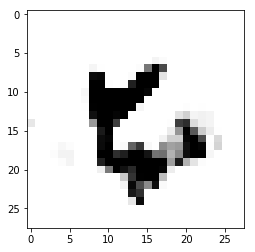

Estimate: [[ 22.45722961]]
Iteration: 57900 at 2017-06-30 18:45:40.996677


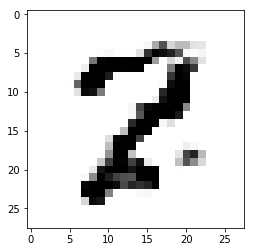

Estimate: [[ 20.45689964]]
Iteration: 58000 at 2017-06-30 18:45:49.577371


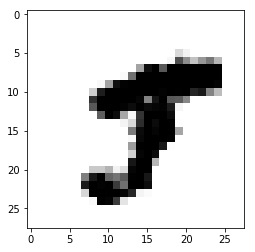

Estimate: [[ 45.15656281]]
Iteration: 58100 at 2017-06-30 18:45:58.058970


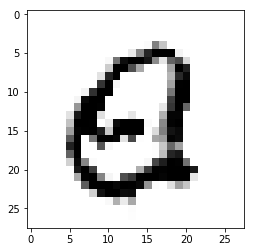

Estimate: [[-19.45887566]]
Iteration: 58200 at 2017-06-30 18:46:06.576103


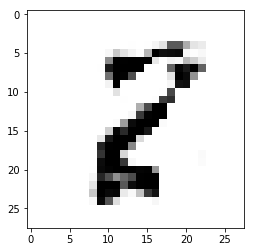

Estimate: [[ 27.41752243]]
Iteration: 58300 at 2017-06-30 18:46:15.226864


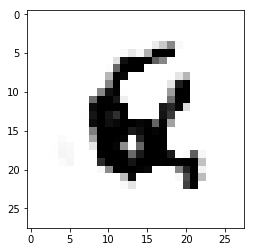

Estimate: [[ 18.28614235]]
Iteration: 58400 at 2017-06-30 18:46:23.720475


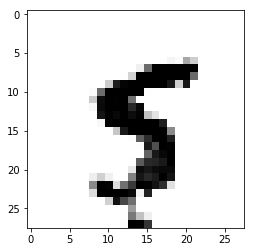

Estimate: [[ 27.11702538]]
Iteration: 58500 at 2017-06-30 18:46:32.195067


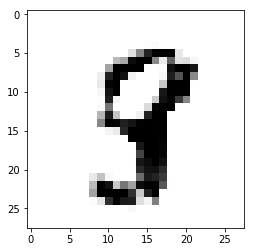

Estimate: [[ 6.71265173]]
Iteration: 58600 at 2017-06-30 18:46:40.725215


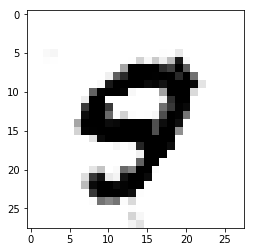

Estimate: [[ 42.14089966]]
Iteration: 58700 at 2017-06-30 18:46:49.211318


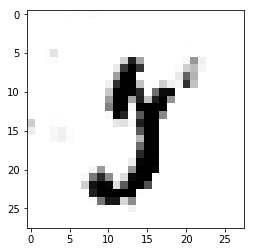

Estimate: [[ 17.07792854]]
Iteration: 58800 at 2017-06-30 18:46:57.676402


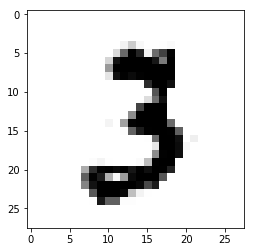

Estimate: [[-16.38384056]]
Iteration: 58900 at 2017-06-30 18:47:06.185557


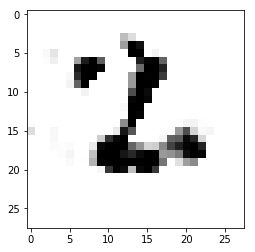

Estimate: [[ 14.36161041]]
Iteration: 59000 at 2017-06-30 18:47:14.653113


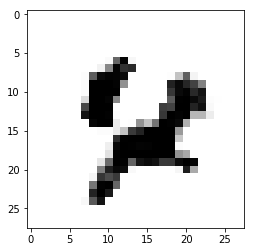

Estimate: [[ 12.26318169]]
Iteration: 59100 at 2017-06-30 18:47:23.098678


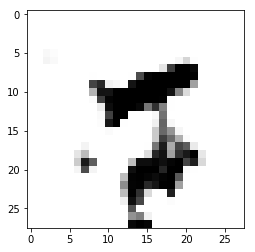

Estimate: [[ 18.80171585]]
Iteration: 59200 at 2017-06-30 18:47:31.578275


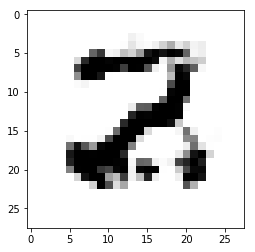

Estimate: [[-14.96430779]]
Iteration: 59300 at 2017-06-30 18:47:39.942869


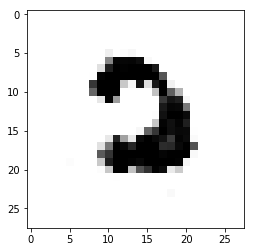

Estimate: [[ 19.76151085]]
Iteration: 59400 at 2017-06-30 18:47:48.307878


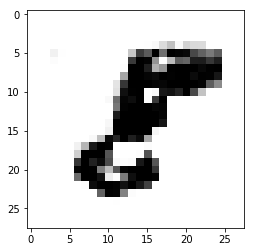

Estimate: [[ 26.15467644]]
Iteration: 59500 at 2017-06-30 18:47:56.661421


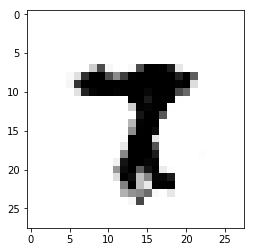

Estimate: [[ 17.51713943]]
Iteration: 59600 at 2017-06-30 18:48:05.054357


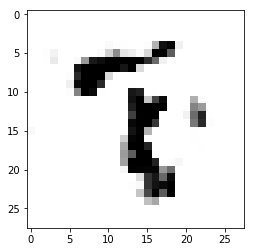

Estimate: [[-0.4012548]]
Iteration: 59700 at 2017-06-30 18:48:13.438577


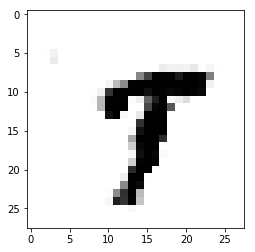

Estimate: [[ 23.07483864]]
Iteration: 59800 at 2017-06-30 18:48:21.856537


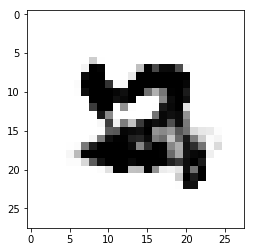

Estimate: [[-38.64227295]]
Iteration: 59900 at 2017-06-30 18:48:30.257129


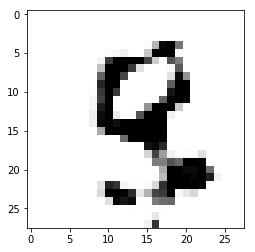

Estimate: [[ 10.61593914]]
Iteration: 60000 at 2017-06-30 18:48:38.774214


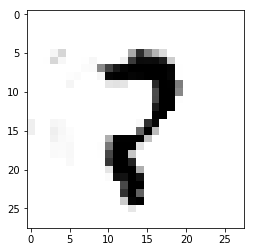

Estimate: [[ 1.8871628]]
Iteration: 60100 at 2017-06-30 18:48:47.177801


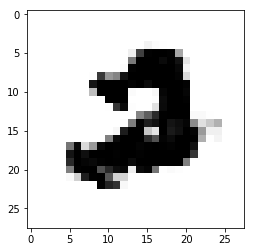

Estimate: [[ 38.14995956]]
Iteration: 60200 at 2017-06-30 18:48:55.686794


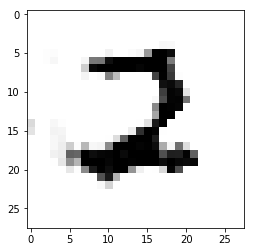

Estimate: [[ 33.16873169]]
Iteration: 60300 at 2017-06-30 18:49:04.105159


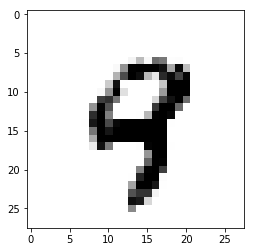

Estimate: [[-11.4724865]]
Iteration: 60400 at 2017-06-30 18:49:12.574857


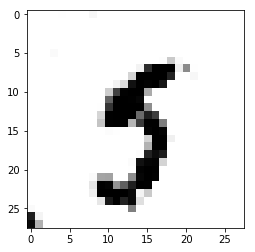

Estimate: [[ 2.79209757]]
Iteration: 60500 at 2017-06-30 18:49:21.052556


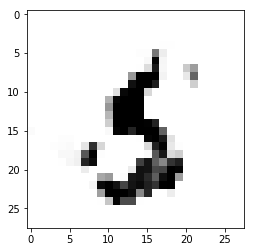

Estimate: [[-33.02790833]]
Iteration: 60600 at 2017-06-30 18:49:29.468034


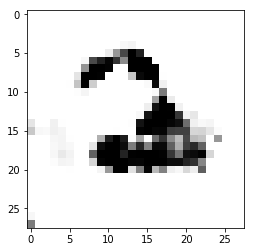

Estimate: [[ 7.76635313]]
Iteration: 60700 at 2017-06-30 18:49:37.911715


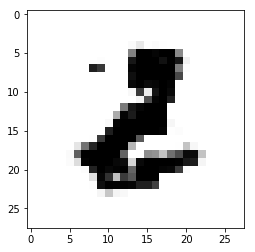

Estimate: [[-0.37422812]]
Iteration: 60800 at 2017-06-30 18:49:46.326457


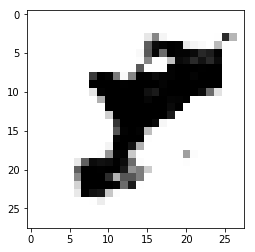

Estimate: [[ 1.03368056]]
Iteration: 60900 at 2017-06-30 18:49:54.850345


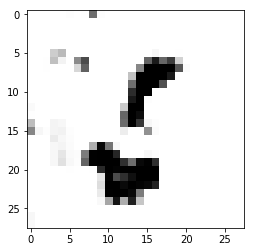

Estimate: [[-5.93322611]]
Iteration: 61000 at 2017-06-30 18:50:03.308403


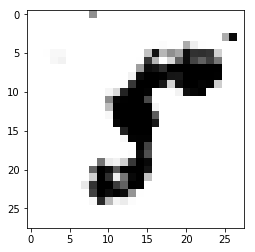

Estimate: [[-1.57637846]]
Iteration: 61100 at 2017-06-30 18:50:11.805591


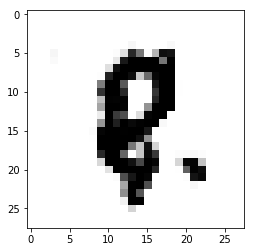

Estimate: [[ 57.51593399]]
Iteration: 61200 at 2017-06-30 18:50:20.271264


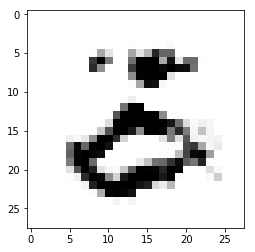

Estimate: [[-7.62009954]]
Iteration: 61300 at 2017-06-30 18:50:28.800660


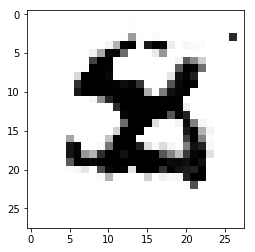

Estimate: [[ 26.58509636]]
Iteration: 61400 at 2017-06-30 18:50:37.279510


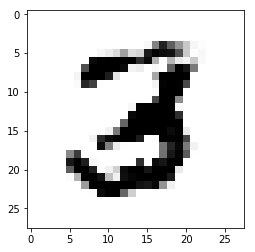

Estimate: [[ 11.40791321]]
Iteration: 61500 at 2017-06-30 18:50:45.758089


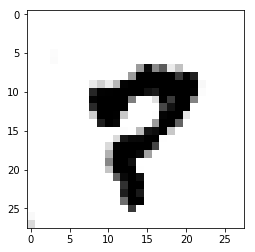

Estimate: [[ 13.93399906]]
Iteration: 61600 at 2017-06-30 18:50:54.261271


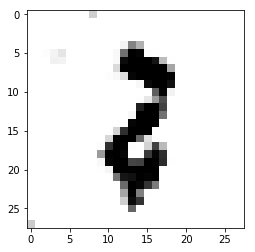

Estimate: [[ 7.81590843]]
Iteration: 61700 at 2017-06-30 18:51:02.739597


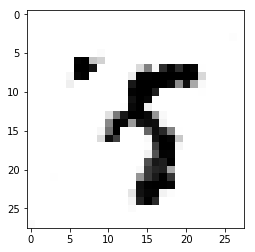

Estimate: [[-10.62775517]]
Iteration: 61800 at 2017-06-30 18:51:11.218986


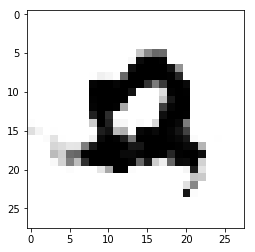

Estimate: [[ 21.5025425]]
Iteration: 61900 at 2017-06-30 18:51:19.695031


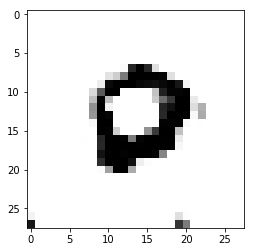

Estimate: [[ 35.79751968]]
Iteration: 62000 at 2017-06-30 18:51:28.166627


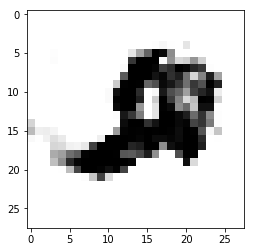

Estimate: [[ 0.14394218]]
Iteration: 62100 at 2017-06-30 18:51:36.916819


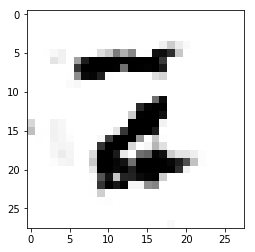

Estimate: [[-19.39245033]]
Iteration: 62200 at 2017-06-30 18:51:45.455355


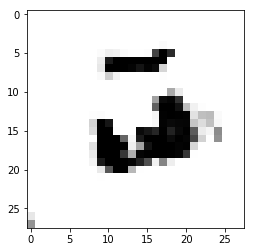

Estimate: [[ 40.27944946]]
Iteration: 62300 at 2017-06-30 18:51:53.972831


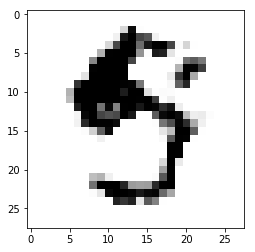

Estimate: [[-29.57923126]]
Iteration: 62400 at 2017-06-30 18:52:02.550030


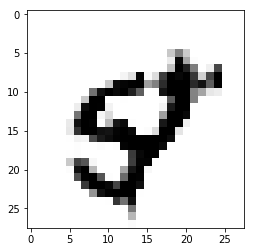

Estimate: [[-11.14130402]]
Iteration: 62500 at 2017-06-30 18:52:11.068779


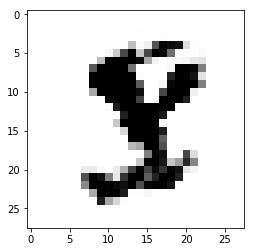

Estimate: [[-10.47182369]]
Iteration: 62600 at 2017-06-30 18:52:19.586005


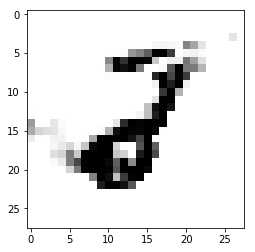

Estimate: [[ 6.03987217]]
Iteration: 62700 at 2017-06-30 18:52:28.133805


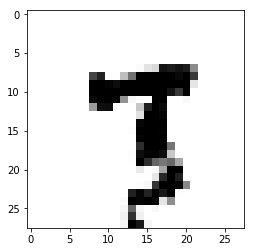

Estimate: [[-9.43099308]]
Iteration: 62800 at 2017-06-30 18:52:36.725663


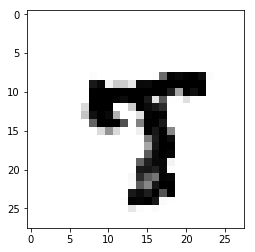

Estimate: [[ 41.15393448]]
Iteration: 62900 at 2017-06-30 18:52:45.257114


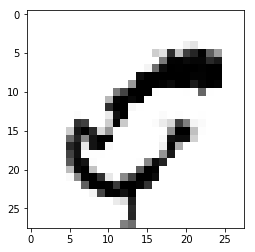

Estimate: [[ 46.58254242]]
Iteration: 63000 at 2017-06-30 18:52:55.399678


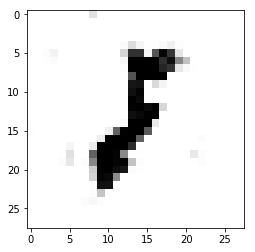

Estimate: [[-1.3426255]]
Iteration: 63100 at 2017-06-30 18:53:03.999548


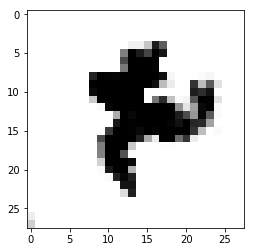

Estimate: [[-9.41354656]]
Iteration: 63200 at 2017-06-30 18:53:12.594643


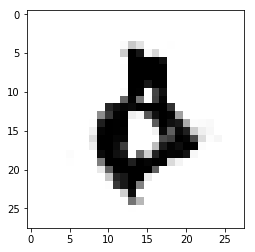

Estimate: [[-6.68074608]]
Iteration: 63300 at 2017-06-30 18:53:21.176517


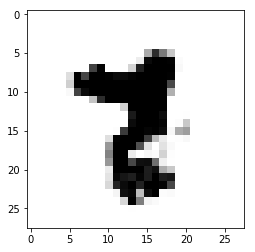

Estimate: [[-44.6436615]]
Iteration: 63400 at 2017-06-30 18:53:29.781847


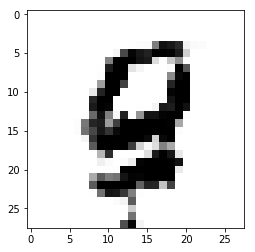

Estimate: [[-44.20902634]]
Iteration: 63500 at 2017-06-30 18:53:38.452899


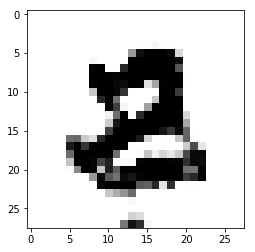

Estimate: [[-6.37715673]]
Iteration: 63600 at 2017-06-30 18:53:47.076628


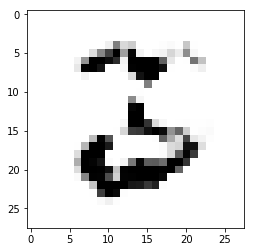

Estimate: [[ 25.41732407]]
Iteration: 63700 at 2017-06-30 18:53:55.683925


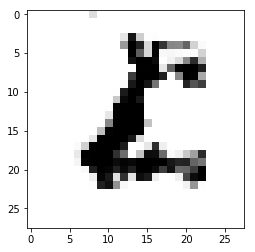

Estimate: [[ 10.34477711]]
Iteration: 63800 at 2017-06-30 18:54:04.285040


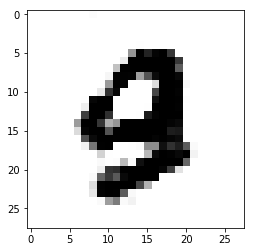

Estimate: [[-11.2054739]]
Iteration: 63900 at 2017-06-30 18:54:12.874430


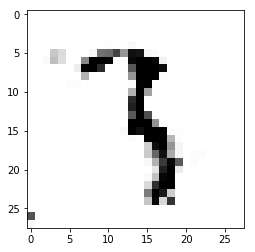

Estimate: [[ 12.30043793]]
Iteration: 64000 at 2017-06-30 18:54:21.528738


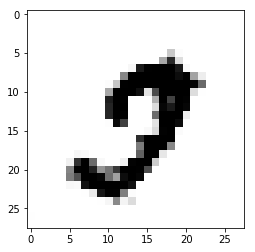

Estimate: [[ 13.88142014]]
Iteration: 64100 at 2017-06-30 18:54:30.146851


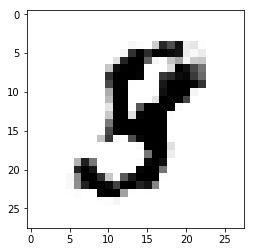

Estimate: [[ 2.40892649]]
Iteration: 64200 at 2017-06-30 18:54:38.981300


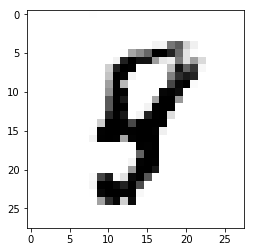

Estimate: [[ 4.98326635]]
Iteration: 64300 at 2017-06-30 18:54:47.588086


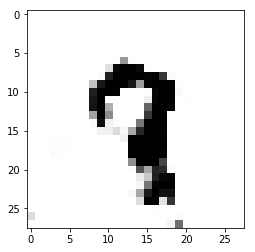

Estimate: [[-22.21822929]]
Iteration: 64400 at 2017-06-30 18:54:56.215676


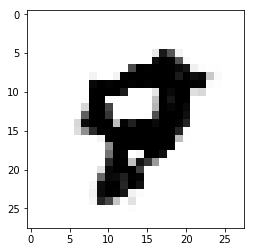

Estimate: [[-2.6262877]]
Iteration: 64500 at 2017-06-30 18:55:04.831975


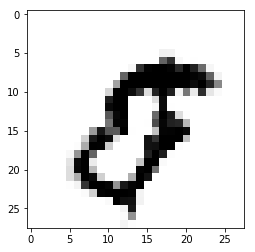

Estimate: [[ 7.70132685]]
Iteration: 64600 at 2017-06-30 18:55:13.551425


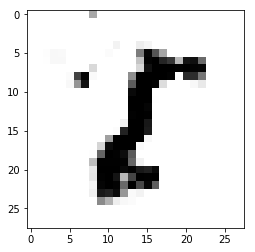

Estimate: [[ 26.38354111]]
Iteration: 64700 at 2017-06-30 18:55:22.205154


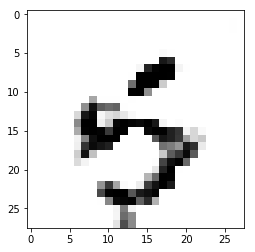

Estimate: [[-29.41483498]]
Iteration: 64800 at 2017-06-30 18:55:30.824635


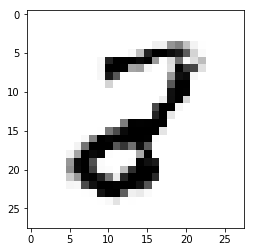

Estimate: [[ 12.96659374]]
Iteration: 64900 at 2017-06-30 18:55:39.474834


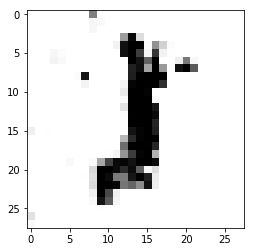

Estimate: [[ 12.79424953]]
Iteration: 65000 at 2017-06-30 18:55:48.138279


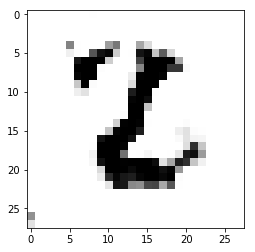

Estimate: [[ 21.31174088]]
Iteration: 65100 at 2017-06-30 18:55:56.776705


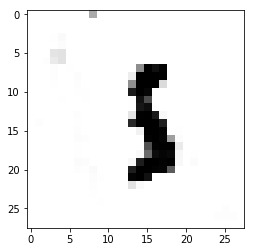

Estimate: [[-24.1567421]]
Iteration: 65200 at 2017-06-30 18:56:05.498592


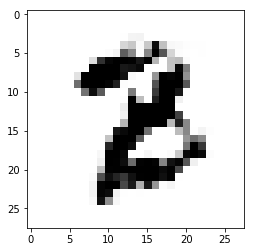

Estimate: [[-4.15324831]]
Iteration: 65300 at 2017-06-30 18:56:14.181398


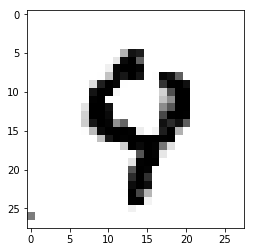

Estimate: [[ 23.4032917]]
Iteration: 65400 at 2017-06-30 18:56:22.861545


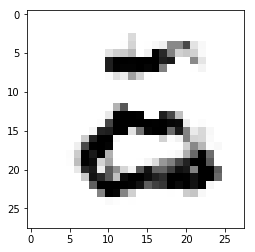

Estimate: [[ 36.65991592]]
Iteration: 65500 at 2017-06-30 18:56:31.535806


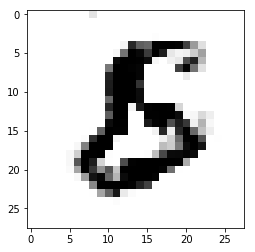

Estimate: [[ 2.05539942]]
Iteration: 65600 at 2017-06-30 18:56:40.304507


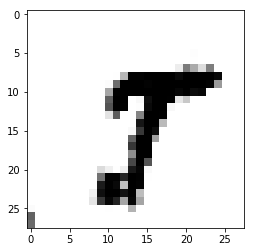

Estimate: [[ 43.04425812]]
Iteration: 65700 at 2017-06-30 18:56:49.086391


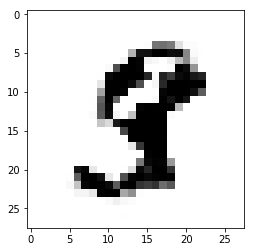

Estimate: [[ 25.93623924]]
Iteration: 65800 at 2017-06-30 18:56:57.813683


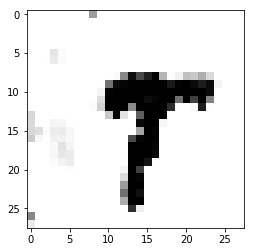

Estimate: [[ 17.9255352]]
Iteration: 65900 at 2017-06-30 18:57:06.493491


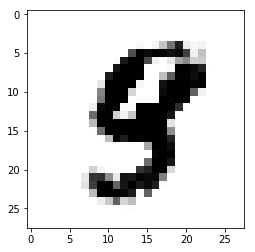

Estimate: [[-12.7543087]]
Iteration: 66000 at 2017-06-30 18:57:15.215099


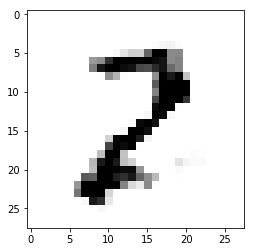

Estimate: [[ 11.96665192]]
Iteration: 66100 at 2017-06-30 18:57:23.924110


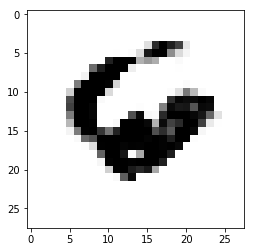

Estimate: [[ 49.14396286]]
Iteration: 66200 at 2017-06-30 18:57:32.646442


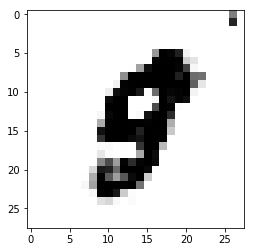

Estimate: [[ 19.96349335]]
Iteration: 66300 at 2017-06-30 18:57:41.372588


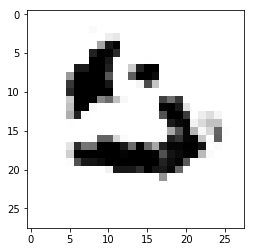

Estimate: [[ 5.3067627]]
Iteration: 66400 at 2017-06-30 18:57:50.112290


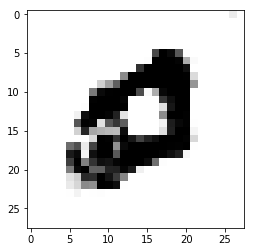

Estimate: [[-22.3193779]]
Iteration: 66500 at 2017-06-30 18:57:58.819207


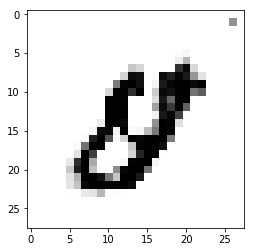

Estimate: [[-4.48983002]]
Iteration: 66600 at 2017-06-30 18:58:07.523943


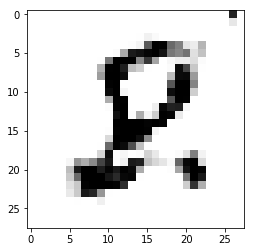

Estimate: [[ 28.96756554]]
Iteration: 66700 at 2017-06-30 18:58:16.256117


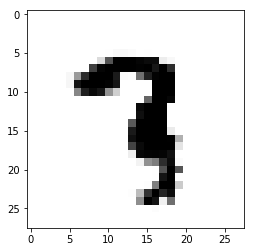

Estimate: [[-14.42839909]]
Iteration: 66800 at 2017-06-30 18:58:25.069322


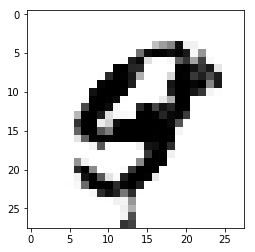

Estimate: [[-4.10881329]]
Iteration: 66900 at 2017-06-30 18:58:33.819259


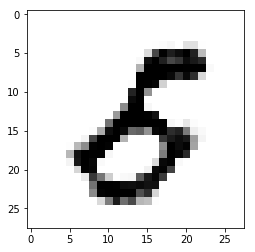

Estimate: [[ 43.99937439]]
Iteration: 67000 at 2017-06-30 18:58:42.593431


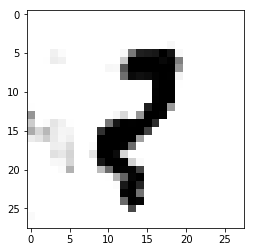

Estimate: [[ 18.00658035]]
Iteration: 67100 at 2017-06-30 18:58:51.372001


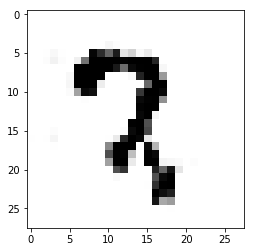

Estimate: [[ 37.7299118]]
Iteration: 67200 at 2017-06-30 18:59:00.156558


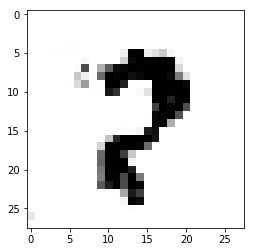

Estimate: [[-13.77943516]]
Iteration: 67300 at 2017-06-30 18:59:08.916390


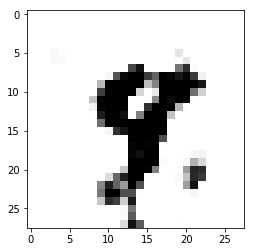

Estimate: [[-8.22896004]]
Iteration: 67400 at 2017-06-30 18:59:17.683827


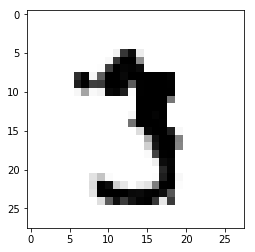

Estimate: [[ 1.48131156]]
Iteration: 67500 at 2017-06-30 18:59:26.459797


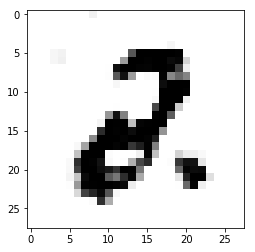

Estimate: [[ 18.36128426]]
Iteration: 67600 at 2017-06-30 18:59:35.270519


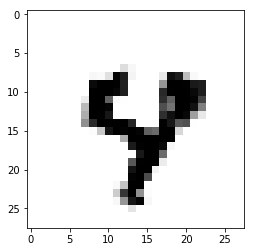

Estimate: [[-3.03581977]]
Iteration: 67700 at 2017-06-30 18:59:44.076396


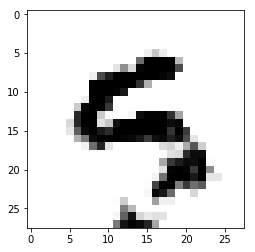

Estimate: [[ 7.03751945]]
Iteration: 67800 at 2017-06-30 18:59:52.867595


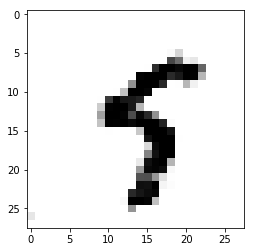

Estimate: [[ 21.70302773]]
Iteration: 67900 at 2017-06-30 19:00:01.752734


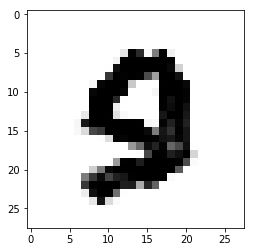

Estimate: [[ 14.72987843]]
Iteration: 68000 at 2017-06-30 19:00:10.533820


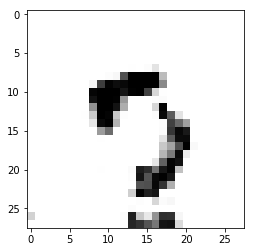

Estimate: [[-5.10014343]]
Iteration: 68100 at 2017-06-30 19:00:19.307258


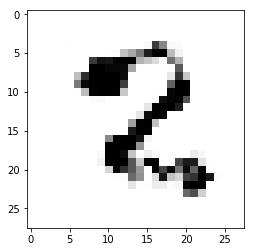

Estimate: [[-14.80149078]]
Iteration: 68200 at 2017-06-30 19:00:28.131312


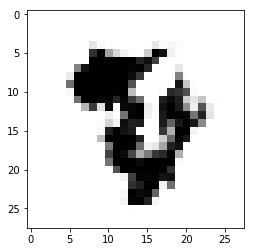

Estimate: [[-26.111866]]
Iteration: 68300 at 2017-06-30 19:00:36.956779


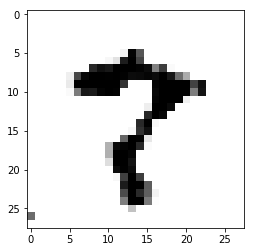

Estimate: [[ 19.52629852]]
Iteration: 68400 at 2017-06-30 19:00:45.741145


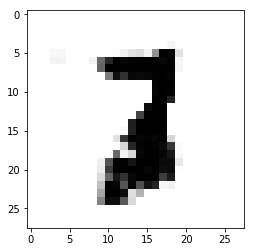

Estimate: [[ 9.13028336]]
Iteration: 68500 at 2017-06-30 19:00:54.562087


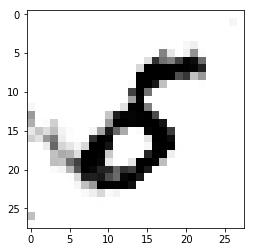

Estimate: [[ 15.40533257]]
Iteration: 68600 at 2017-06-30 19:01:03.404658


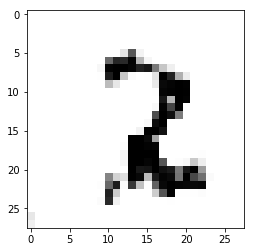

Estimate: [[-35.42917633]]
Iteration: 68700 at 2017-06-30 19:01:12.236848


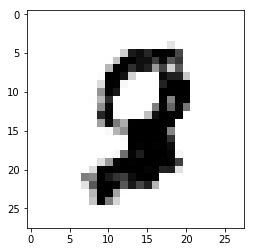

Estimate: [[ 18.42499542]]
Iteration: 68800 at 2017-06-30 19:01:21.083743


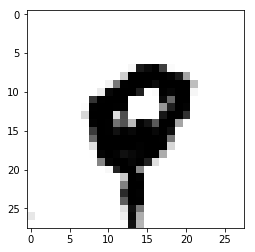

Estimate: [[ 12.7819252]]
Iteration: 68900 at 2017-06-30 19:01:29.931591


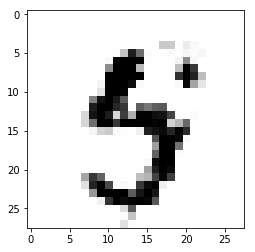

Estimate: [[-15.43594551]]
Iteration: 69000 at 2017-06-30 19:01:38.845318


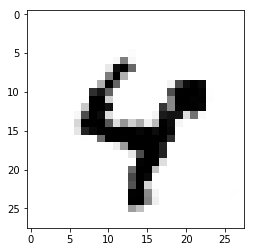

Estimate: [[ 7.43166542]]
Iteration: 69100 at 2017-06-30 19:01:47.664150


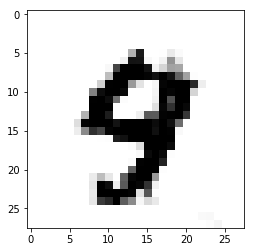

Estimate: [[-2.2491169]]
Iteration: 69200 at 2017-06-30 19:01:56.507759


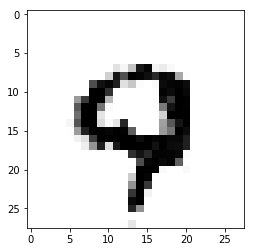

Estimate: [[-8.29775047]]
Iteration: 69300 at 2017-06-30 19:02:05.345748


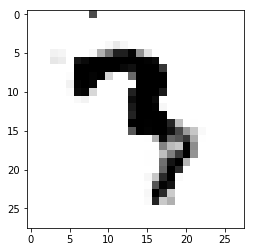

Estimate: [[ 21.83892822]]
Iteration: 69400 at 2017-06-30 19:02:14.241522


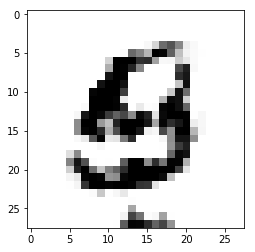

Estimate: [[-1.35376799]]
Iteration: 69500 at 2017-06-30 19:02:23.092499


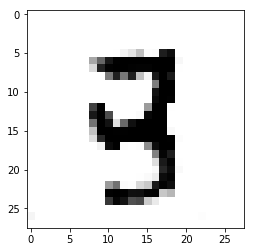

Estimate: [[-3.00374079]]
Iteration: 69600 at 2017-06-30 19:02:31.972088


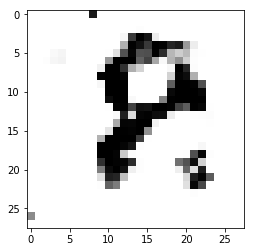

Estimate: [[ 36.33178711]]
Iteration: 69700 at 2017-06-30 19:02:40.916305


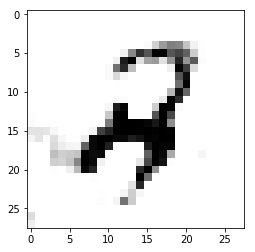

Estimate: [[-13.16651726]]
Iteration: 69800 at 2017-06-30 19:02:49.779225


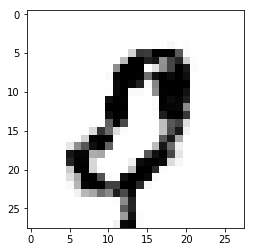

Estimate: [[-4.26341105]]
Iteration: 69900 at 2017-06-30 19:02:58.660848


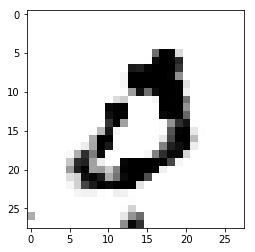

Estimate: [[ 7.94852972]]
Iteration: 70000 at 2017-06-30 19:03:07.575568


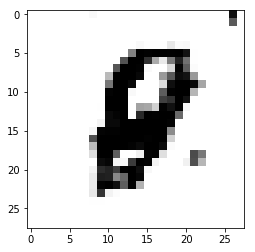

Estimate: [[ 8.46158886]]
Iteration: 70100 at 2017-06-30 19:03:16.555915


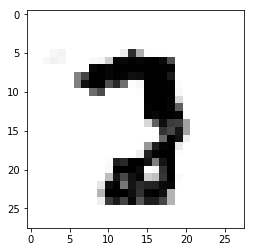

Estimate: [[ 35.11117935]]
Iteration: 70200 at 2017-06-30 19:03:25.449214


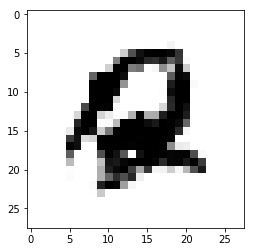

Estimate: [[ 17.3986187]]
Iteration: 70300 at 2017-06-30 19:03:34.351588


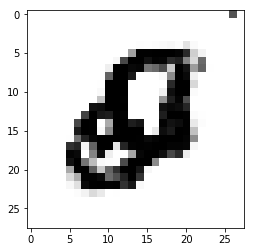

Estimate: [[-10.84578037]]
Iteration: 70400 at 2017-06-30 19:03:43.279736


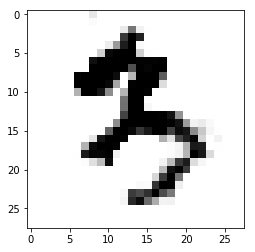

Estimate: [[ 8.12451363]]
Iteration: 70500 at 2017-06-30 19:03:52.225300


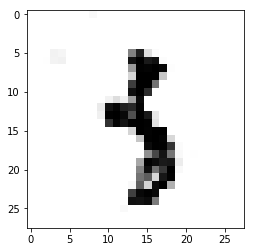

Estimate: [[ 19.94505119]]
Iteration: 70600 at 2017-06-30 19:04:01.115389


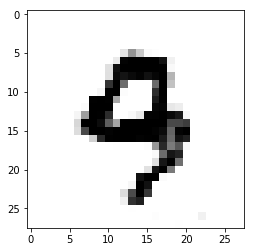

Estimate: [[ 33.76229858]]
Iteration: 70700 at 2017-06-30 19:04:10.020680


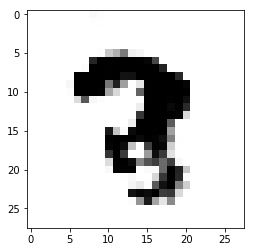

Estimate: [[-9.32066917]]
Iteration: 70800 at 2017-06-30 19:04:18.915692


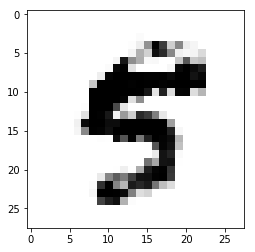

Estimate: [[ 1.09294605]]
Iteration: 70900 at 2017-06-30 19:04:27.829113


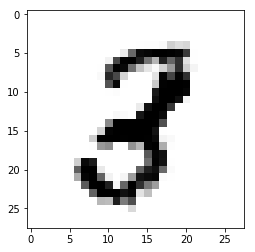

Estimate: [[-23.17152214]]
Iteration: 71000 at 2017-06-30 19:04:36.813392


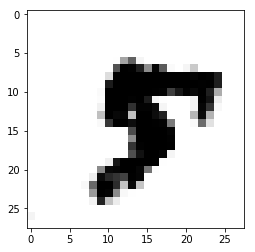

Estimate: [[ 27.62547684]]
Iteration: 71100 at 2017-06-30 19:04:45.724045


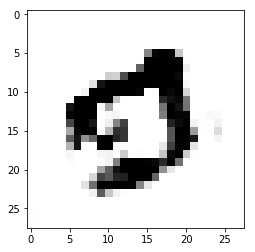

Estimate: [[-8.48308277]]
Iteration: 71200 at 2017-06-30 19:04:54.734109


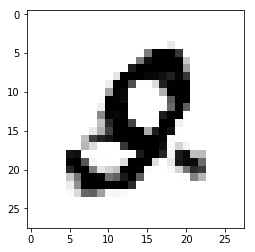

Estimate: [[-19.49045372]]
Iteration: 71300 at 2017-06-30 19:05:03.650739


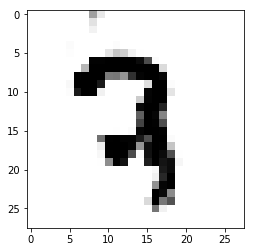

Estimate: [[ 32.90512085]]
Iteration: 71400 at 2017-06-30 19:05:12.587599


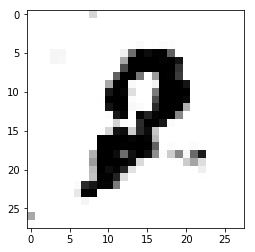

Estimate: [[-13.85550594]]
Iteration: 71500 at 2017-06-30 19:05:21.496441


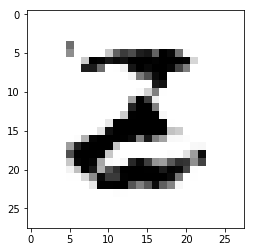

Estimate: [[ 2.15038013]]
Iteration: 71600 at 2017-06-30 19:05:30.454266


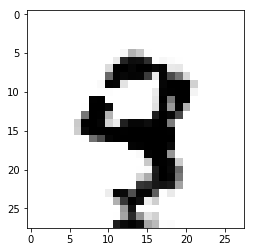

Estimate: [[-15.54641914]]
Iteration: 71700 at 2017-06-30 19:05:39.391630


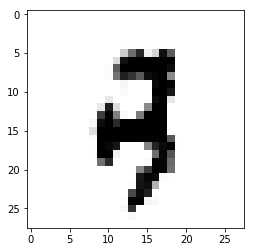

Estimate: [[-10.22486305]]
Iteration: 71800 at 2017-06-30 19:05:48.344496


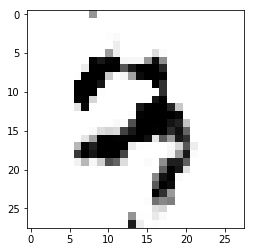

Estimate: [[ 6.46238279]]
Iteration: 71900 at 2017-06-30 19:05:57.301579


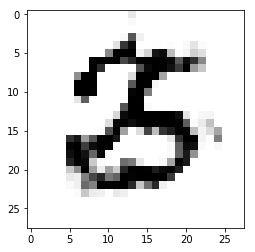

Estimate: [[ 20.14043236]]
Iteration: 72000 at 2017-06-30 19:06:06.259016


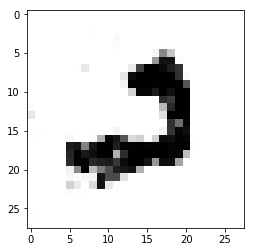

Estimate: [[ 13.87005997]]
Iteration: 72100 at 2017-06-30 19:06:15.275161


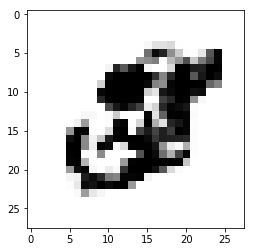

Estimate: [[-61.19342804]]
Iteration: 72200 at 2017-06-30 19:06:24.249130


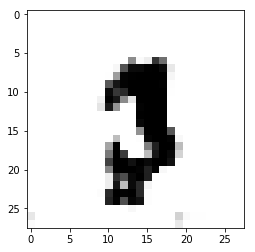

Estimate: [[-6.58058071]]
Iteration: 72300 at 2017-06-30 19:06:33.317560


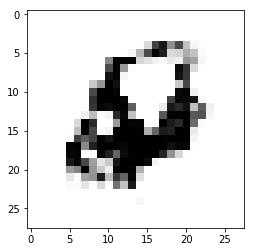

Estimate: [[-26.23729706]]
Iteration: 72400 at 2017-06-30 19:06:42.318187


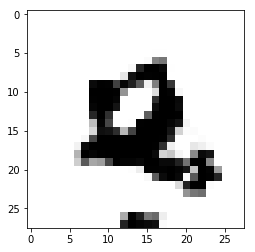

Estimate: [[ 27.44612503]]
Iteration: 72500 at 2017-06-30 19:06:51.308433


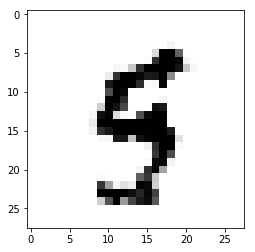

Estimate: [[-1.67139149]]
Iteration: 72600 at 2017-06-30 19:07:00.322398


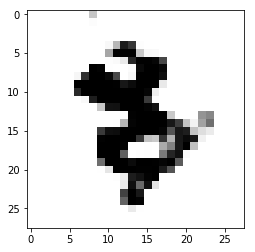

Estimate: [[ 33.67549896]]
Iteration: 72700 at 2017-06-30 19:07:09.287196


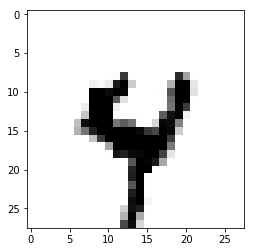

Estimate: [[ 1.12862051]]
Iteration: 72800 at 2017-06-30 19:07:18.291537


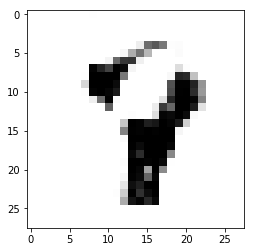

Estimate: [[ 21.83270454]]
Iteration: 72900 at 2017-06-30 19:07:27.320374


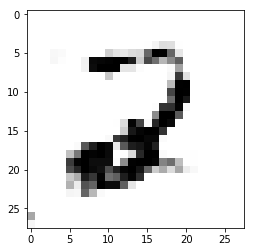

Estimate: [[ 23.82631493]]
Iteration: 73000 at 2017-06-30 19:07:36.325901


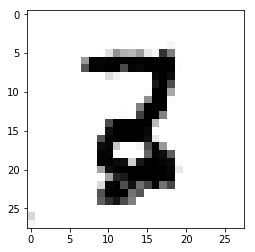

Estimate: [[ 17.83551598]]
Iteration: 73100 at 2017-06-30 19:07:45.356597


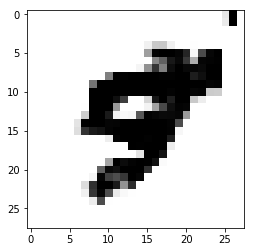

Estimate: [[ 30.17590332]]
Iteration: 73200 at 2017-06-30 19:07:54.364412


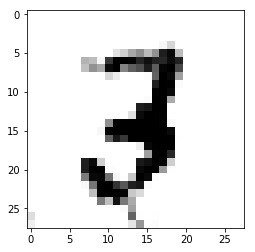

Estimate: [[-15.92695904]]
Iteration: 73300 at 2017-06-30 19:08:03.389177


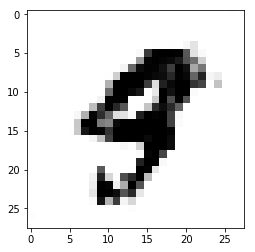

Estimate: [[-11.51362705]]
Iteration: 73400 at 2017-06-30 19:08:12.479542


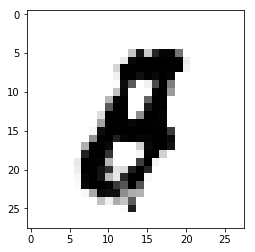

Estimate: [[-26.81615829]]
Iteration: 73500 at 2017-06-30 19:08:21.501347


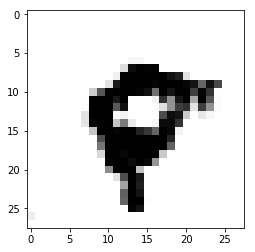

Estimate: [[-19.21346283]]
Iteration: 73600 at 2017-06-30 19:08:30.580768


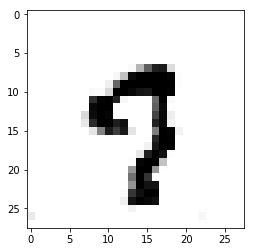

Estimate: [[ 17.58133316]]
Iteration: 73700 at 2017-06-30 19:08:39.702785


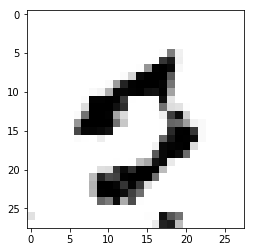

Estimate: [[ 10.83619308]]
Iteration: 73800 at 2017-06-30 19:08:48.718488


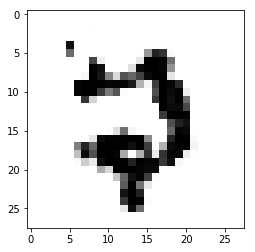

Estimate: [[ 3.22417331]]
Iteration: 73900 at 2017-06-30 19:08:57.732950


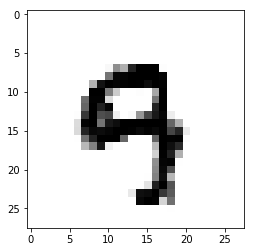

Estimate: [[ 20.74173927]]
Iteration: 74000 at 2017-06-30 19:09:06.769813


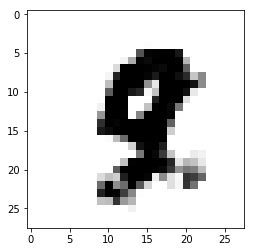

Estimate: [[-6.78627205]]
Iteration: 74100 at 2017-06-30 19:09:17.677746


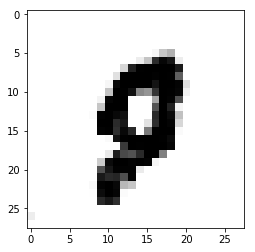

Estimate: [[-2.68335056]]
Iteration: 74200 at 2017-06-30 19:09:26.798703


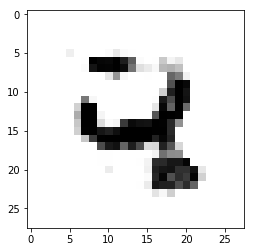

Estimate: [[ 32.4033432]]
Iteration: 74300 at 2017-06-30 19:09:35.893803


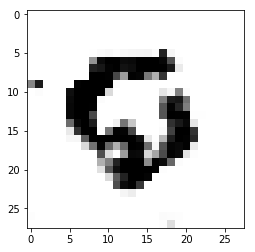

Estimate: [[-19.63178825]]
Iteration: 74400 at 2017-06-30 19:09:44.994951


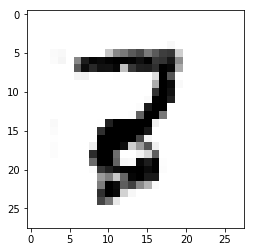

Estimate: [[ 3.87119126]]
Iteration: 74500 at 2017-06-30 19:09:54.211627


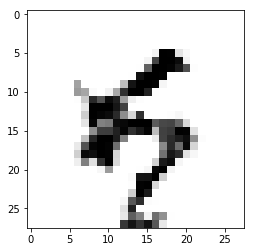

Estimate: [[-40.34751129]]
Iteration: 74600 at 2017-06-30 19:10:03.362839


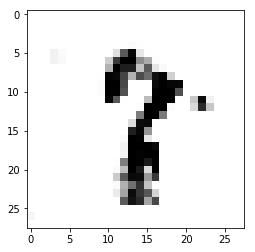

Estimate: [[-32.3926506]]
Iteration: 74700 at 2017-06-30 19:10:12.467369


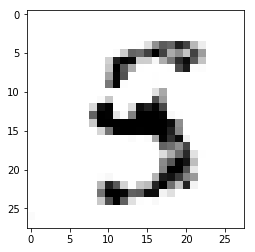

Estimate: [[ 7.63493824]]
Iteration: 74800 at 2017-06-30 19:10:21.612039


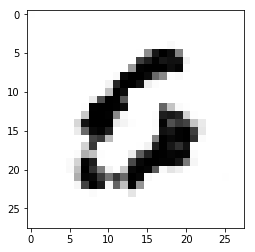

Estimate: [[-18.41371918]]
Iteration: 74900 at 2017-06-30 19:10:30.724861


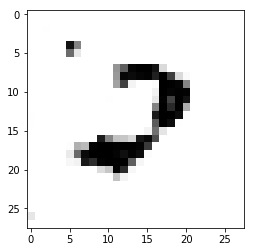

Estimate: [[-8.47141266]]
Iteration: 75000 at 2017-06-30 19:10:39.986461


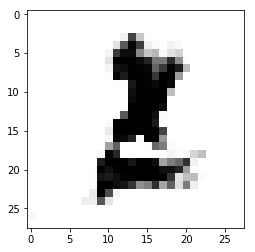

Estimate: [[ 8.28075314]]
Iteration: 75100 at 2017-06-30 19:10:49.163786


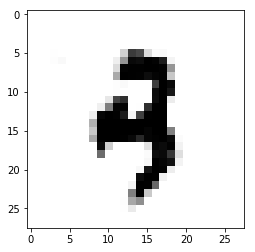

Estimate: [[-16.67240715]]
Iteration: 75200 at 2017-06-30 19:10:58.305807


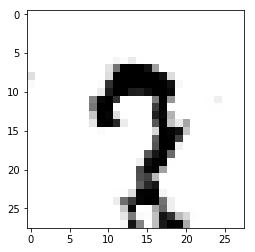

Estimate: [[ 12.9827795]]
Iteration: 75300 at 2017-06-30 19:11:07.455591


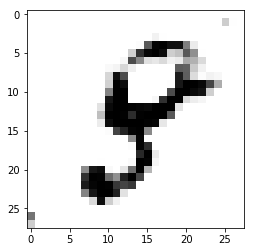

Estimate: [[-30.85655785]]
Iteration: 75400 at 2017-06-30 19:11:16.628176


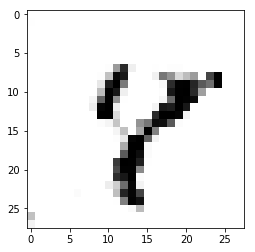

Estimate: [[ 38.84514999]]
Iteration: 75500 at 2017-06-30 19:11:25.820399


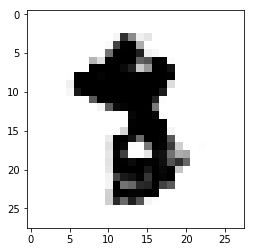

Estimate: [[-35.37961578]]
Iteration: 75600 at 2017-06-30 19:11:35.121111


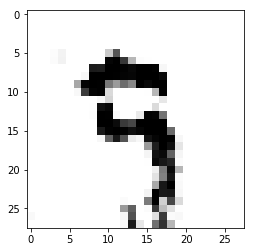

Estimate: [[-26.0591259]]
Iteration: 75700 at 2017-06-30 19:11:44.585126


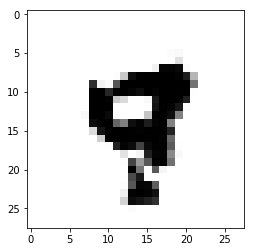

Estimate: [[ 3.72549629]]
Iteration: 75800 at 2017-06-30 19:11:53.807594


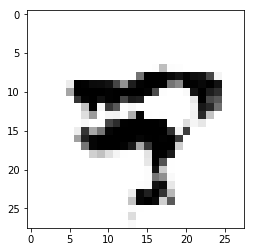

Estimate: [[ 38.50362396]]
Iteration: 75900 at 2017-06-30 19:12:02.985046


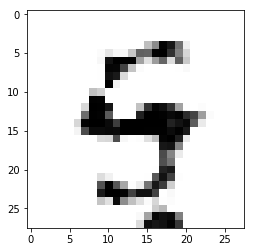

Estimate: [[ 17.12071419]]
Iteration: 76000 at 2017-06-30 19:12:12.214396


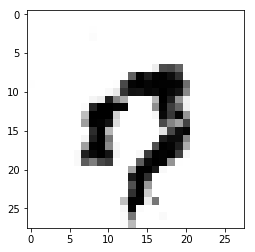

Estimate: [[-19.30452728]]
Iteration: 76100 at 2017-06-30 19:12:21.458169


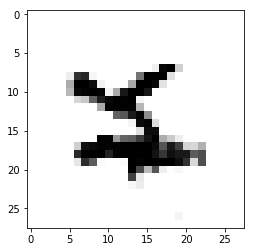

Estimate: [[-48.79414368]]
Iteration: 76200 at 2017-06-30 19:12:30.673071


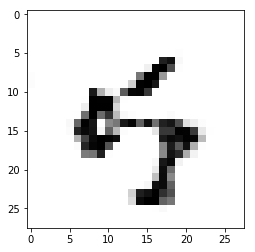

Estimate: [[ 20.81620216]]
Iteration: 76300 at 2017-06-30 19:12:39.966705


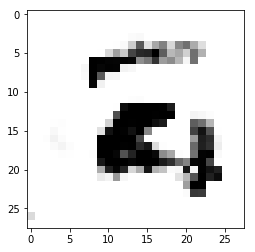

Estimate: [[ 25.32990265]]
Iteration: 76400 at 2017-06-30 19:12:49.186072


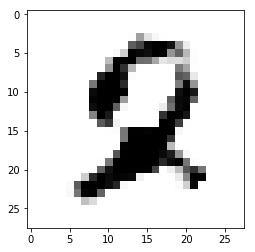

Estimate: [[ 52.1339035]]
Iteration: 76500 at 2017-06-30 19:12:58.434753


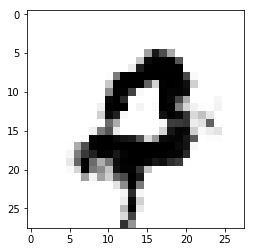

Estimate: [[-7.82202864]]
Iteration: 76600 at 2017-06-30 19:13:07.712330


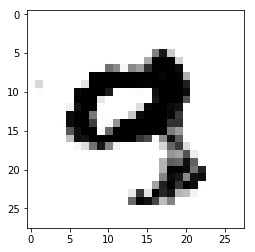

Estimate: [[ 19.09702492]]
Iteration: 76700 at 2017-06-30 19:13:17.016552


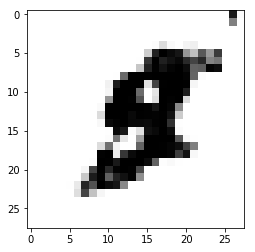

Estimate: [[ 10.30072021]]
Iteration: 76800 at 2017-06-30 19:13:26.267532


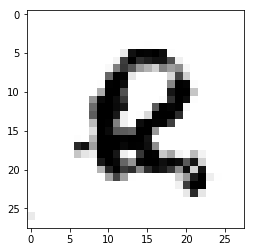

Estimate: [[-48.4695549]]
Iteration: 76900 at 2017-06-30 19:13:35.545985


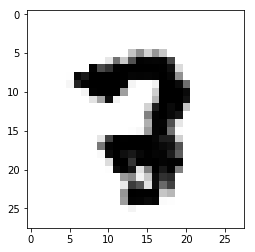

Estimate: [[ 15.04799557]]
Iteration: 77000 at 2017-06-30 19:13:44.806514


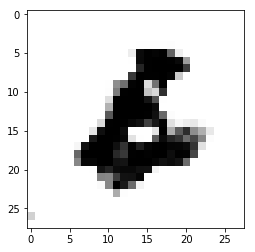

Estimate: [[-2.92981839]]
Iteration: 77100 at 2017-06-30 19:13:54.128129


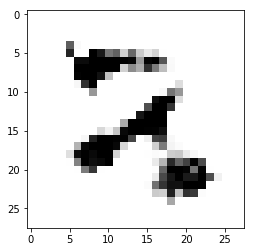

Estimate: [[-11.28551102]]
Iteration: 77200 at 2017-06-30 19:14:03.401325


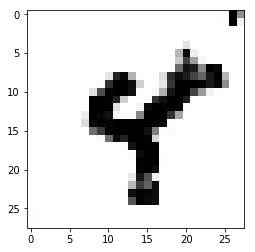

Estimate: [[ 43.8348465]]
Iteration: 77300 at 2017-06-30 19:14:12.654440


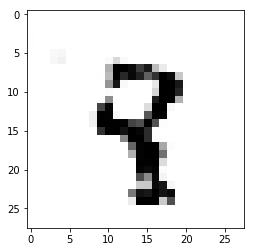

Estimate: [[-2.99841213]]
Iteration: 77400 at 2017-06-30 19:14:21.936167


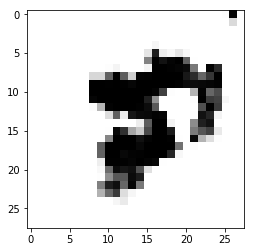

Estimate: [[ 28.30012894]]
Iteration: 77500 at 2017-06-30 19:14:31.225476


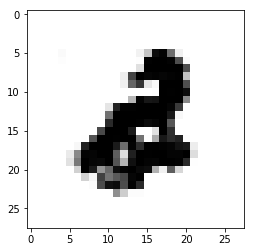

Estimate: [[ 2.07583904]]
Iteration: 77600 at 2017-06-30 19:14:40.686906


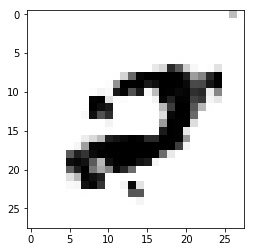

Estimate: [[-3.29819703]]
Iteration: 77700 at 2017-06-30 19:14:49.979392


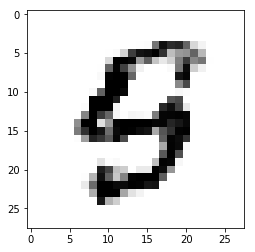

Estimate: [[ 28.35752487]]
Iteration: 77800 at 2017-06-30 19:14:59.367004


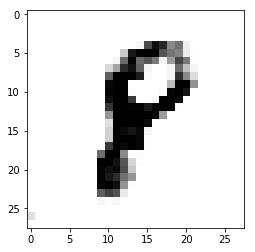

Estimate: [[ 10.19726086]]
Iteration: 77900 at 2017-06-30 19:15:08.650466


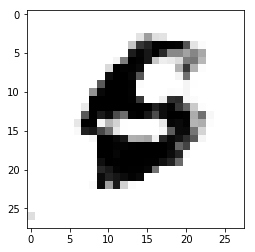

Estimate: [[ 70.17490387]]
Iteration: 78000 at 2017-06-30 19:15:17.998705


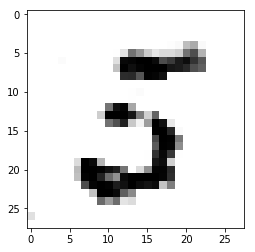

Estimate: [[-3.58886266]]
Iteration: 78100 at 2017-06-30 19:15:27.326289


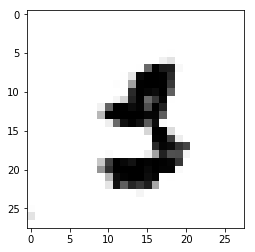

Estimate: [[-3.52261209]]
Iteration: 78200 at 2017-06-30 19:15:36.639602


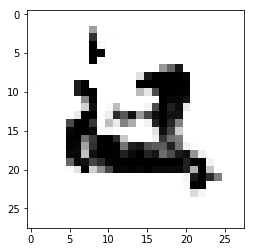

Estimate: [[ 20.19820023]]
Iteration: 78300 at 2017-06-30 19:15:45.941574


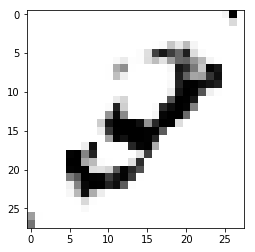

Estimate: [[-3.21001053]]
Iteration: 78400 at 2017-06-30 19:15:55.306415


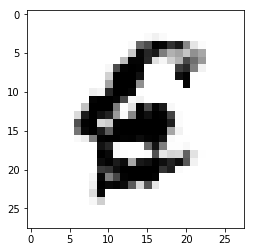

Estimate: [[ 12.46415138]]
Iteration: 78500 at 2017-06-30 19:16:04.661122


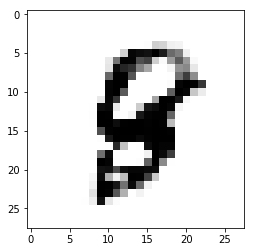

Estimate: [[ 24.17271233]]
Iteration: 78600 at 2017-06-30 19:16:14.042902


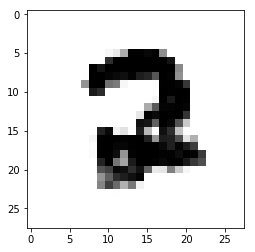

Estimate: [[-9.47451591]]
Iteration: 78700 at 2017-06-30 19:16:23.366687


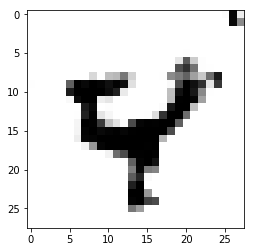

Estimate: [[ 10.52978897]]
Iteration: 78800 at 2017-06-30 19:16:32.707193


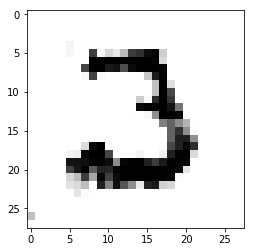

Estimate: [[ 24.63315582]]
Iteration: 78900 at 2017-06-30 19:16:42.147379


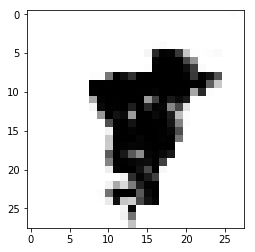

Estimate: [[-12.92674923]]
Iteration: 79000 at 2017-06-30 19:16:51.506366


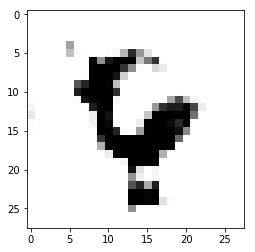

Estimate: [[-17.45968246]]
Iteration: 79100 at 2017-06-30 19:17:00.894611


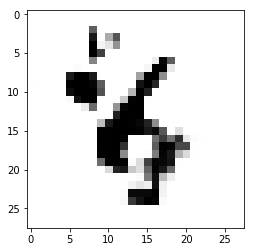

Estimate: [[ 10.8497982]]
Iteration: 79200 at 2017-06-30 19:17:10.241707


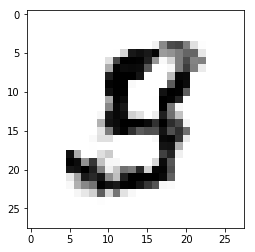

Estimate: [[-17.41769218]]
Iteration: 79300 at 2017-06-30 19:17:19.600286


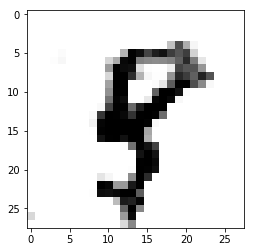

Estimate: [[ 5.26726913]]
Iteration: 79400 at 2017-06-30 19:17:28.965088


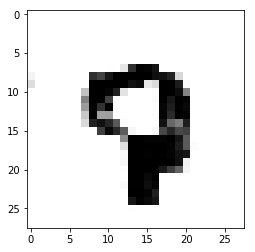

Estimate: [[ 6.21090221]]
Iteration: 79500 at 2017-06-30 19:17:38.367362


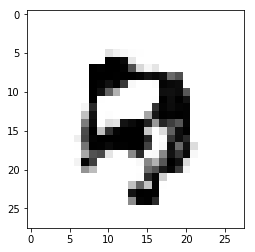

Estimate: [[ 28.68061447]]
Iteration: 79600 at 2017-06-30 19:17:47.731837


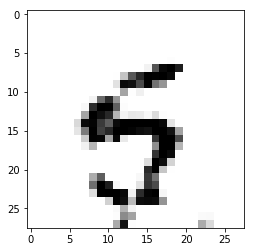

Estimate: [[ 43.22041702]]
Iteration: 79700 at 2017-06-30 19:17:57.087782


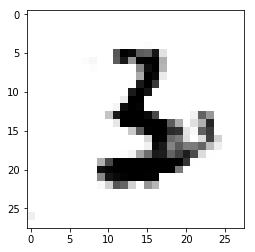

Estimate: [[ 27.02073288]]
Iteration: 79800 at 2017-06-30 19:18:06.449770


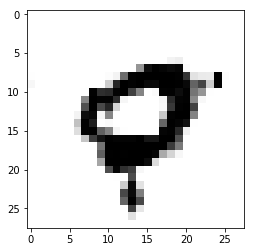

Estimate: [[-17.36571121]]
Iteration: 79900 at 2017-06-30 19:18:15.839112


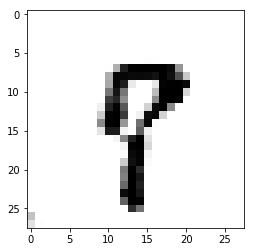

Estimate: [[ 16.59709358]]
Iteration: 80000 at 2017-06-30 19:18:25.312038


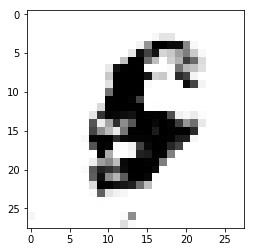

Estimate: [[-11.71569252]]
Iteration: 80100 at 2017-06-30 19:18:34.770422


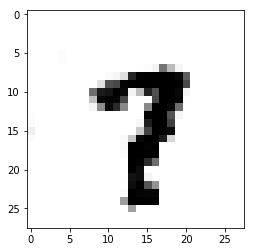

Estimate: [[-2.12938786]]
Iteration: 80200 at 2017-06-30 19:18:44.147646


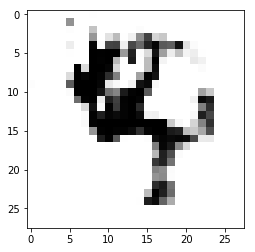

Estimate: [[ 8.18863201]]
Iteration: 80300 at 2017-06-30 19:18:53.531513


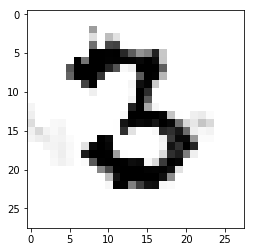

Estimate: [[ 13.30177307]]
Iteration: 80400 at 2017-06-30 19:19:02.931919


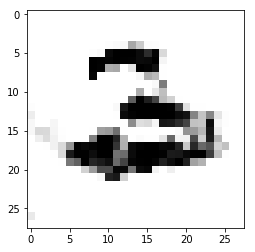

Estimate: [[ 52.05352783]]
Iteration: 80500 at 2017-06-30 19:19:12.329388


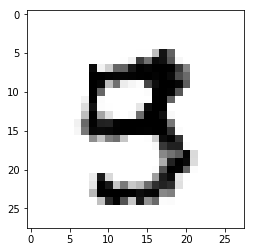

Estimate: [[-10.55194187]]
Iteration: 80600 at 2017-06-30 19:19:21.794532


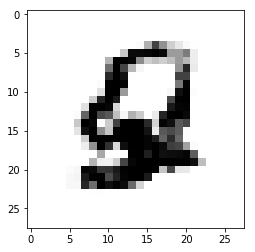

Estimate: [[ 11.85873508]]
Iteration: 80700 at 2017-06-30 19:19:31.220665


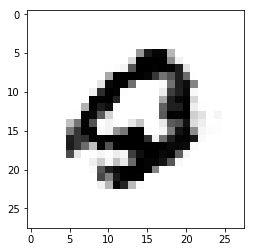

Estimate: [[ 4.01484108]]
Iteration: 80800 at 2017-06-30 19:19:40.684683


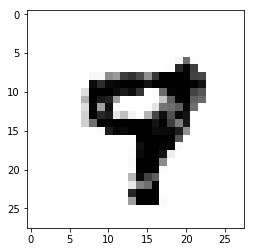

Estimate: [[-23.6987381]]
Iteration: 80900 at 2017-06-30 19:19:50.124305


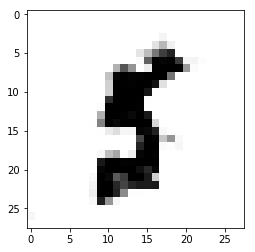

Estimate: [[-11.11992931]]
Iteration: 81000 at 2017-06-30 19:19:59.559802


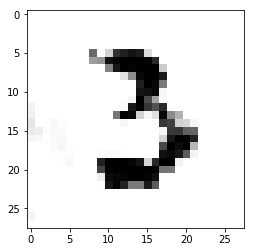

Estimate: [[-8.49559116]]
Iteration: 81100 at 2017-06-30 19:20:09.109941


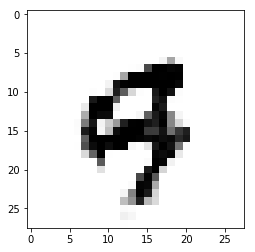

Estimate: [[-24.57109833]]
Iteration: 81200 at 2017-06-30 19:20:18.551370


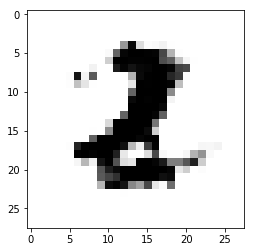

Estimate: [[ 17.8802433]]
Iteration: 81300 at 2017-06-30 19:20:27.991531


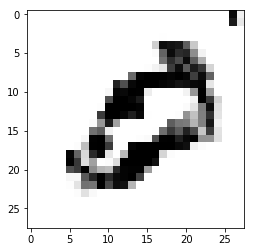

Estimate: [[ 56.54257202]]
Iteration: 81400 at 2017-06-30 19:20:37.516815


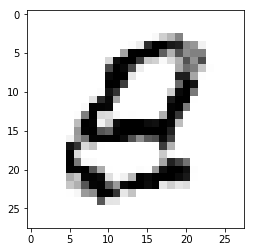

Estimate: [[ 16.72851372]]
Iteration: 81500 at 2017-06-30 19:20:46.962643


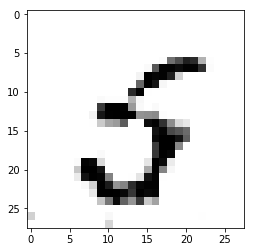

Estimate: [[ 54.3196106]]
Iteration: 81600 at 2017-06-30 19:20:56.470427


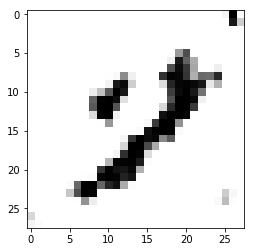

Estimate: [[-2.81385183]]
Iteration: 81700 at 2017-06-30 19:21:05.961623


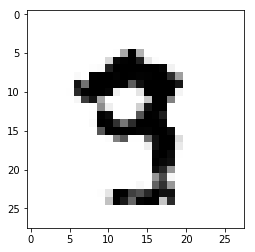

Estimate: [[ 5.10549116]]
Iteration: 81800 at 2017-06-30 19:21:15.433984


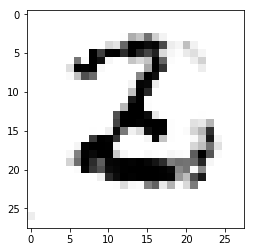

Estimate: [[ 25.73679924]]
Iteration: 81900 at 2017-06-30 19:21:24.881765


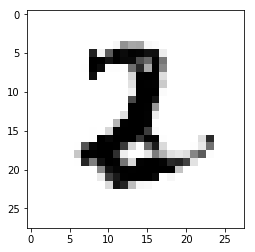

Estimate: [[-4.38463497]]
Iteration: 82000 at 2017-06-30 19:21:34.340194


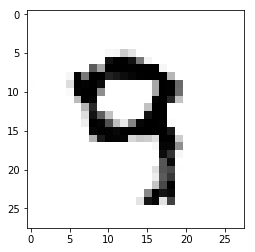

Estimate: [[ 2.73801684]]
Iteration: 82100 at 2017-06-30 19:21:43.837799


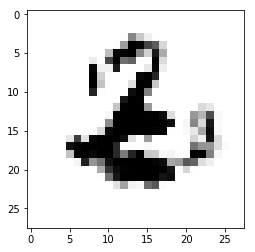

Estimate: [[ 39.19558334]]
Iteration: 82200 at 2017-06-30 19:21:53.426566


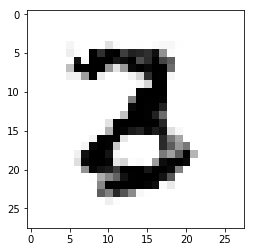

Estimate: [[-2.40452385]]
Iteration: 82300 at 2017-06-30 19:22:02.921842


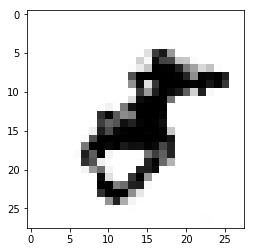

Estimate: [[ 56.62328339]]
Iteration: 82400 at 2017-06-30 19:22:12.395885


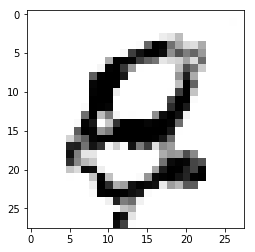

Estimate: [[ 30.18840599]]
Iteration: 82500 at 2017-06-30 19:22:21.882940


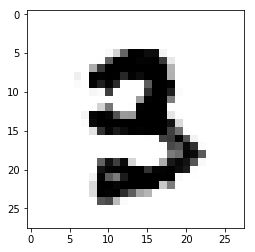

Estimate: [[-20.31843185]]
Iteration: 82600 at 2017-06-30 19:22:31.419704


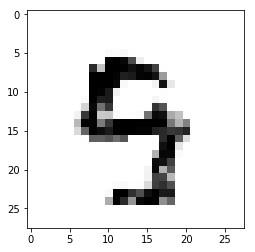

Estimate: [[-45.29223633]]
Iteration: 82700 at 2017-06-30 19:22:41.056742


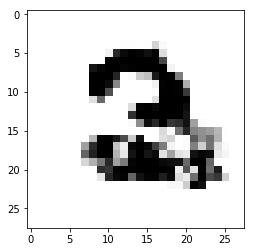

Estimate: [[-4.57153749]]
Iteration: 82800 at 2017-06-30 19:22:50.584372


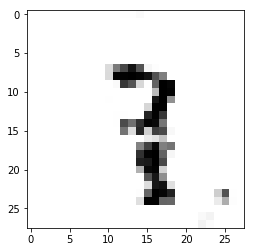

Estimate: [[ 4.72881699]]
Iteration: 82900 at 2017-06-30 19:23:00.079778


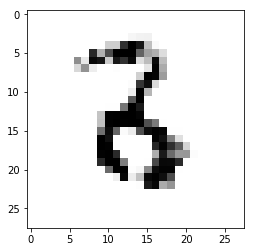

Estimate: [[ 12.28003216]]
Iteration: 83000 at 2017-06-30 19:23:09.599709


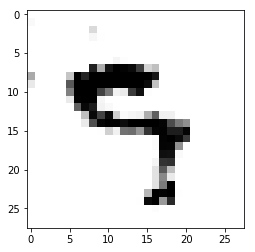

Estimate: [[ 74.88051605]]
Iteration: 83100 at 2017-06-30 19:23:19.178857


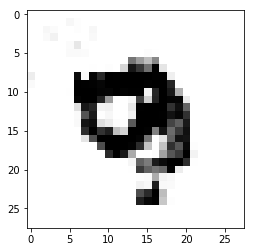

Estimate: [[-13.73862171]]
Iteration: 83200 at 2017-06-30 19:23:28.683820


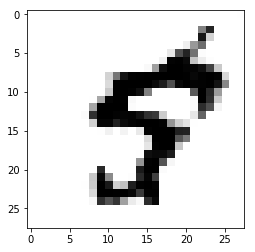

Estimate: [[ 21.6914196]]
Iteration: 83300 at 2017-06-30 19:23:38.285358


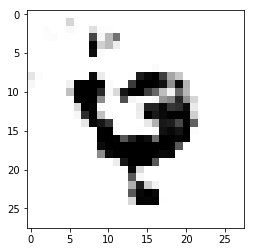

Estimate: [[-1.41872168]]
Iteration: 83400 at 2017-06-30 19:23:47.815101


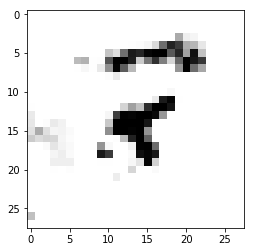

Estimate: [[-58.39765167]]
Iteration: 83500 at 2017-06-30 19:23:57.341756


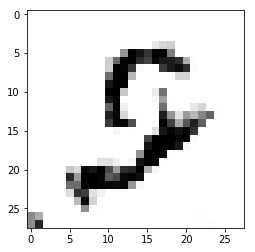

Estimate: [[-40.40377426]]
Iteration: 83600 at 2017-06-30 19:24:06.929700


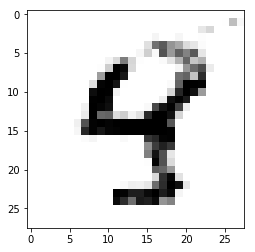

Estimate: [[-33.75561523]]
Iteration: 83700 at 2017-06-30 19:24:16.510865


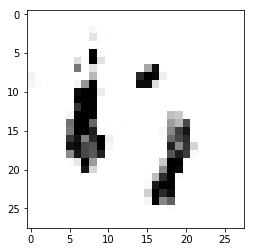

Estimate: [[ 20.27717972]]
Iteration: 83800 at 2017-06-30 19:24:26.063570


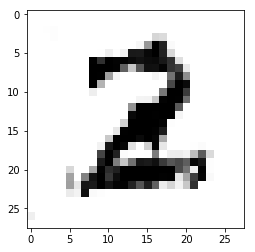

Estimate: [[ 31.54957771]]
Iteration: 83900 at 2017-06-30 19:24:35.653611


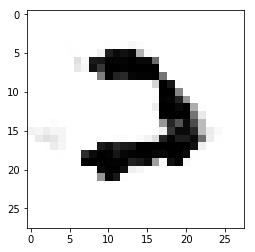

Estimate: [[ 42.63898468]]
Iteration: 84000 at 2017-06-30 19:24:45.237093


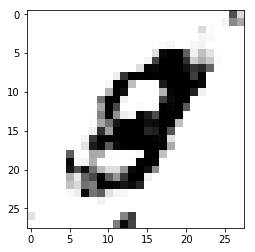

Estimate: [[-16.72260284]]
Iteration: 84100 at 2017-06-30 19:24:54.816921


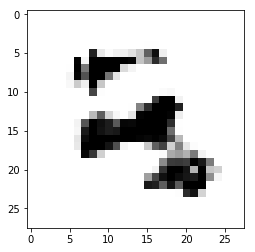

Estimate: [[ 20.29349518]]
Iteration: 84200 at 2017-06-30 19:25:04.370494


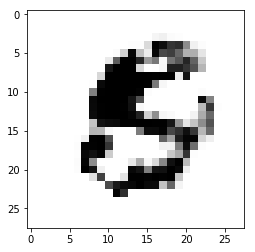

Estimate: [[-7.61165762]]
Iteration: 84300 at 2017-06-30 19:25:13.931346


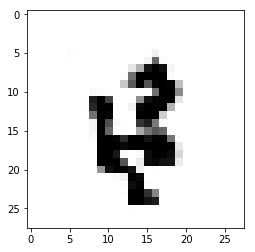

Estimate: [[ 53.26612473]]
Iteration: 84400 at 2017-06-30 19:25:23.599830


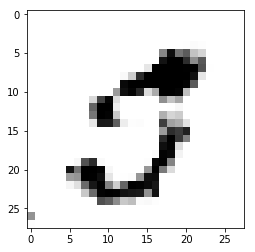

Estimate: [[ 4.70599461]]
Iteration: 84500 at 2017-06-30 19:25:33.168726


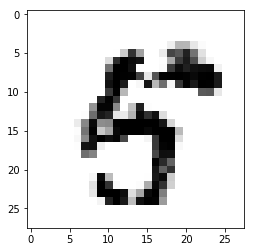

Estimate: [[-15.87816143]]
Iteration: 84600 at 2017-06-30 19:25:42.764834


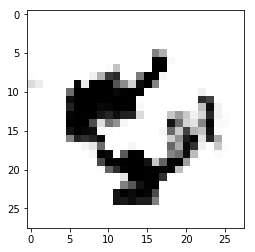

Estimate: [[ 23.56641769]]
Iteration: 84700 at 2017-06-30 19:25:52.386015


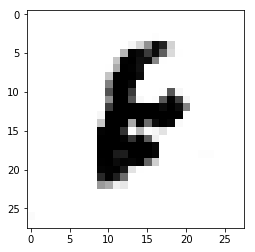

Estimate: [[ 39.82481384]]
Iteration: 84800 at 2017-06-30 19:26:02.063075


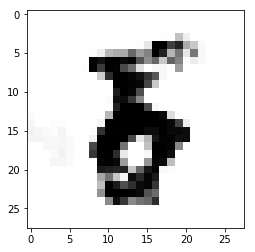

Estimate: [[-27.65708542]]
Iteration: 84900 at 2017-06-30 19:26:11.656288


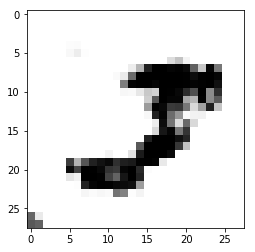

Estimate: [[-38.95812607]]
Iteration: 85000 at 2017-06-30 19:26:21.263418


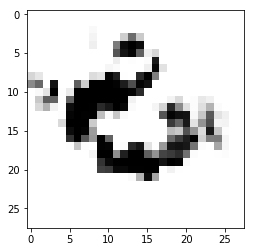

Estimate: [[-22.70730972]]
Iteration: 85100 at 2017-06-30 19:26:30.866801


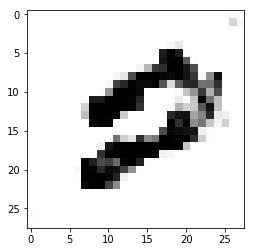

Estimate: [[ 31.44794846]]
Iteration: 85200 at 2017-06-30 19:26:40.585448


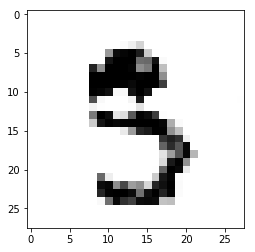

Estimate: [[ 10.54827595]]
Iteration: 85300 at 2017-06-30 19:26:50.434834


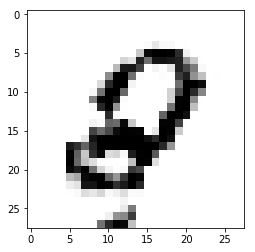

Estimate: [[ 28.4082737]]
Iteration: 85400 at 2017-06-30 19:27:00.061914


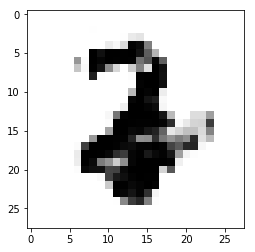

Estimate: [[ 32.69181442]]
Iteration: 85500 at 2017-06-30 19:27:09.753611


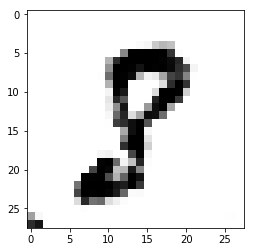

Estimate: [[ 11.57957745]]
Iteration: 85600 at 2017-06-30 19:27:19.424848


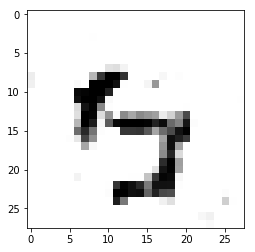

Estimate: [[-5.88155508]]
Iteration: 85700 at 2017-06-30 19:27:29.047032


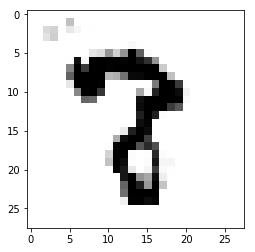

Estimate: [[ 7.73000336]]
Iteration: 85800 at 2017-06-30 19:27:38.657224


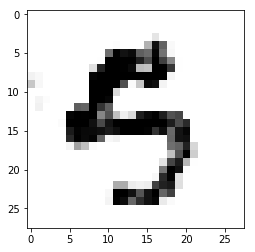

Estimate: [[ 41.22753906]]
Iteration: 85900 at 2017-06-30 19:27:48.292092


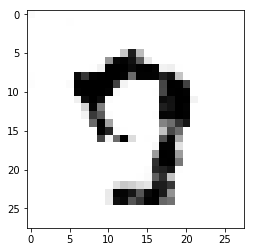

Estimate: [[-38.80529785]]
Iteration: 86000 at 2017-06-30 19:27:57.935502


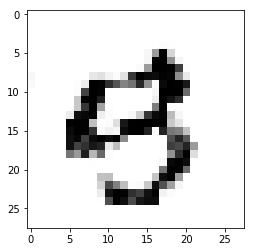

Estimate: [[ 29.73648262]]
Iteration: 86100 at 2017-06-30 19:28:07.591494


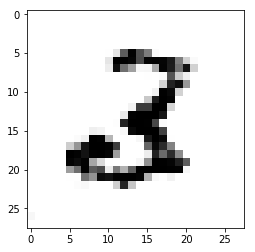

Estimate: [[ 0.18617484]]
Iteration: 86200 at 2017-06-30 19:28:17.257616


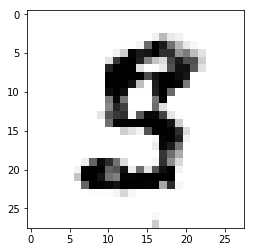

Estimate: [[ 9.41923618]]
Iteration: 86300 at 2017-06-30 19:28:26.921535


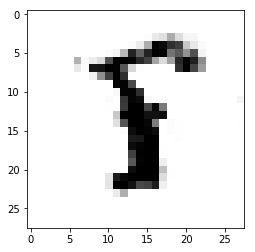

Estimate: [[-14.24612522]]
Iteration: 86400 at 2017-06-30 19:28:36.611977


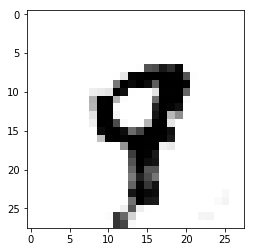

Estimate: [[ 64.92221069]]
Iteration: 86500 at 2017-06-30 19:28:46.292365


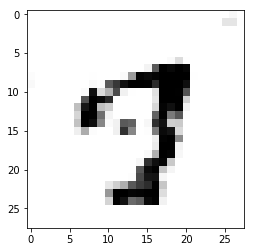

Estimate: [[-32.25530243]]
Iteration: 86600 at 2017-06-30 19:28:56.065119


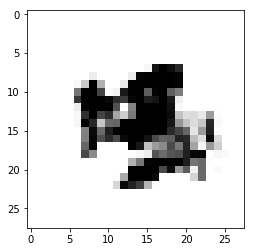

Estimate: [[-20.8572464]]
Iteration: 86700 at 2017-06-30 19:29:05.736330


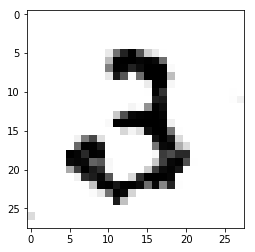

Estimate: [[ 10.63357258]]
Iteration: 86800 at 2017-06-30 19:29:15.418396


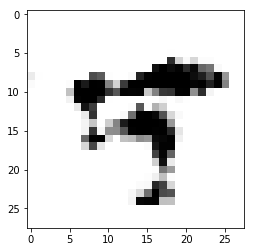

Estimate: [[-56.44367599]]
Iteration: 86900 at 2017-06-30 19:29:25.139877


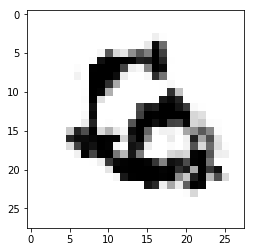

Estimate: [[ 9.04391003]]
Iteration: 87000 at 2017-06-30 19:29:36.966594


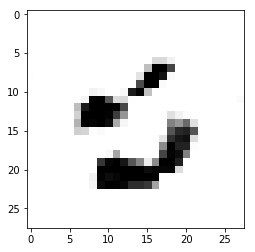

Estimate: [[ 49.44487]]
Iteration: 87100 at 2017-06-30 19:29:46.747995


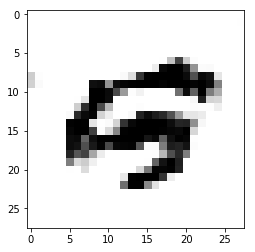

Estimate: [[ 59.57560349]]
Iteration: 87200 at 2017-06-30 19:29:56.535889


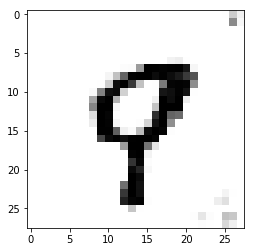

Estimate: [[ 10.16074467]]
Iteration: 87300 at 2017-06-30 19:30:06.310776


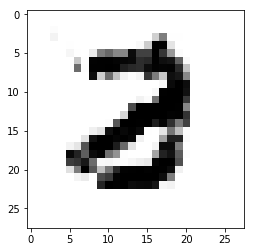

Estimate: [[ 17.42623711]]
Iteration: 87400 at 2017-06-30 19:30:16.118118


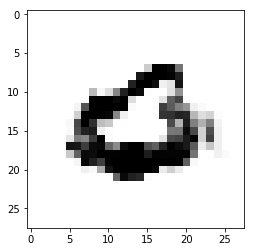

Estimate: [[ 58.25304031]]
Iteration: 87500 at 2017-06-30 19:30:25.916375


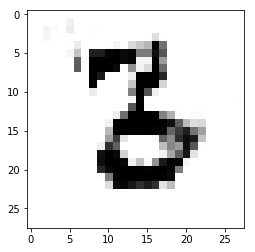

Estimate: [[ 35.18029022]]
Iteration: 87600 at 2017-06-30 19:30:35.758797


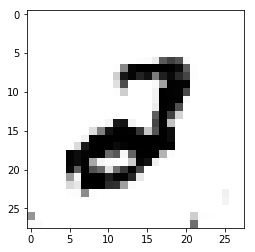

Estimate: [[ 9.43643856]]
Iteration: 87700 at 2017-06-30 19:30:45.635488


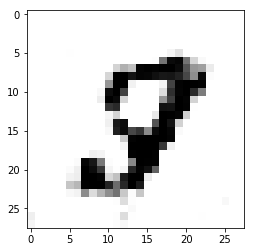

Estimate: [[-26.09228706]]
Iteration: 87800 at 2017-06-30 19:30:55.405923


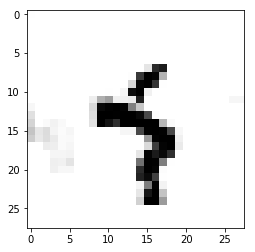

Estimate: [[ 16.46422005]]
Iteration: 87900 at 2017-06-30 19:31:05.199250


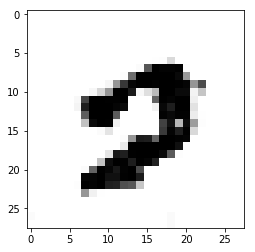

Estimate: [[ 25.2467041]]
Iteration: 88000 at 2017-06-30 19:31:14.975557


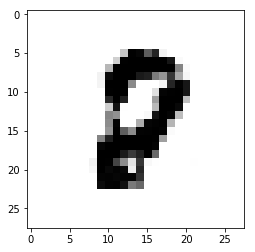

Estimate: [[-5.15707827]]
Iteration: 88100 at 2017-06-30 19:31:24.777846


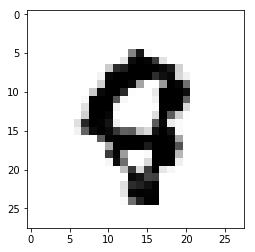

Estimate: [[ 26.60610008]]
Iteration: 88200 at 2017-06-30 19:31:34.562398


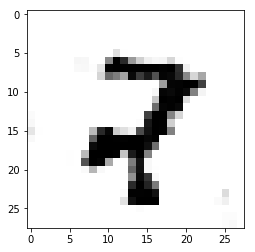

Estimate: [[-17.36551666]]
Iteration: 88300 at 2017-06-30 19:31:44.354168


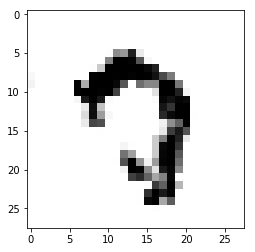

Estimate: [[-10.09232616]]
Iteration: 88400 at 2017-06-30 19:31:54.180147


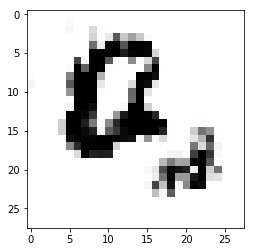

Estimate: [[ 63.58709717]]
Iteration: 88500 at 2017-06-30 19:32:03.975103


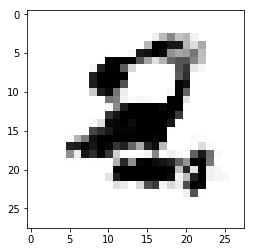

Estimate: [[-2.12183738]]
Iteration: 88600 at 2017-06-30 19:32:13.790744


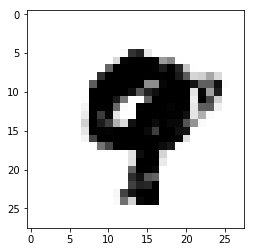

Estimate: [[-21.72587395]]
Iteration: 88700 at 2017-06-30 19:32:23.595665


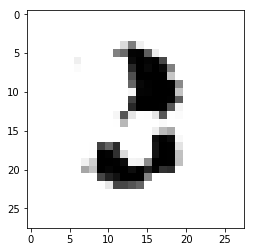

Estimate: [[ 3.66702342]]
Iteration: 88800 at 2017-06-30 19:32:33.523709


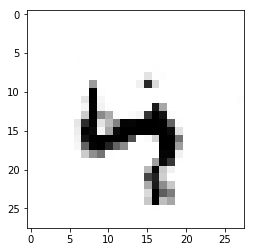

Estimate: [[ 34.60932541]]
Iteration: 88900 at 2017-06-30 19:32:43.377454


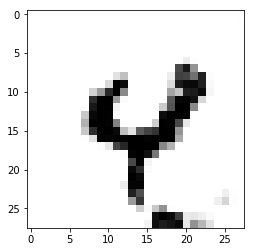

Estimate: [[ 54.06220627]]
Iteration: 89000 at 2017-06-30 19:32:53.201136


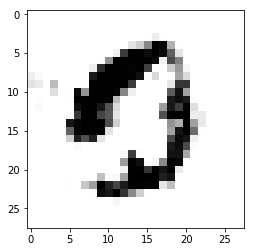

Estimate: [[-16.05035019]]
Iteration: 89100 at 2017-06-30 19:33:03.066349


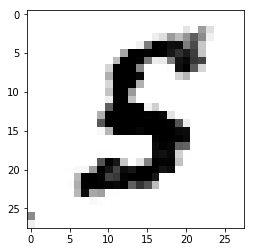

Estimate: [[ 36.4642334]]
Iteration: 89200 at 2017-06-30 19:33:12.904753


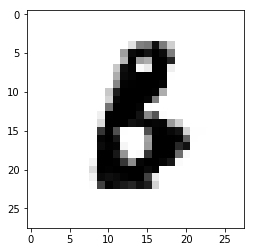

Estimate: [[ 32.80589294]]
Iteration: 89300 at 2017-06-30 19:33:22.740417


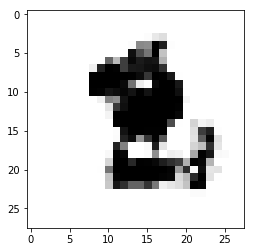

Estimate: [[-59.94252777]]
Iteration: 89400 at 2017-06-30 19:33:32.575084


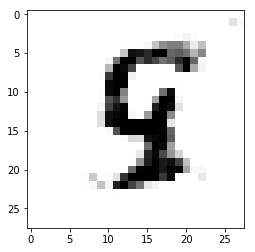

Estimate: [[ 7.55820322]]
Iteration: 89500 at 2017-06-30 19:33:42.438778


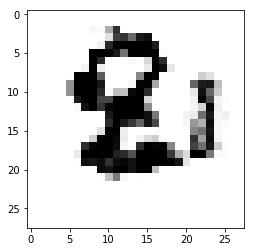

Estimate: [[ 35.2196846]]
Iteration: 89600 at 2017-06-30 19:33:52.331475


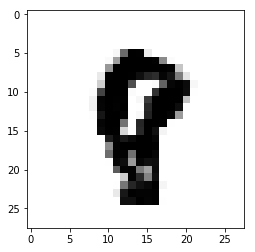

Estimate: [[-1.87437499]]
Iteration: 89700 at 2017-06-30 19:34:02.209505


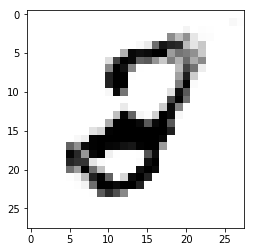

Estimate: [[ 27.38918686]]
Iteration: 89800 at 2017-06-30 19:34:12.075319


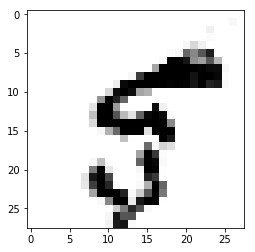

Estimate: [[ 6.8795929]]
Iteration: 89900 at 2017-06-30 19:34:22.046586


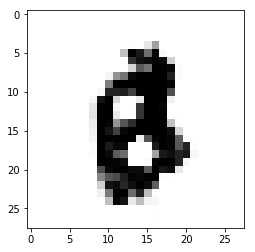

Estimate: [[ 18.40844727]]
Iteration: 90000 at 2017-06-30 19:34:31.906558


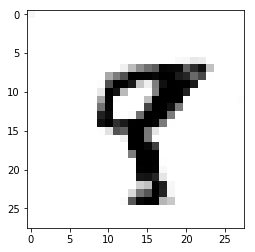

Estimate: [[ 9.3297863]]
Iteration: 90100 at 2017-06-30 19:34:41.932939


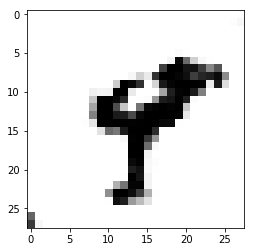

Estimate: [[ 27.03621101]]
Iteration: 90200 at 2017-06-30 19:34:51.827024


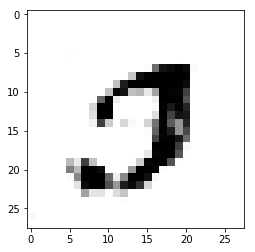

Estimate: [[-46.66797256]]
Iteration: 90300 at 2017-06-30 19:35:01.719958


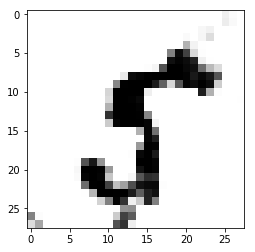

Estimate: [[ 71.49710083]]
Iteration: 90400 at 2017-06-30 19:35:11.612913


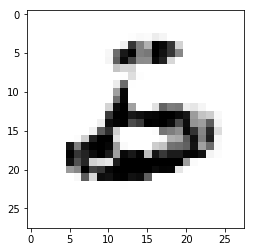

Estimate: [[ 40.20513153]]
Iteration: 90500 at 2017-06-30 19:35:21.517136


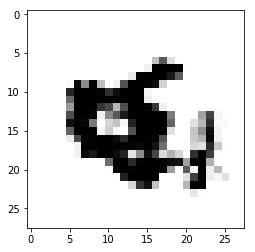

Estimate: [[ 66.12181854]]
Iteration: 90600 at 2017-06-30 19:35:31.452788


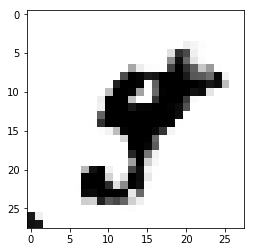

Estimate: [[ 33.1555481]]
Iteration: 90700 at 2017-06-30 19:35:41.375425


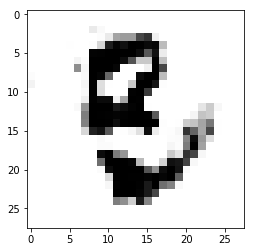

Estimate: [[ 5.45350933]]
Iteration: 90800 at 2017-06-30 19:35:51.275670


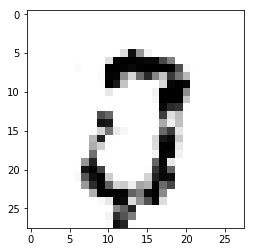

Estimate: [[ 17.95402145]]
Iteration: 90900 at 2017-06-30 19:36:01.295168


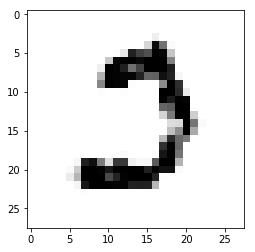

Estimate: [[ 50.053936]]
Iteration: 91000 at 2017-06-30 19:36:11.301101


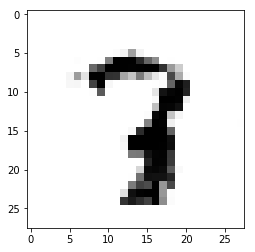

Estimate: [[ 24.49340248]]
Iteration: 91100 at 2017-06-30 19:36:21.282322


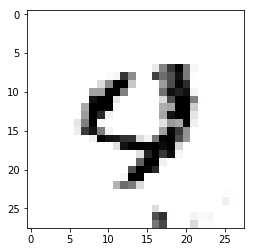

Estimate: [[ 5.81063557]]
Iteration: 91200 at 2017-06-30 19:36:31.205762


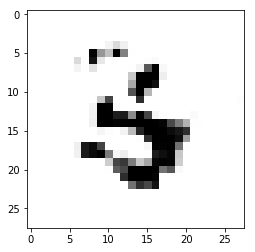

Estimate: [[-51.51387024]]
Iteration: 91300 at 2017-06-30 19:36:41.261178


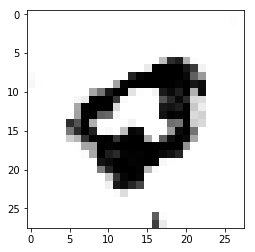

Estimate: [[ 50.44087601]]
Iteration: 91400 at 2017-06-30 19:36:51.476905


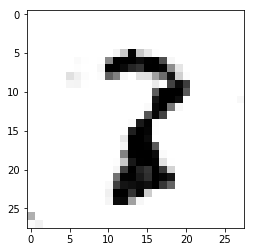

Estimate: [[-4.96466351]]
Iteration: 91500 at 2017-06-30 19:37:01.475557


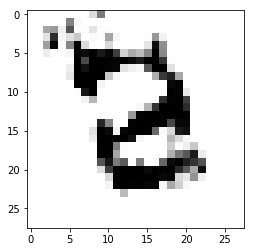

Estimate: [[ 52.92430878]]
Iteration: 91600 at 2017-06-30 19:37:11.443114


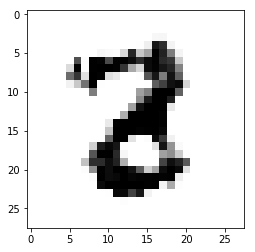

Estimate: [[-4.00633001]]
Iteration: 91700 at 2017-06-30 19:37:21.560194


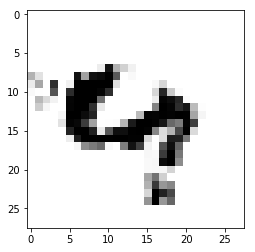

Estimate: [[ 40.68847275]]
Iteration: 91800 at 2017-06-30 19:37:31.518985


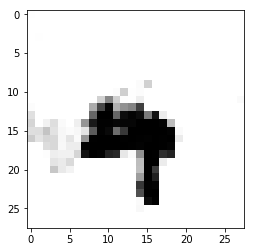

Estimate: [[ 43.39899063]]
Iteration: 91900 at 2017-06-30 19:37:41.740238


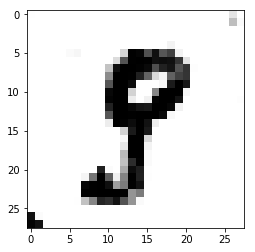

Estimate: [[ 16.55864525]]
Iteration: 92000 at 2017-06-30 19:37:51.810859


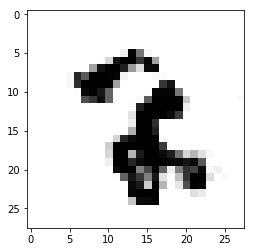

Estimate: [[-6.45491648]]
Iteration: 92100 at 2017-06-30 19:38:02.014102


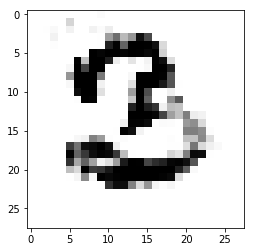

Estimate: [[ 2.6126895]]
Iteration: 92200 at 2017-06-30 19:38:12.637473


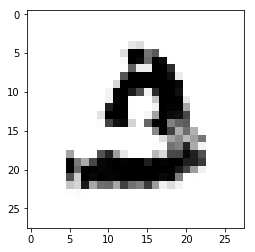

Estimate: [[-5.57666111]]
Iteration: 92300 at 2017-06-30 19:38:22.830706


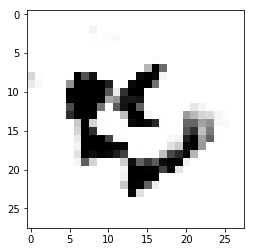

Estimate: [[-44.24330521]]
Iteration: 92400 at 2017-06-30 19:38:33.036452


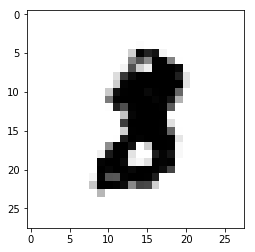

Estimate: [[ 85.9897995]]
Iteration: 92500 at 2017-06-30 19:38:43.274228


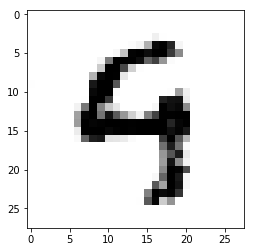

Estimate: [[ 5.96298027]]
Iteration: 92600 at 2017-06-30 19:38:53.624612


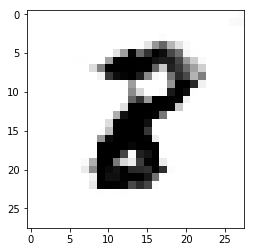

Estimate: [[ 27.08454704]]
Iteration: 92700 at 2017-06-30 19:39:03.795829


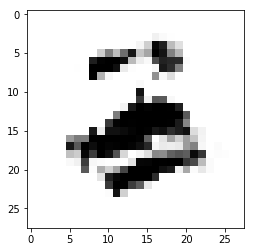

Estimate: [[-19.41100502]]
Iteration: 92800 at 2017-06-30 19:39:13.946021


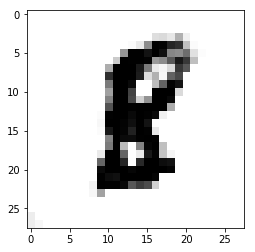

Estimate: [[ 53.85422516]]
Iteration: 92900 at 2017-06-30 19:39:24.144260


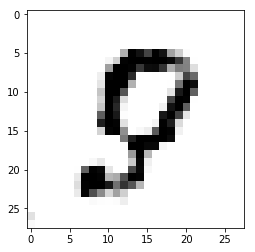

Estimate: [[ 44.47511292]]
Iteration: 93000 at 2017-06-30 19:39:34.336493


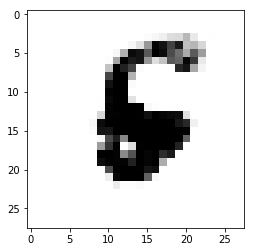

Estimate: [[ 42.67314911]]
Iteration: 93100 at 2017-06-30 19:39:44.572266


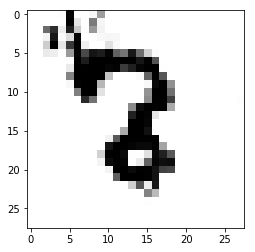

Estimate: [[-35.01327896]]
Iteration: 93200 at 2017-06-30 19:39:54.846078


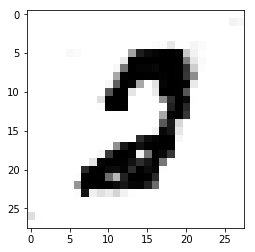

Estimate: [[ 29.15433884]]
Iteration: 93300 at 2017-06-30 19:40:05.053825


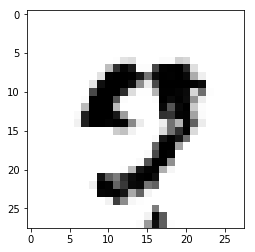

Estimate: [[ 21.89335632]]
Iteration: 93400 at 2017-06-30 19:40:15.239051


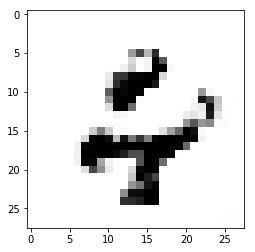

Estimate: [[ 41.69604874]]
Iteration: 93500 at 2017-06-30 19:40:25.517366


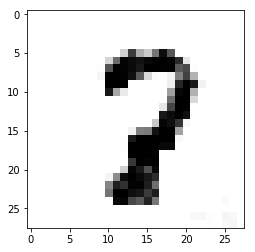

Estimate: [[ 42.19955444]]
Iteration: 93600 at 2017-06-30 19:40:35.972850


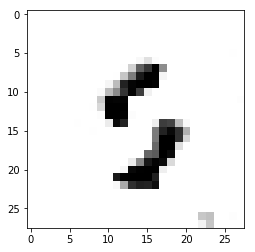

Estimate: [[-25.13792992]]
Iteration: 93700 at 2017-06-30 19:40:46.333744


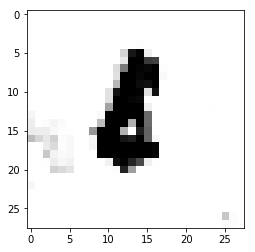

Estimate: [[ 40.08948135]]
Iteration: 93800 at 2017-06-30 19:40:56.722668


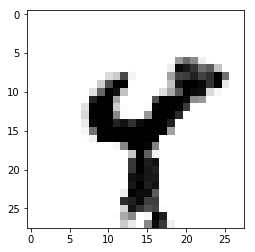

Estimate: [[ 33.24373245]]
Iteration: 93900 at 2017-06-30 19:41:07.054034


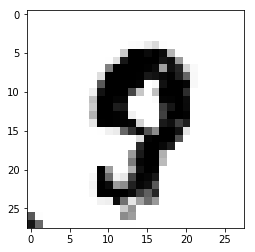

Estimate: [[ 10.77087116]]
Iteration: 94000 at 2017-06-30 19:41:17.535042


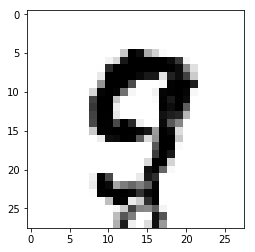

Estimate: [[ 24.89299011]]
Iteration: 94100 at 2017-06-30 19:41:28.061594


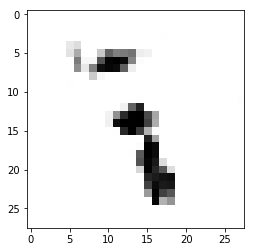

Estimate: [[ 39.73609543]]
Iteration: 94200 at 2017-06-30 19:41:38.315385


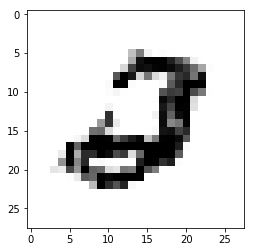

Estimate: [[-41.74120712]]
Iteration: 94300 at 2017-06-30 19:41:48.652257


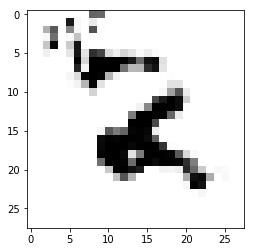

Estimate: [[ 29.39102745]]
Iteration: 94400 at 2017-06-30 19:41:58.891534


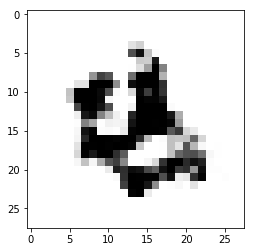

Estimate: [[-35.16059875]]
Iteration: 94500 at 2017-06-30 19:42:09.289463


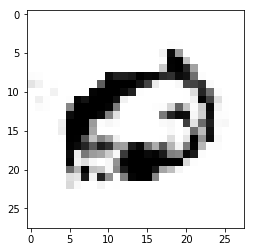

Estimate: [[-23.42720795]]
Iteration: 94600 at 2017-06-30 19:42:19.443660


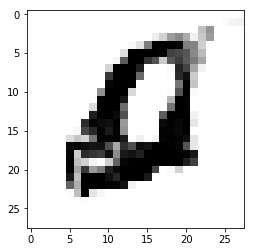

Estimate: [[-22.39474106]]
Iteration: 94700 at 2017-06-30 19:42:29.696955


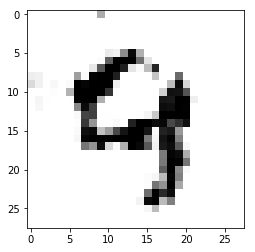

Estimate: [[ 48.87142181]]
Iteration: 94800 at 2017-06-30 19:42:40.348630


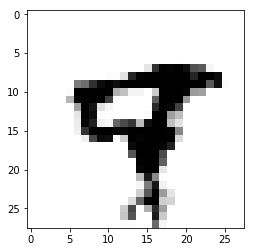

Estimate: [[ 9.41357613]]
Iteration: 94900 at 2017-06-30 19:42:50.736549


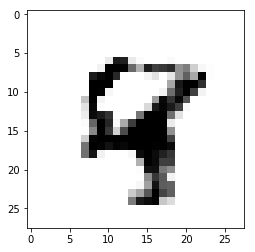

Estimate: [[ 3.11377645]]
Iteration: 95000 at 2017-06-30 19:43:01.210051


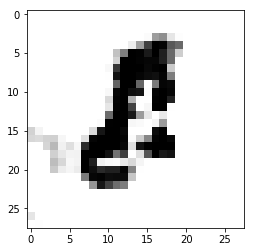

Estimate: [[-7.37840652]]
Iteration: 95100 at 2017-06-30 19:43:11.635506


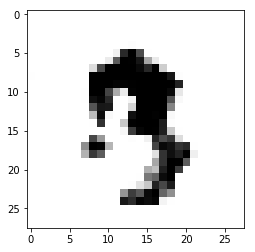

Estimate: [[-45.80886841]]
Iteration: 95200 at 2017-06-30 19:43:21.998903


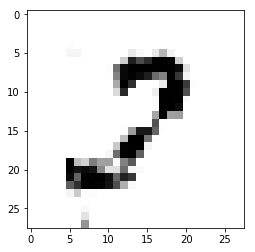

Estimate: [[-1.30699551]]
Iteration: 95300 at 2017-06-30 19:43:32.332770


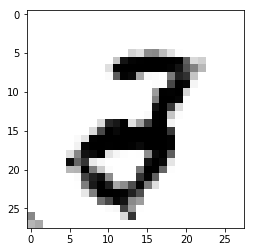

Estimate: [[ 51.30454636]]
Iteration: 95400 at 2017-06-30 19:43:42.901865


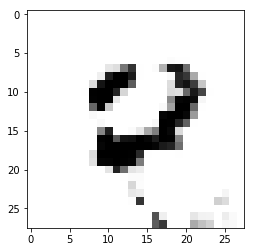

Estimate: [[ 8.48405933]]
Iteration: 95500 at 2017-06-30 19:43:53.487977


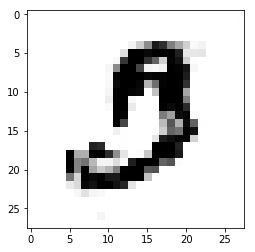

Estimate: [[ 11.52731323]]
Iteration: 95600 at 2017-06-30 19:44:03.847870


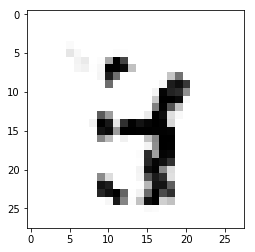

Estimate: [[ 24.50394058]]
Iteration: 95700 at 2017-06-30 19:44:14.274827


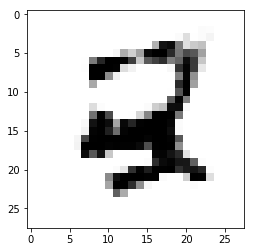

Estimate: [[-7.02501202]]
Iteration: 95800 at 2017-06-30 19:44:24.688772


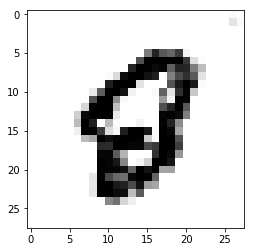

Estimate: [[ 61.79936981]]
Iteration: 95900 at 2017-06-30 19:44:35.205818


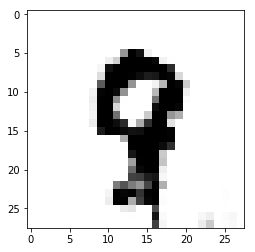

Estimate: [[ 38.03654861]]
Iteration: 96000 at 2017-06-30 19:44:45.758895


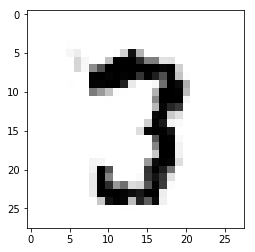

Estimate: [[-6.00421333]]
Iteration: 96100 at 2017-06-30 19:44:56.216884


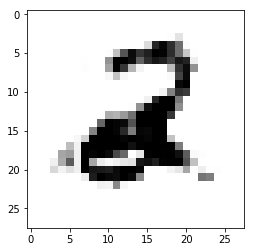

Estimate: [[ 27.17359924]]
Iteration: 96200 at 2017-06-30 19:45:06.798988


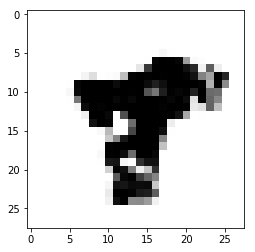

Estimate: [[ 48.32194519]]
Iteration: 96300 at 2017-06-30 19:45:17.306022


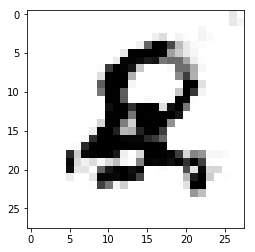

Estimate: [[-14.35242844]]
Iteration: 96400 at 2017-06-30 19:45:27.583840


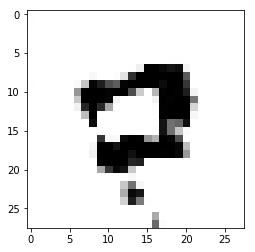

Estimate: [[ 5.71929502]]
Iteration: 96500 at 2017-06-30 19:45:38.108890


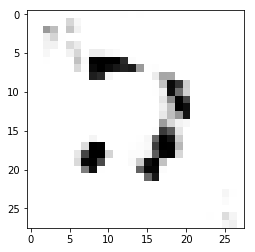

Estimate: [[ 28.17684746]]
Iteration: 96600 at 2017-06-30 19:45:48.400718


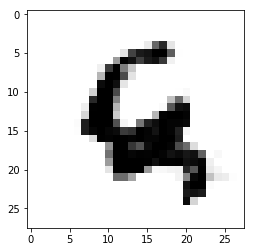

Estimate: [[ 73.71766663]]
Iteration: 96700 at 2017-06-30 19:45:58.644003


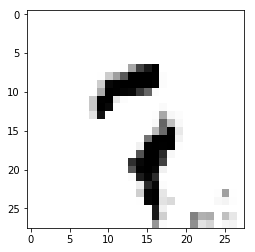

Estimate: [[-25.74081802]]
Iteration: 96800 at 2017-06-30 19:46:08.968362


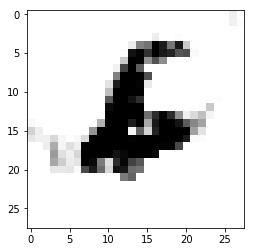

Estimate: [[ 6.02755785]]
Iteration: 96900 at 2017-06-30 19:46:19.220152


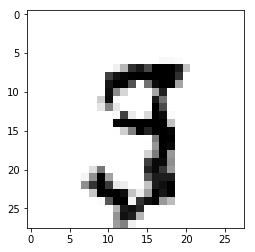

Estimate: [[ 26.31389046]]
Iteration: 97000 at 2017-06-30 19:46:29.542008


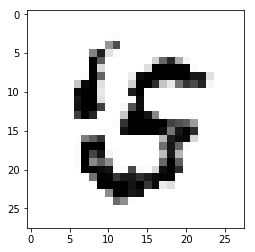

Estimate: [[-18.78084564]]
Iteration: 97100 at 2017-06-30 19:46:40.088591


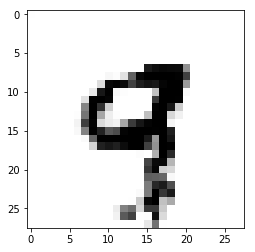

Estimate: [[ 30.94156837]]
Iteration: 97200 at 2017-06-30 19:46:50.439201


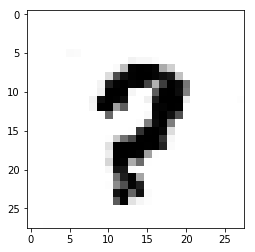

Estimate: [[-8.82471943]]
Iteration: 97300 at 2017-06-30 19:47:00.666550


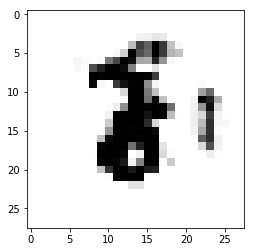

Estimate: [[-29.82094574]]
Iteration: 97400 at 2017-06-30 19:47:10.885904


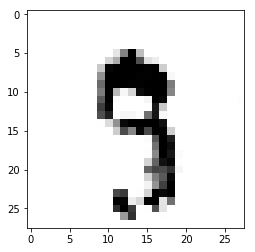

Estimate: [[ 7.31109905]]
Iteration: 97500 at 2017-06-30 19:47:21.123940


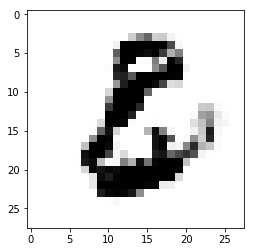

Estimate: [[ 29.02379799]]
Iteration: 97600 at 2017-06-30 19:47:31.510636


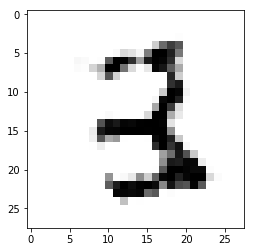

Estimate: [[ 18.83869934]]
Iteration: 97700 at 2017-06-30 19:47:41.777410


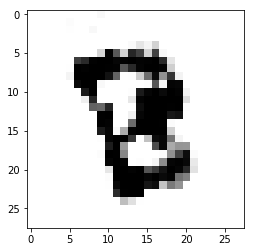

Estimate: [[ 48.16441727]]
Iteration: 97800 at 2017-06-30 19:47:52.094029


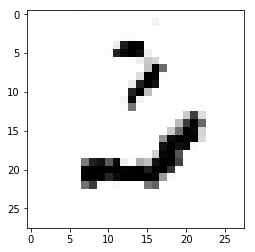

Estimate: [[ 69.83862305]]
Iteration: 97900 at 2017-06-30 19:48:02.372624


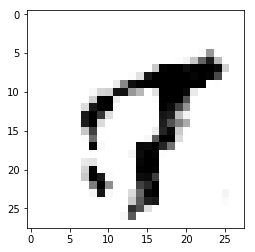

Estimate: [[ 21.58574104]]
Iteration: 98000 at 2017-06-30 19:48:12.646355


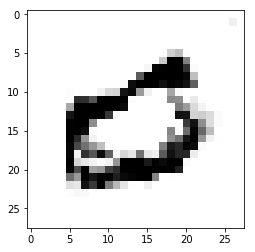

Estimate: [[ 18.86348152]]
Iteration: 98100 at 2017-06-30 19:48:22.966000


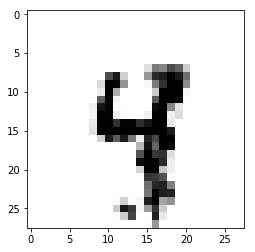

Estimate: [[ 21.70768166]]
Iteration: 98200 at 2017-06-30 19:48:33.265789


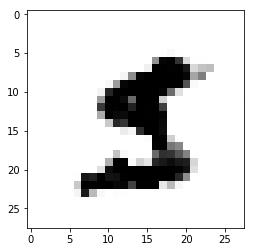

Estimate: [[ 57.31090164]]
Iteration: 98300 at 2017-06-30 19:48:43.567267


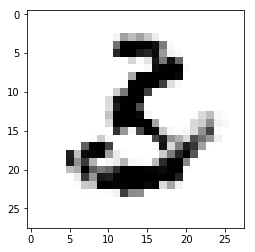

Estimate: [[-12.86146832]]
Iteration: 98400 at 2017-06-30 19:48:53.934149


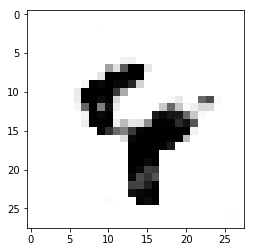

Estimate: [[-48.97352219]]
Iteration: 98500 at 2017-06-30 19:49:04.594750


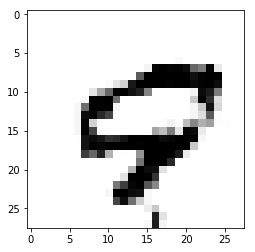

Estimate: [[ 53.00487137]]
Iteration: 98600 at 2017-06-30 19:49:15.223904


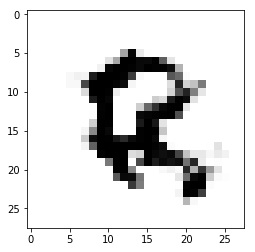

Estimate: [[ 7.88490057]]
Iteration: 98700 at 2017-06-30 19:49:25.740446


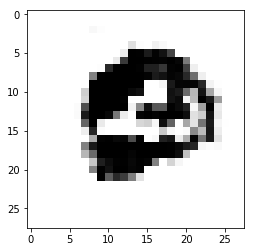

Estimate: [[ 8.77248573]]
Iteration: 98800 at 2017-06-30 19:49:36.187425


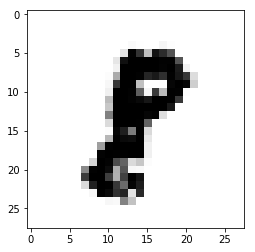

Estimate: [[-18.73006439]]
Iteration: 98900 at 2017-06-30 19:49:46.597866


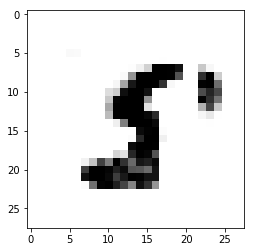

Estimate: [[ 2.15368915]]
Iteration: 99000 at 2017-06-30 19:49:57.044841


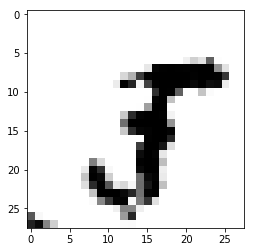

Estimate: [[ 44.11783218]]
Iteration: 99100 at 2017-06-30 19:50:07.521846


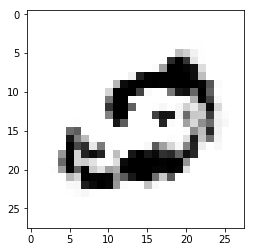

Estimate: [[-54.08972549]]
Iteration: 99200 at 2017-06-30 19:50:17.977830


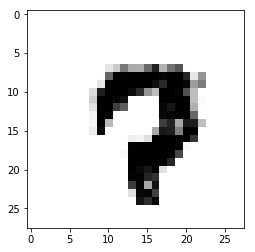

Estimate: [[ 6.75070572]]
Iteration: 99300 at 2017-06-30 19:50:28.413296


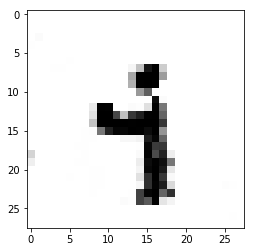

Estimate: [[-43.4899826]]
Iteration: 99400 at 2017-06-30 19:50:38.949857


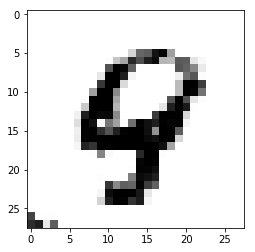

Estimate: [[ 3.5068388]]
Iteration: 99500 at 2017-06-30 19:50:49.421868


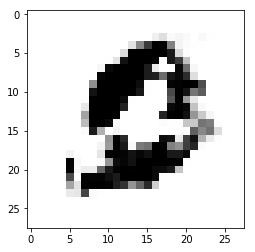

Estimate: [[-15.49763012]]
Iteration: 99600 at 2017-06-30 19:50:59.954926


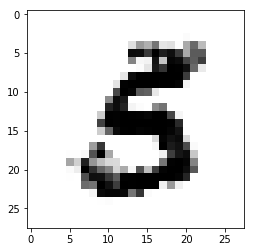

Estimate: [[ 0.02147209]]
Iteration: 99700 at 2017-06-30 19:51:10.406907


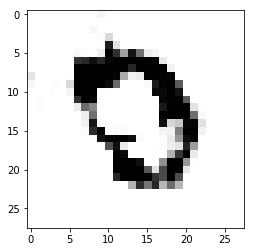

Estimate: [[-6.48791981]]
Iteration: 99800 at 2017-06-30 19:51:20.939465


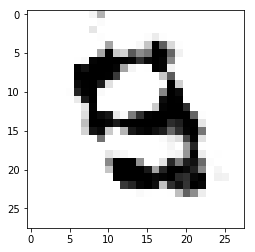

Estimate: [[ 47.95874405]]
Iteration: 99900 at 2017-06-30 19:51:31.401955


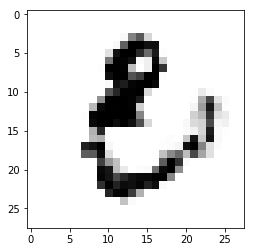

Estimate: [[ 91.37928772]]


In [14]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Pre-train discriminator
for i in range(300):
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
    _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                           {x_placeholder: real_image_batch, z_placeholder: z_batch})

    if(i % 100 == 0):
        print("dLossReal:", dLossReal, "dLossFake:", dLossFake)

# Train generator and discriminator together
for i in range(100000):
    real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])

    # Train discriminator on both real and fake images
    _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                           {x_placeholder: real_image_batch, z_placeholder: z_batch})

    # Train generator
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    _ = sess.run(g_trainer, feed_dict={z_placeholder: z_batch})

    if i % 10 == 0:
        # Update TensorBoard with summary statistics
        z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
        summary = sess.run(merged, {z_placeholder: z_batch, x_placeholder: real_image_batch})
        writer.add_summary(summary, i)

    if i % 100 == 0:
        # Every 100 iterations, show a generated image
        print("Iteration:", i, "at", datetime.datetime.now())
        z_batch = np.random.normal(0, 1, size=[1, z_dimensions])
        generated_images = generator(z_placeholder, 1, z_dimensions)
        images = sess.run(generated_images, {z_placeholder: z_batch})
        plt.imshow(images[0].reshape([28, 28]), cmap='Greys')
        plt.show()

        # Show discriminator's estimate
        im = images[0].reshape([1, 28, 28, 1])
        result = discriminator(x_placeholder)
        estimate = sess.run(result, {x_placeholder: im})
        print("Estimate:", estimate)

Because it can take so long to train a GAN, we recommend that you skip the cell above and execute the following cell. It loads a model that we've already trained for several hours on a fast GPU machine, and lets you experiment with the output of a trained GAN.

In [15]:
saver = tf.train.Saver()
saver.save(sess, "trained_model/model.ckpt")

'trained_model/model.ckpt'

INFO:tensorflow:Restoring parameters from trained_model/model.ckpt


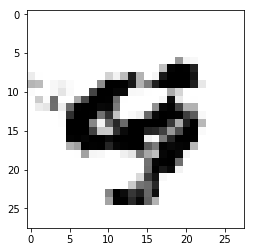

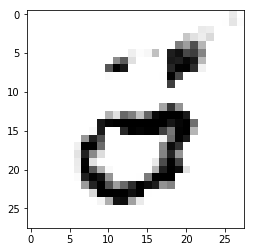

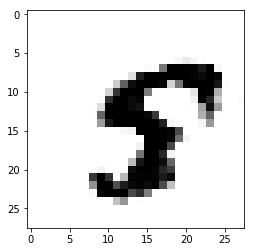

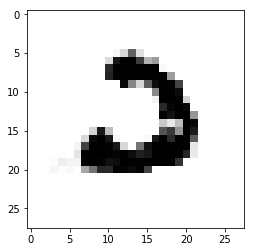

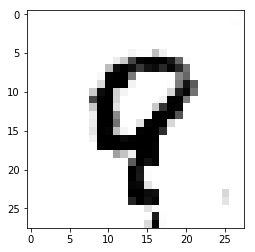

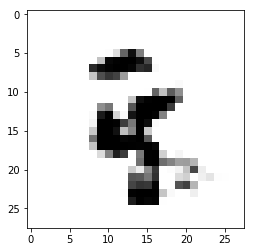

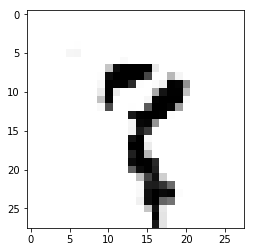

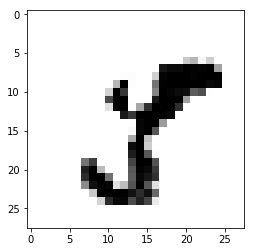

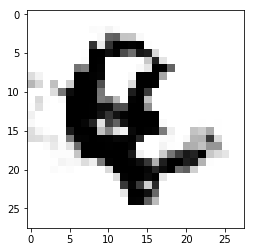

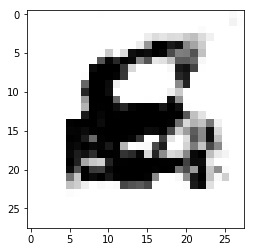

In [19]:
saver = tf.train.Saver()
with tf.Session() as sess:
#     saver.restore(sess, 'pretrained-model/pretrained_gan.ckpt')
    saver.restore(sess, 'trained_model/model.ckpt')
    z_batch = np.random.normal(0, 1, size=[10, z_dimensions])
    z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions], name='z_placeholder') 
    generated_images = generator(z_placeholder, 10, z_dimensions)
    images = sess.run(generated_images, {z_placeholder: z_batch})
    for i in range(10):
        plt.imshow(images[i].reshape([28, 28]), cmap='Greys')
        plt.show()

## Training difficulties

GANs are notoriously difficult to train. Without the right hyperparameters, network architecture, and training procedure, the discriminator can overpower the generator, or vice-versa.

In one common failure mode, the discriminator overpowers the generator, classifying generated images as fake with absolute certainty. When the discriminator responds with absolute certainty, it leaves no gradient for the generator to descend. This is partly why we built our discriminator to produce unscaled output rather than passing its output through a sigmoid function that would push its evaluation toward either 0 or 1.

In another common failure mode known as **mode collapse**, the generator discovers and exploits some weakness in the discriminator. You can recognize mode collapse in your GAN if it generates many very similar images regardless of variation in the generator input _z_. Mode collapse can sometimes be corrected by "strengthening" the discriminator in some way—for instance, by adjusting its training rate or by reconfiguring its layers.

Researchers have identified a handful of ["GAN hacks"](https://github.com/soumith/ganhacks) that can be helpful in building stable GANs.

## Closing thoughts

GANs have tremendous potential to reshape the digital world that we interact with every day. The field is still very young, and the next great GAN discovery could be yours!

## Other resources

- [The original GAN paper](https://arxiv.org/abs/1406.2661) by Ian Goodfellow and his collaborators, published in 2014
- [A more recent tutorial by Goodfellow](https://arxiv.org/abs/1701.00160) that explains GANs in somewhat more accessible terms
- [A paper by Alec Radford, Luke Metz, and Soumith Chintala](https://arxiv.org/abs/1511.06434) that introduces deep convolutional GANs, whose basic structure we use in our generator in this tutorial. Also see [their DCGAN code on GitHub](https://github.com/Newmu/dcgan_code).
- [A reference collection of generative networks by Agustinus Kristiadi](https://github.com/wiseodd/generative-models), implemented in TensorFlow